In [1]:
import sys
import os
import numpy as np
import pandas as pd

import h5py

import matplotlib.pyplot as plt

from scipy.stats import spearmanr, pearsonr

from scipy.ndimage import gaussian_filter1d

import seaborn as sns

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

#Helper function to draw a letter at a given position
def dna_letter_at(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    #Define letter heights and colors
    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange',#'orange', 
                    'A': 'green',#'red', 
                    'C': 'blue',#'blue', 
                    'T': 'red',#'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    #Choose color
    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    #Draw letter onto axis
    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    
    return p

#Function to plot sequence logo
def plot_seq_scores(importance_scores, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :

    importance_scores = importance_scores.T

    fig = plt.figure(figsize=figsize)
    
    ref_seq = ""
    
    #Loop over reference sequence letters
    for j in range(importance_scores.shape[1]) :
        argmax_nt = np.argmax(np.abs(importance_scores[:, j]))
        
        if argmax_nt == 0 :
            ref_seq += "A"
        elif argmax_nt == 1 :
            ref_seq += "C"
        elif argmax_nt == 2 :
            ref_seq += "G"
        elif argmax_nt == 3 :
            ref_seq += "T"

    ax = plt.gca()
    
    #Loop over reference sequence letters and draw
    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        color = None
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, len(ref_seq)))
    
    #plt.axis('off')
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    #Set axis limits
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        plt.ylim(
            np.min(importance_scores) - 0.1 * np.max(np.abs(importance_scores)),
            np.max(importance_scores) + 0.1 * np.max(np.abs(importance_scores))
        )
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()


In [2]:
#Load gene dataframe and select tissue

tissue = 'liver'

top_n = 200

gene_df = pd.read_csv("/home/jlinder/seqnn/data/diff_expr/gtex_diff_expr_log2fc_5k.csv", sep='\t')
gene_df = gene_df.query("tissue == '" + str(tissue) + "'").copy().reset_index(drop=True)
gene_df = gene_df.drop(columns=['Unnamed: 0'])

#Select top N
gene_df = gene_df.iloc[:top_n].copy().reset_index(drop=True)

print("len(gene_df) = " + str(len(gene_df)))

#Get list of gene for tissue
tissue_genes = gene_df['gene_base'].values.tolist()

print("len(tissue_genes) = " + str(len(tissue_genes)))


len(gene_df) = 200
len(tissue_genes) = 200


In [3]:
#Load scores for the selected set of GTEx tissues (grad)

import gc

gtex_tissues = ['blood', 'liver', 'brain', 'muscle', 'esophagus']

seqs = None
strands = None
chrs = None
starts = None
ends = None
genes = None

all_scores_hyp = []
all_scores = []

#Loop over tissues
for gtex_tissue in gtex_tissues :
    
    print("tissue = '" + gtex_tissue + "'")

    score_file = h5py.File('scores_v2/gtex_' + gtex_tissue + '_log2fc_undo_clip_scores_mean.h5', 'r')

    #Get scores and onehots
    scores = score_file['grads'][()][..., 0]
    seqs = score_file['seqs'][()]

    #Get auxiliary information
    strands = score_file['strand'][()]
    strands = np.array([strands[j].decode() for j in range(strands.shape[0])])

    chrs = score_file['chr'][()]
    chrs = np.array([chrs[j].decode() for j in range(chrs.shape[0])])

    starts = np.array(score_file['start'][()])
    ends = np.array(score_file['end'][()])

    genes = score_file['gene'][()]
    genes = np.array([genes[j].decode().split(".")[0] for j in range(genes.shape[0])])
    
    gene_dict = {gene : gene_i for gene_i, gene in enumerate(genes.tolist())}

    #Get index of rows to keep
    keep_index = []
    for tissue_gene in tissue_genes :
        keep_index.append(gene_dict[tissue_gene])

    #Filter/sub-select data
    scores = scores[keep_index, ...]
    seqs = seqs[keep_index, ...]
    strands = strands[keep_index]
    chrs = chrs[keep_index]
    starts = starts[keep_index]
    ends = ends[keep_index]
    genes = genes[keep_index]

    #Append hypothetical scores
    all_scores_hyp.append(scores[None, ...])

    #Append input-gated scores
    all_scores.append((scores * seqs)[None, ...])

    #Collect garbage
    gc.collect()

#Collect final scores
scores_hyp = np.concatenate(all_scores_hyp, axis=0)
scores = np.concatenate(all_scores, axis=0)

print("scores_hyp.shape = " + str(scores_hyp.shape))
print("scores.shape = " + str(scores.shape))

score_file = None

#Collect garbage
gc.collect()


tissue = 'blood'
tissue = 'liver'
tissue = 'brain'
tissue = 'muscle'
tissue = 'esophagus'
scores_hyp.shape = (5, 200, 524288, 4)
scores.shape = (5, 200, 524288, 4)


0

-- Example = 0 --
 - ENSG00000079557(+)
 - chr4:73230783-73755071
 -- min_val = -0.5312
 -- max_val = 1.697
 - (Gradient score profiles per tissue) - 


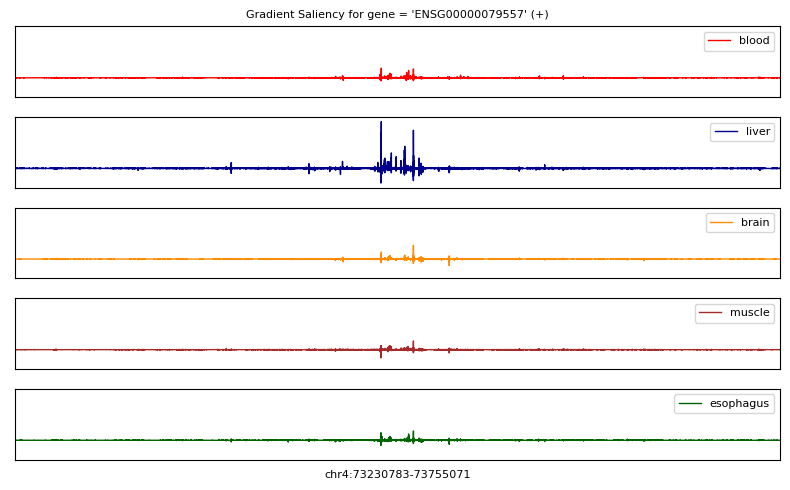

 - (Gradient score comparison against 'liver') - 
blood (r = 0.071)
brain (r = 0.193)
muscle (r = 0.201)
esophagus (r = 0.045)


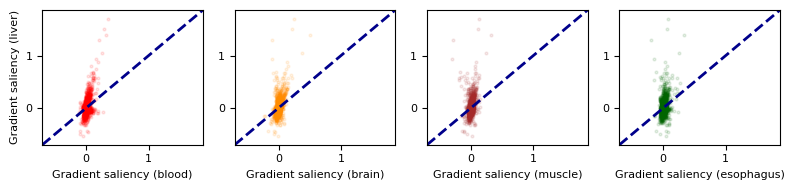

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.52)
brain (r = 0.419)
muscle (r = 0.287)
esophagus (r = 0.304)


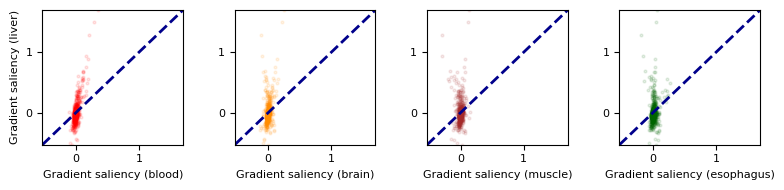

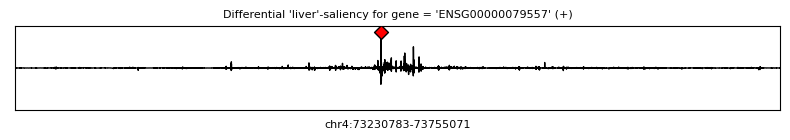

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 251077
 - max_pos (abs) = 73481860
 - chr4:73481764-73481956
blood


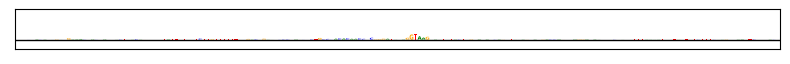

liver


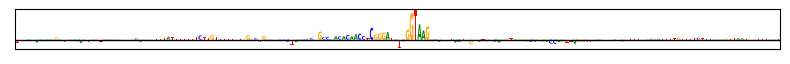

brain


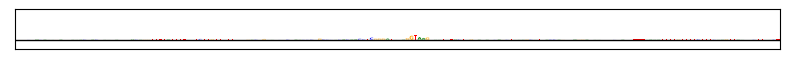

muscle


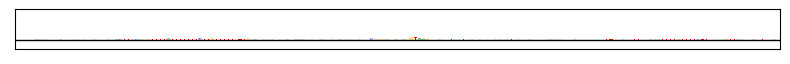

esophagus


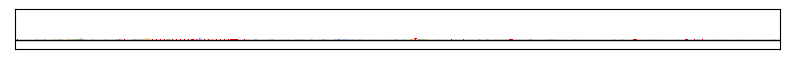

--------------------

-- Example = 1 --
 - ENSG00000156096(-)
 - chr4:69226110-69750398
 -- min_val = -0.741
 -- max_val = 1.742
 - (Gradient score profiles per tissue) - 


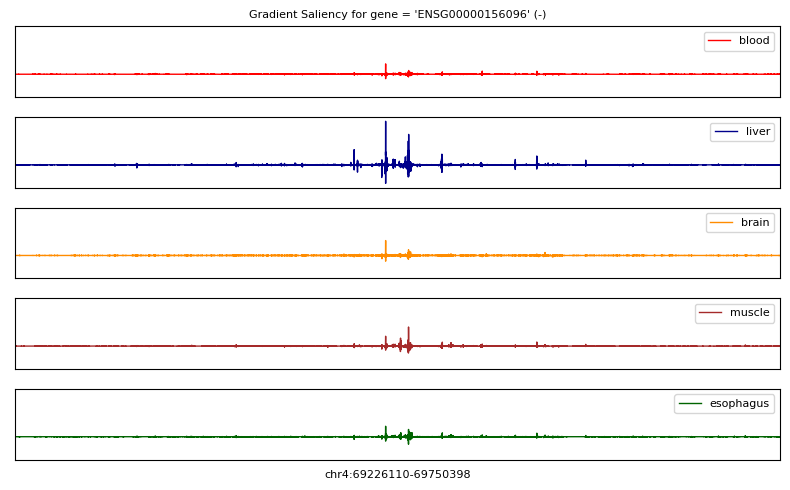

 - (Gradient score comparison against 'liver') - 
blood (r = 0.246)
brain (r = 0.162)
muscle (r = 0.339)
esophagus (r = 0.278)


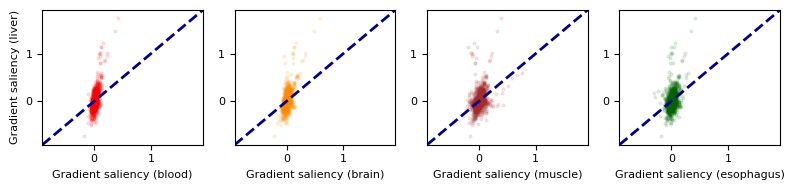

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.444)
brain (r = 0.474)
muscle (r = 0.295)
esophagus (r = 0.299)


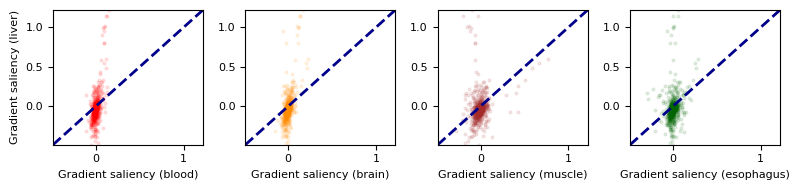

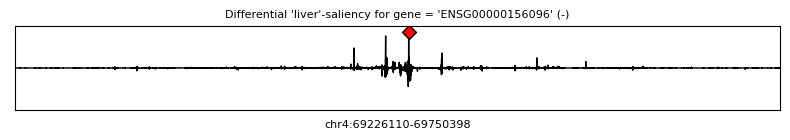

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 269840
 - max_pos (abs) = 69495950
 - chr4:69495854-69496046
blood


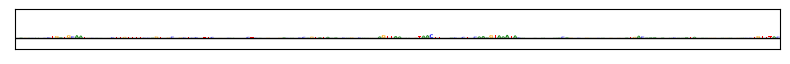

liver


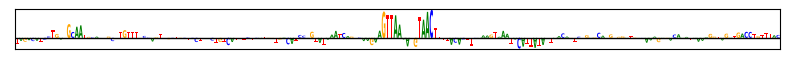

brain


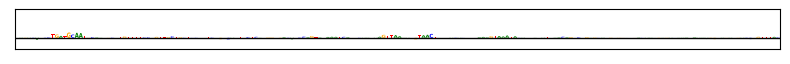

muscle


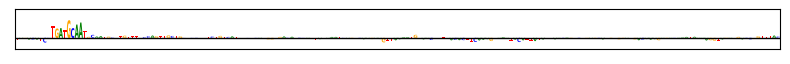

esophagus


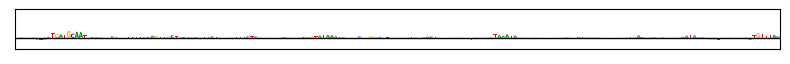

--------------------

-- Example = 2 --
 - ENSG00000080910(+)
 - chr1:196692638-197216926
 -- min_val = -1.79
 -- max_val = 2.809
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


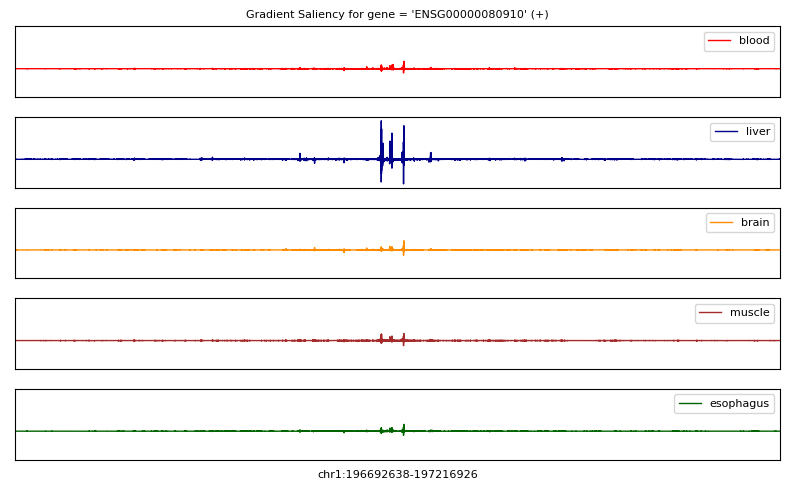

 - (Gradient score comparison against 'liver') - 
blood (r = 0.338)
brain (r = 0.345)
muscle (r = 0.402)
esophagus (r = 0.342)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


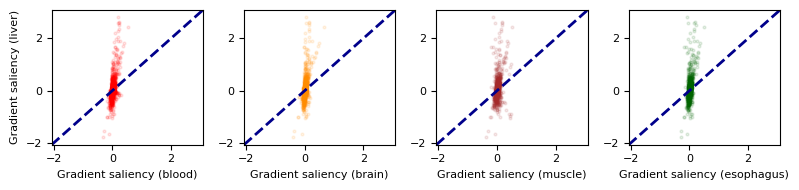

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.558)
brain (r = 0.532)
muscle (r = 0.363)
esophagus (r = 0.424)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


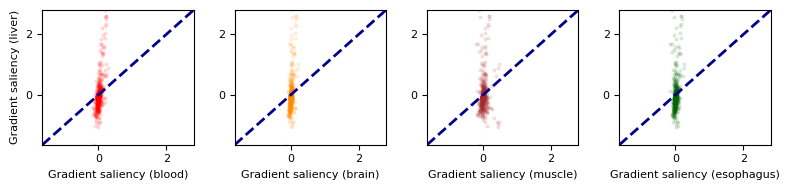

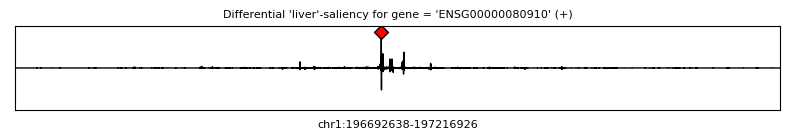

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 251085
 - max_pos (abs) = 196943723
 - chr1:196943627-196943819
blood


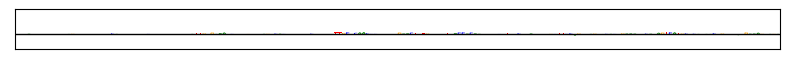

liver


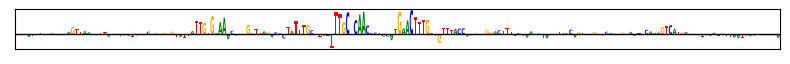

brain


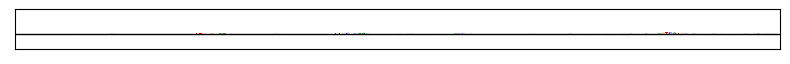

muscle


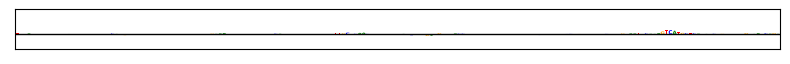

esophagus


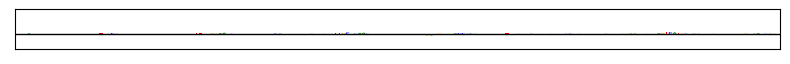

--------------------

-- Example = 3 --
 - ENSG00000157131(+)
 - chr1:56632838-57157126
 -- min_val = -0.7793
 -- max_val = 1.899
 - (Gradient score profiles per tissue) - 


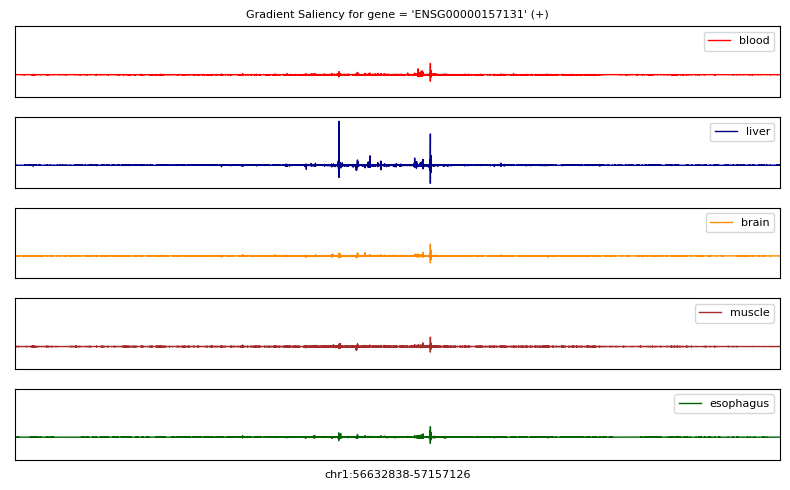

 - (Gradient score comparison against 'liver') - 
blood (r = 0.25)
brain (r = 0.125)
muscle (r = 0.214)
esophagus (r = 0.165)


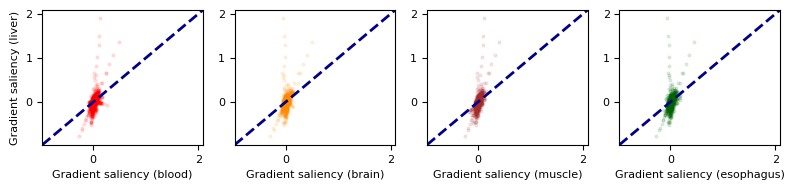

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.489)
brain (r = 0.093)
muscle (r = 0.47)
esophagus (r = 0.193)


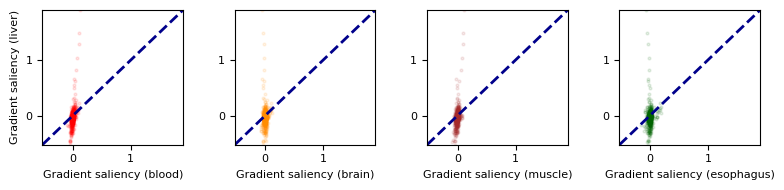

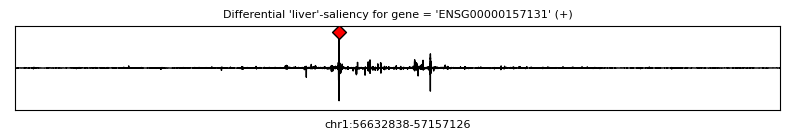

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 222139
 - max_pos (abs) = 56854977
 - chr1:56854881-56855073
blood


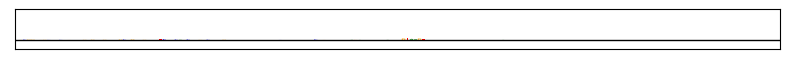

liver


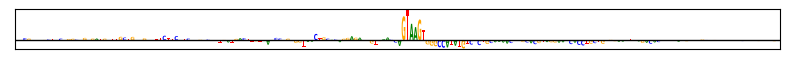

brain


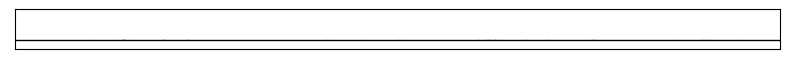

muscle


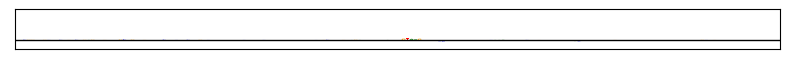

esophagus


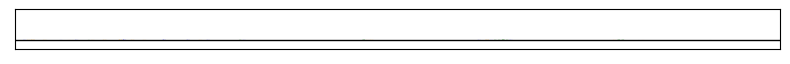

--------------------

-- Example = 4 --
 - ENSG00000101981(+)
 - chrX:139294935-139819223
 -- min_val = -1.933
 -- max_val = 2.762
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


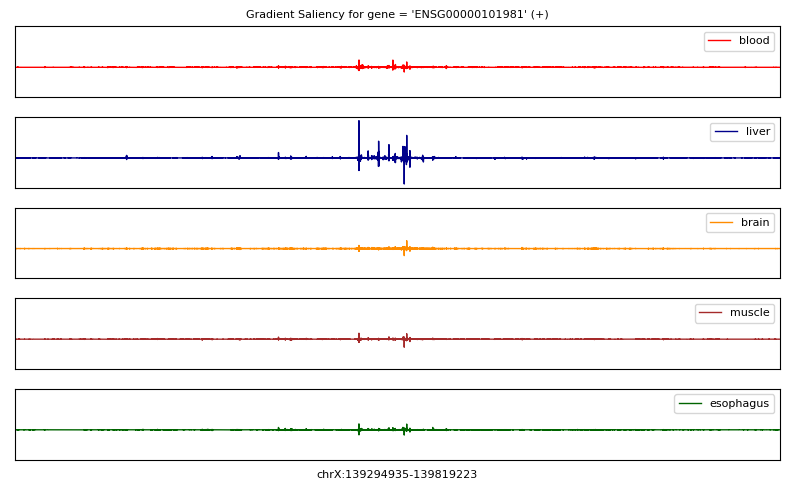

 - (Gradient score comparison against 'liver') - 
blood (r = 0.181)
brain (r = 0.156)
muscle (r = 0.269)
esophagus (r = 0.209)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


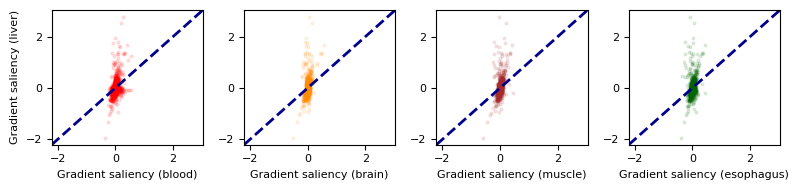

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.506)
brain (r = 0.441)
muscle (r = 0.52)
esophagus (r = 0.382)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


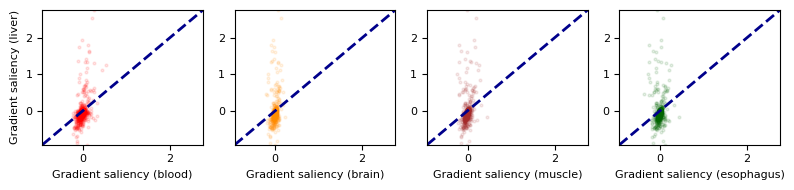

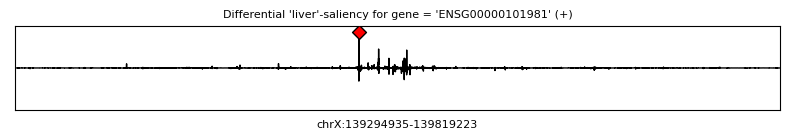

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 235778
 - max_pos (abs) = 139530713
 - chrX:139530617-139530809
blood


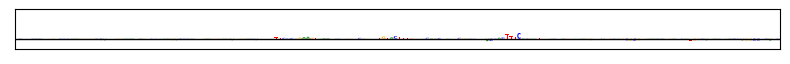

liver


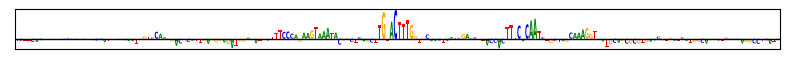

brain


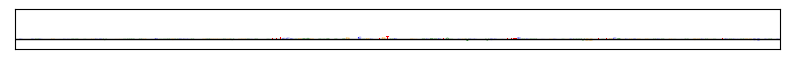

muscle


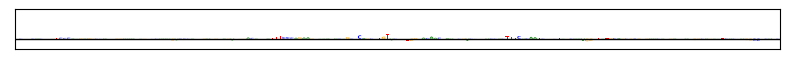

esophagus


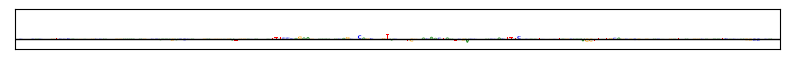

--------------------

-- Example = 5 --
 - ENSG00000101323(-)
 - chr20:7638968-8163256
 -- min_val = -2.324
 -- max_val = 2.3
 - (Gradient score profiles per tissue) - 


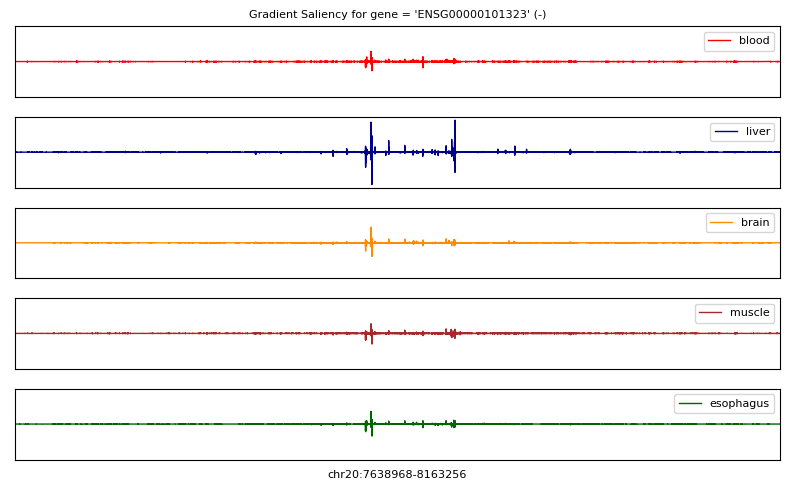

 - (Gradient score comparison against 'liver') - 
blood (r = 0.165)
brain (r = 0.137)
muscle (r = 0.191)
esophagus (r = 0.13)


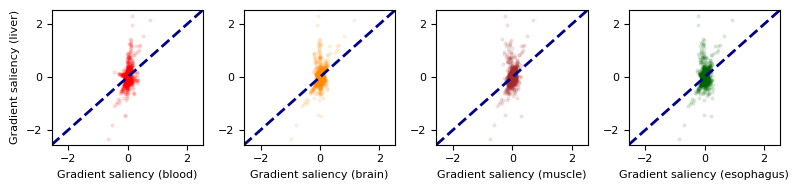

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.384)
brain (r = 0.029)
muscle (r = 0.143)
esophagus (r = -0.026)


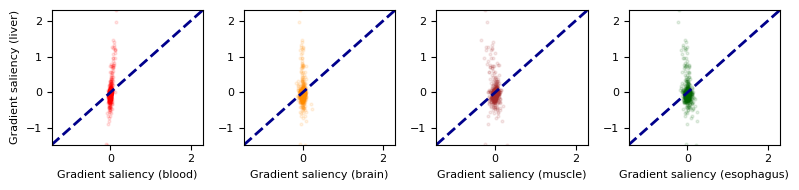

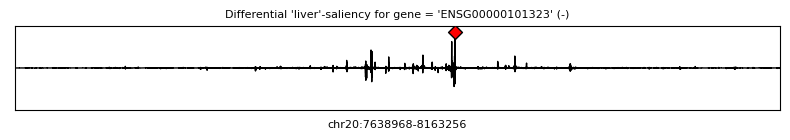

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 301569
 - max_pos (abs) = 7940537
 - chr20:7940441-7940633
blood


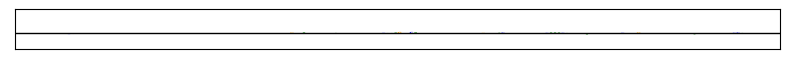

liver


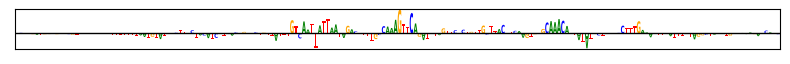

brain


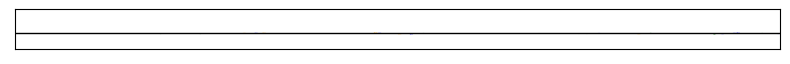

muscle


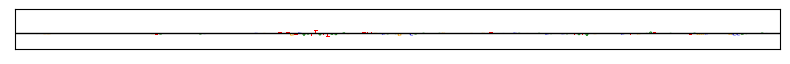

esophagus


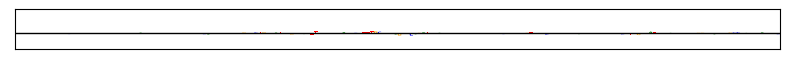

--------------------

-- Example = 6 --
 - ENSG00000163581(-)
 - chr3:170739849-171264137
 -- min_val = -0.9326
 -- max_val = 1.533
 - (Gradient score profiles per tissue) - 


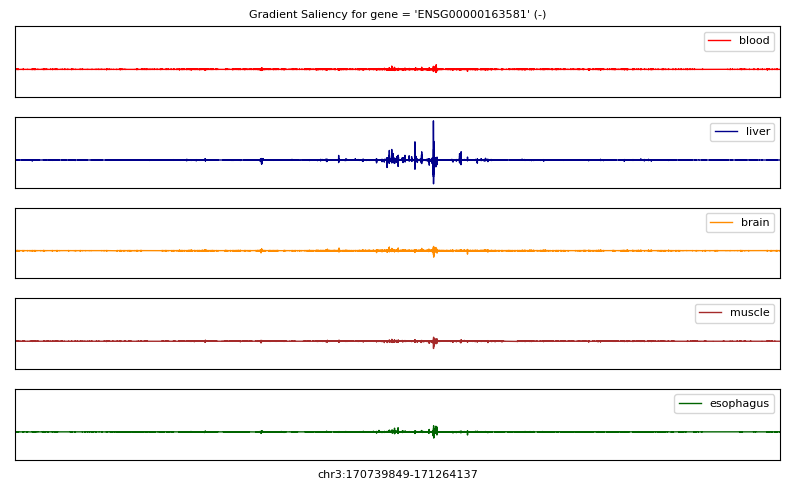

 - (Gradient score comparison against 'liver') - 
blood (r = -0.045)
brain (r = 0.002)
muscle (r = 0.167)
esophagus (r = -0.064)


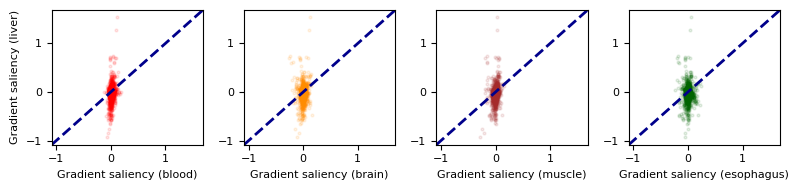

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.23)
brain (r = 0.036)
muscle (r = 0.27)
esophagus (r = 0.133)


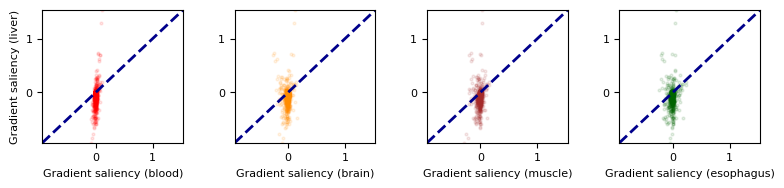

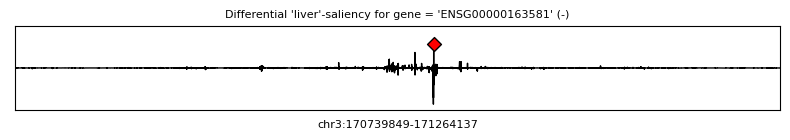

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 286983
 - max_pos (abs) = 171026832
 - chr3:171026736-171026928
blood


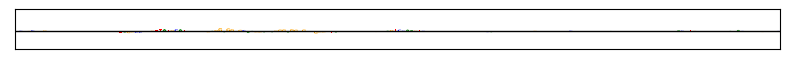

liver


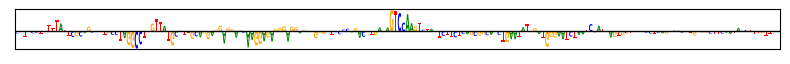

brain


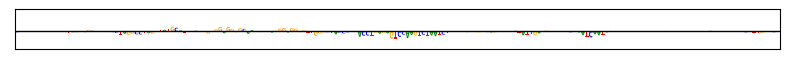

muscle


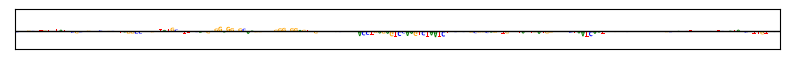

esophagus


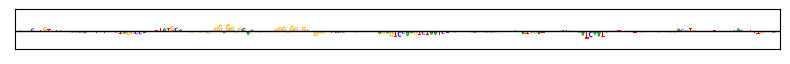

--------------------

-- Example = 7 --
 - ENSG00000178772(-)
 - chr3:194079380-194603668
 -- min_val = -1.134
 -- max_val = 2.049
 - (Gradient score profiles per tissue) - 


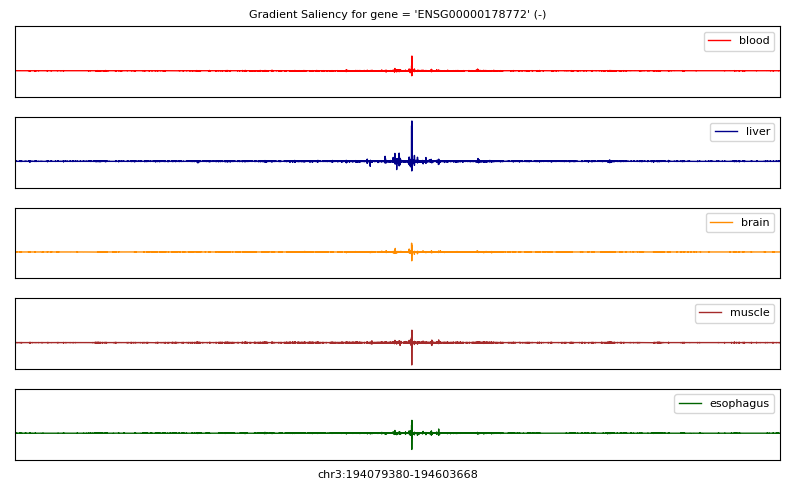

 - (Gradient score comparison against 'liver') - 
blood (r = 0.042)
brain (r = 0.019)
muscle (r = 0.093)
esophagus (r = -0.016)


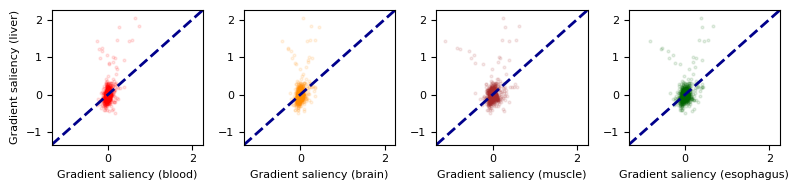

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.277)
brain (r = 0.249)
muscle (r = 0.219)
esophagus (r = 0.237)


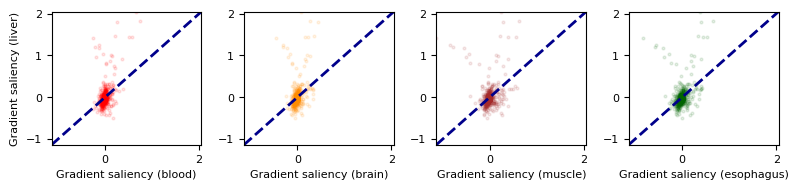

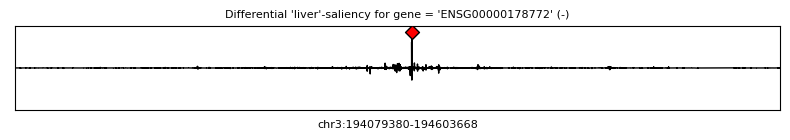

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 271965
 - max_pos (abs) = 194351345
 - chr3:194351249-194351441
blood


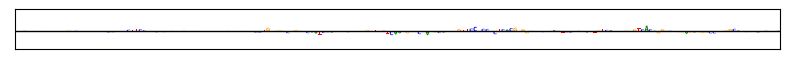

liver


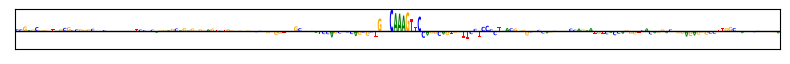

brain


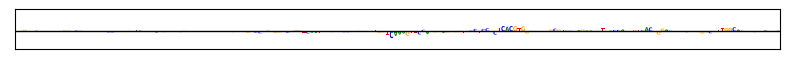

muscle


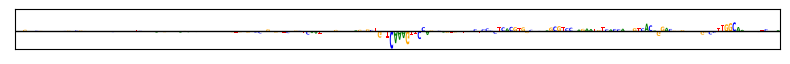

esophagus


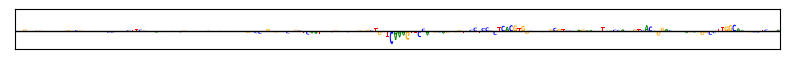

--------------------

-- Example = 8 --
 - ENSG00000171234(+)
 - chr4:68841539-69365827
 -- min_val = -1.487
 -- max_val = 2.455
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


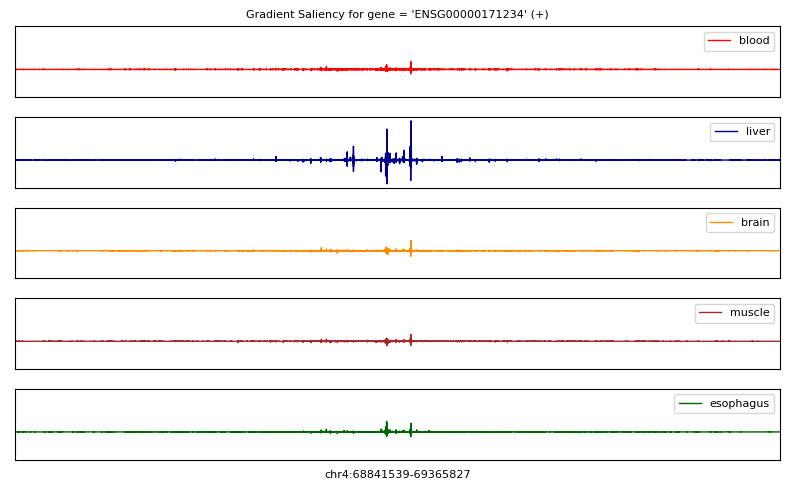

 - (Gradient score comparison against 'liver') - 
blood (r = 0.161)
brain (r = 0.186)
muscle (r = 0.278)
esophagus (r = 0.105)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


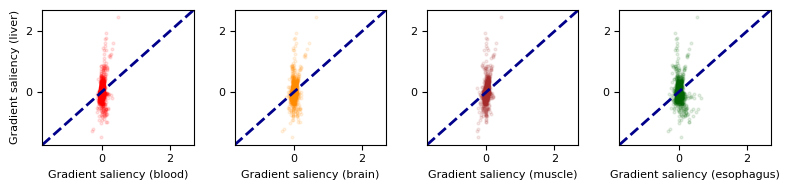

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.336)
brain (r = 0.23)
muscle (r = 0.404)
esophagus (r = -0.046)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


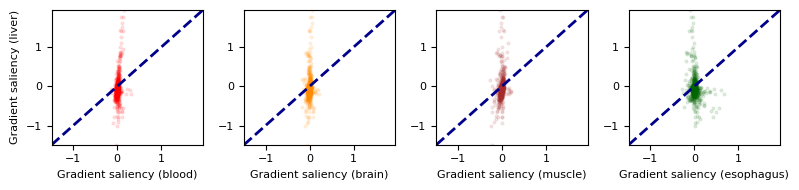

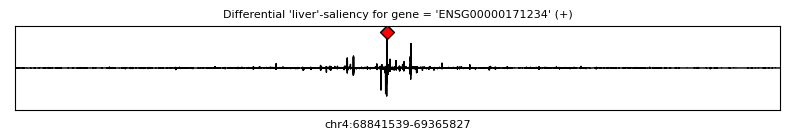

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 254893
 - max_pos (abs) = 69096432
 - chr4:69096336-69096528
blood


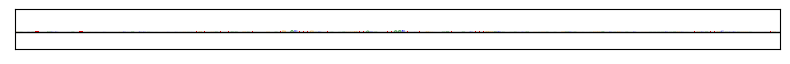

liver


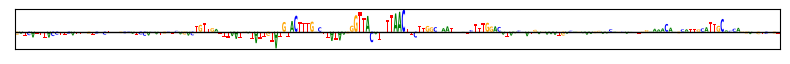

brain


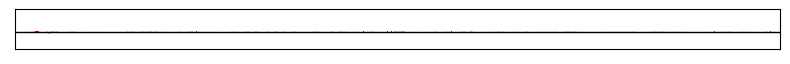

muscle


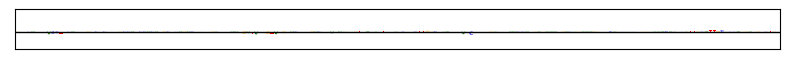

esophagus


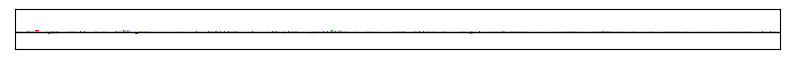

--------------------

-- Example = 9 --
 - ENSG00000142484(+)
 - chr17:4517235-5041523
 -- min_val = -1.412
 -- max_val = 6.375
 - (Gradient score profiles per tissue) - 


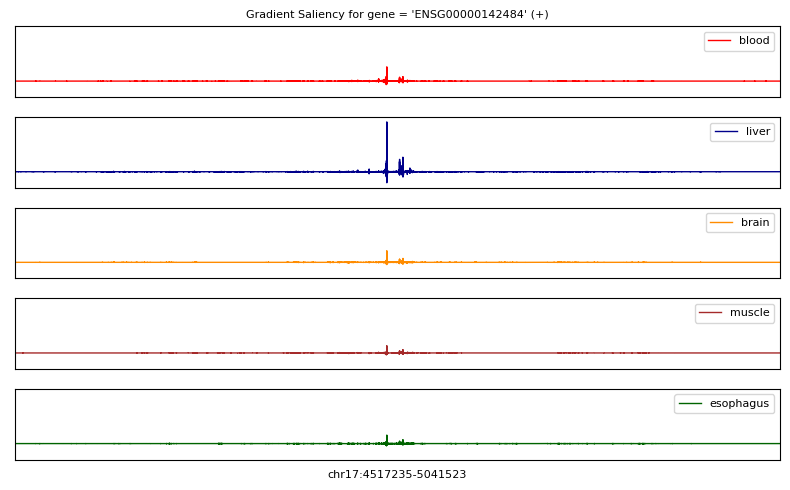

 - (Gradient score comparison against 'liver') - 
blood (r = 0.194)
brain (r = 0.318)
muscle (r = 0.267)
esophagus (r = 0.149)


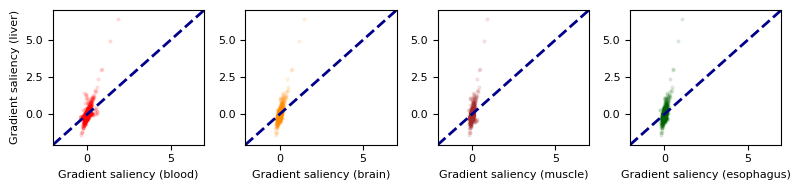

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.665)
brain (r = 0.602)
muscle (r = 0.393)
esophagus (r = 0.532)


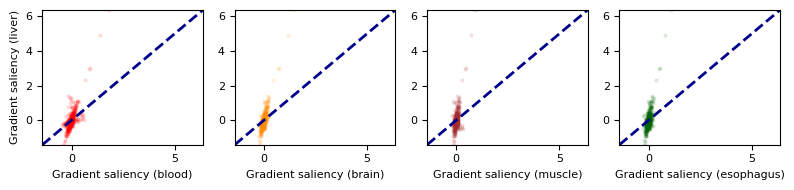

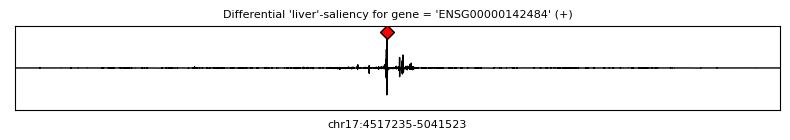

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 254863
 - max_pos (abs) = 4772098
 - chr17:4772002-4772194
blood


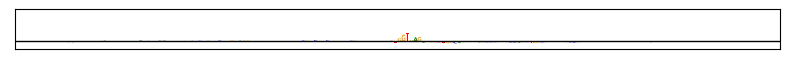

liver


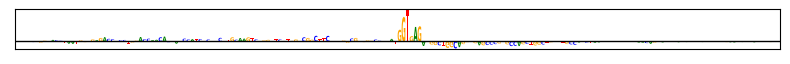

brain


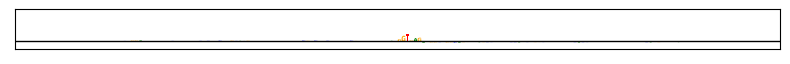

muscle


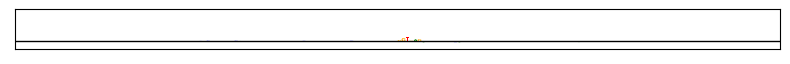

esophagus


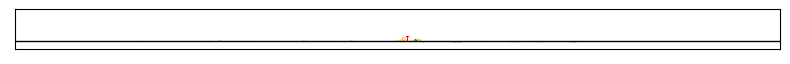

--------------------

-- Example = 10 --
 - ENSG00000109181(+)
 - chr4:68563525-69087813
 -- min_val = -1.422
 -- max_val = 1.768
 - (Gradient score profiles per tissue) - 


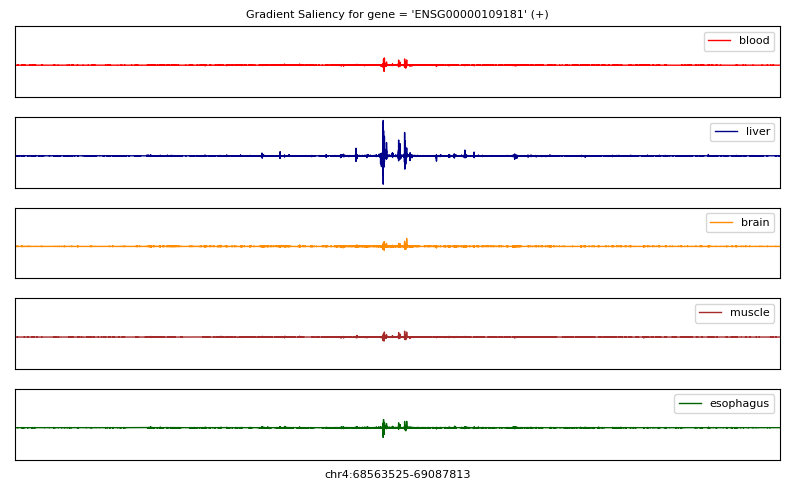

 - (Gradient score comparison against 'liver') - 
blood (r = 0.226)
brain (r = 0.282)
muscle (r = 0.339)
esophagus (r = 0.196)


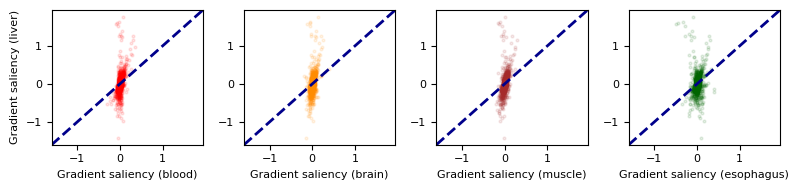

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.363)
brain (r = 0.467)
muscle (r = 0.534)
esophagus (r = 0.088)


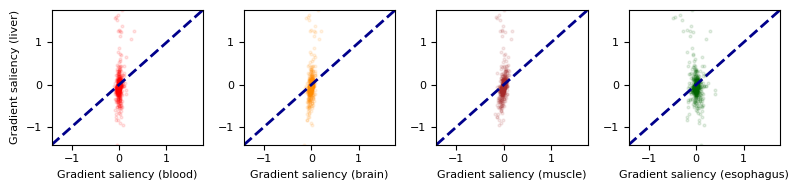

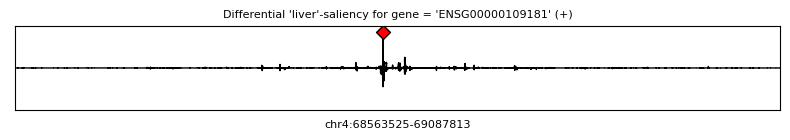

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 252342
 - max_pos (abs) = 68815867
 - chr4:68815771-68815963
blood


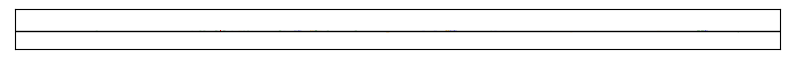

liver


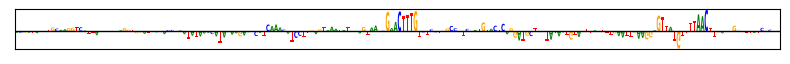

brain


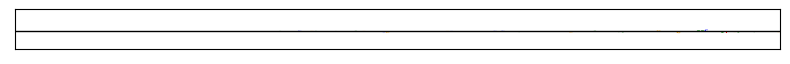

muscle


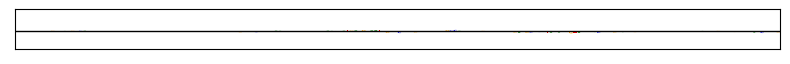

esophagus


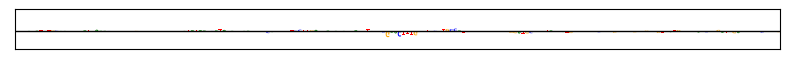

--------------------

-- Example = 11 --
 - ENSG00000197408(+)
 - chr19:40750455-41274743
 -- min_val = -1.869
 -- max_val = 2.172
 - (Gradient score profiles per tissue) - 


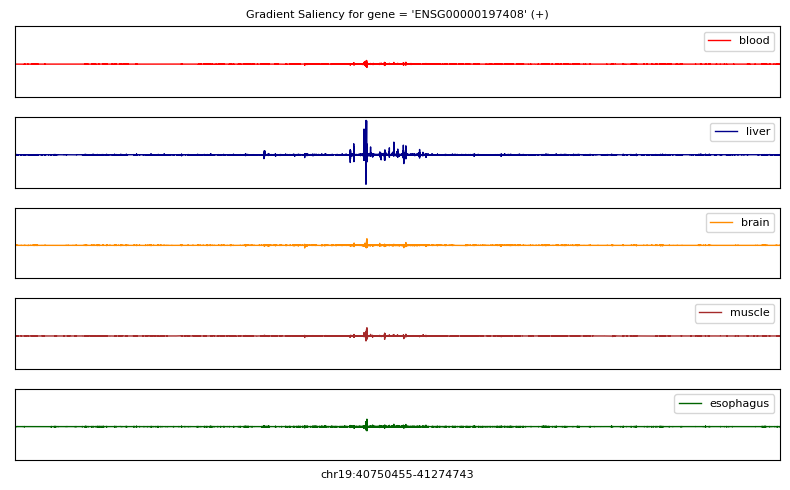

 - (Gradient score comparison against 'liver') - 
blood (r = 0.112)
brain (r = 0.171)
muscle (r = 0.328)
esophagus (r = 0.078)


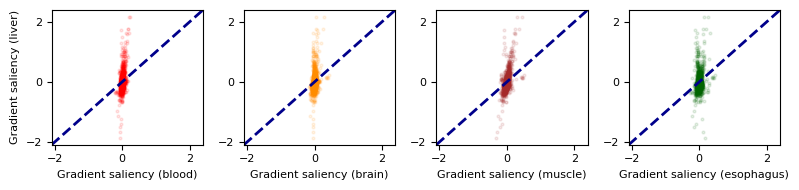

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.484)
brain (r = 0.455)
muscle (r = 0.765)
esophagus (r = 0.33)


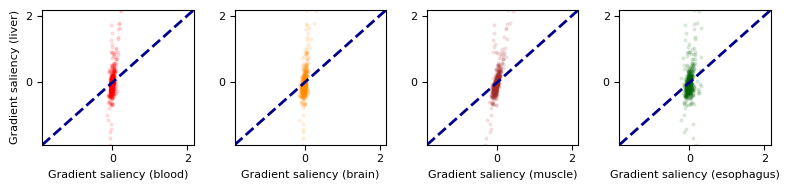

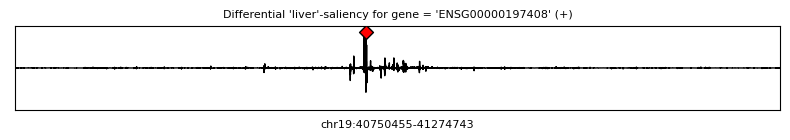

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 240673
 - max_pos (abs) = 40991128
 - chr19:40991032-40991224
blood


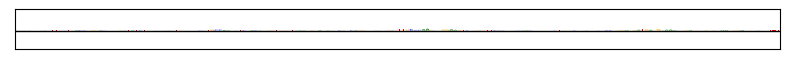

liver


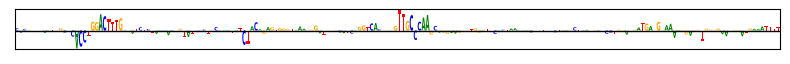

brain


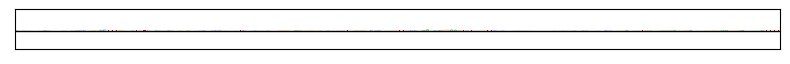

muscle


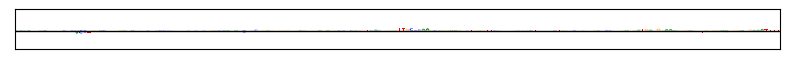

esophagus


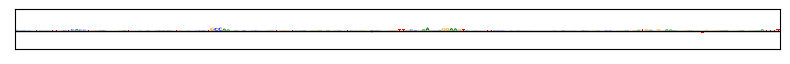

--------------------

-- Example = 12 --
 - ENSG00000100665(+)
 - chr14:94304347-94828635
 -- min_val = -1.159
 -- max_val = 2.885
 - (Gradient score profiles per tissue) - 


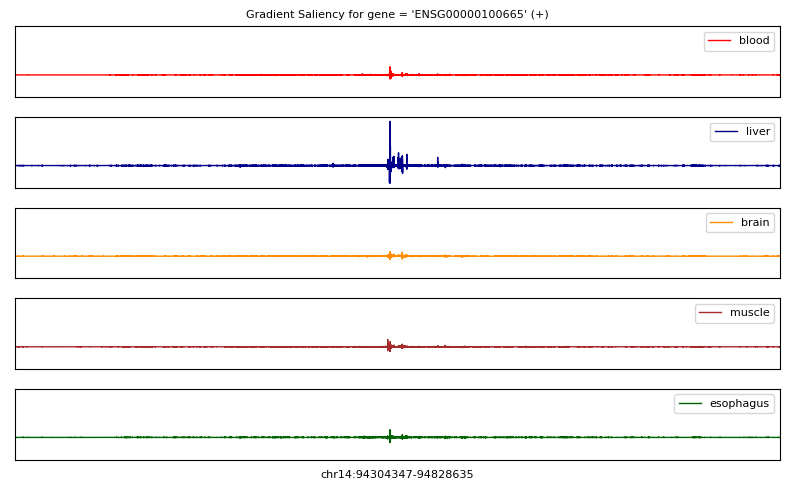

 - (Gradient score comparison against 'liver') - 
blood (r = 0.143)
brain (r = 0.13)
muscle (r = 0.17)
esophagus (r = 0.092)


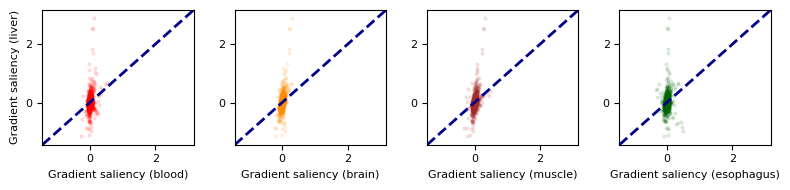

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.213)
brain (r = 0.406)
muscle (r = 0.513)
esophagus (r = 0.053)


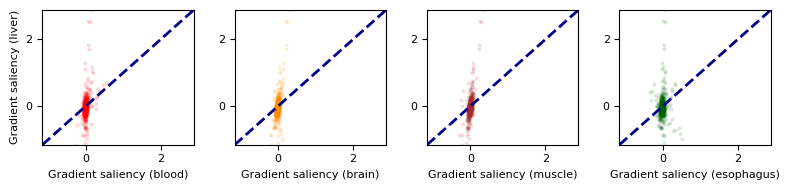

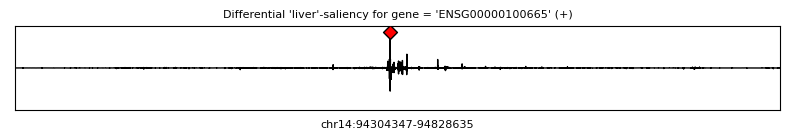

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 257147
 - max_pos (abs) = 94561494
 - chr14:94561398-94561590
blood


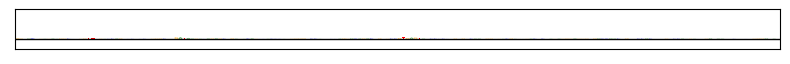

liver


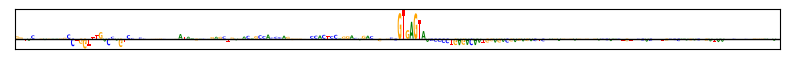

brain


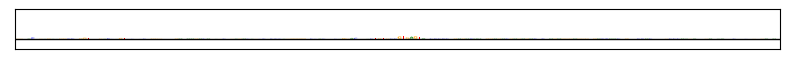

muscle


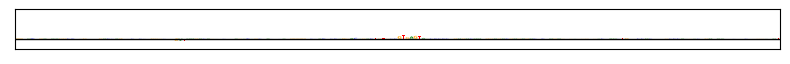

esophagus


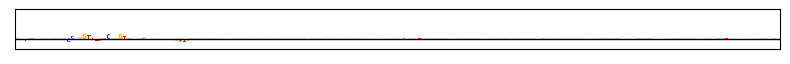

--------------------

-- Example = 13 --
 - ENSG00000170099(-)
 - chr14:94048593-94572881
 -- min_val = -0.935
 -- max_val = 1.286
 - (Gradient score profiles per tissue) - 


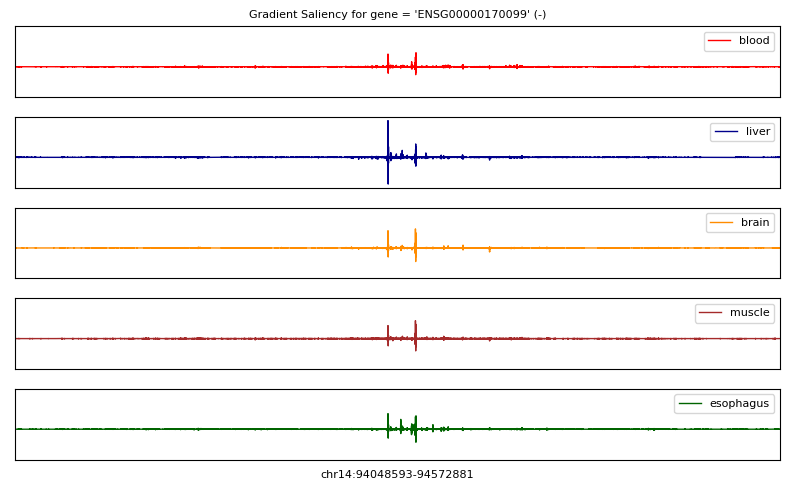

 - (Gradient score comparison against 'liver') - 
blood (r = 0.08)
brain (r = 0.202)
muscle (r = 0.255)
esophagus (r = 0.081)


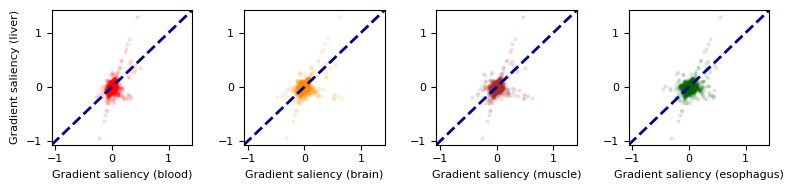

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.852)
brain (r = 0.92)
muscle (r = 0.92)
esophagus (r = 0.908)


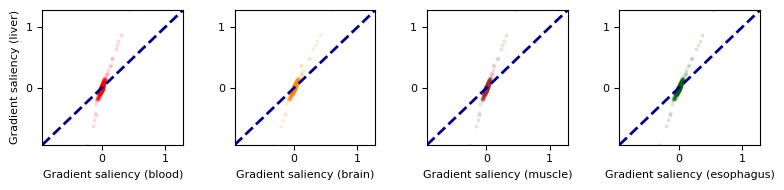

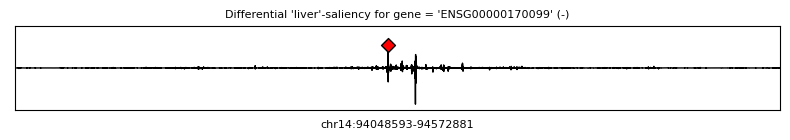

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 255672
 - max_pos (abs) = 94304265
 - chr14:94304169-94304361
blood


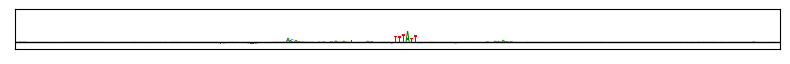

liver


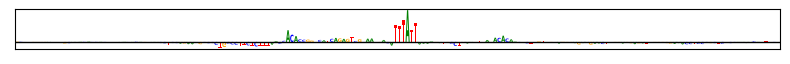

brain


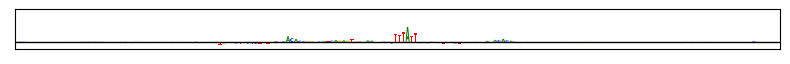

muscle


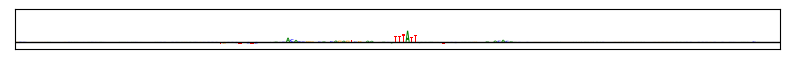

esophagus


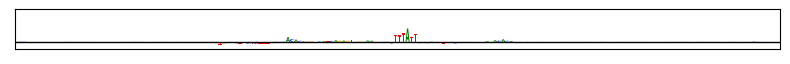

--------------------

-- Example = 14 --
 - ENSG00000131482(+)
 - chr17:42649212-43173500
 -- min_val = -0.2615
 -- max_val = 0.6655
 - (Gradient score profiles per tissue) - 


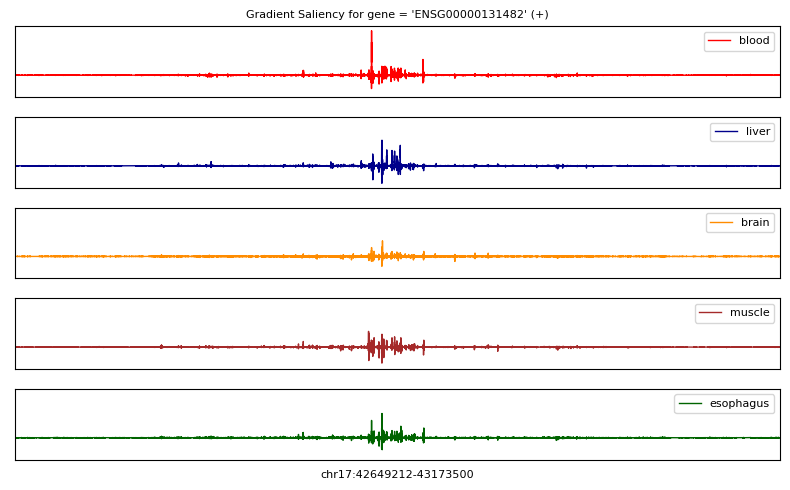

 - (Gradient score comparison against 'liver') - 
blood (r = -0.005)
brain (r = 0.058)
muscle (r = 0.125)
esophagus (r = -0.029)


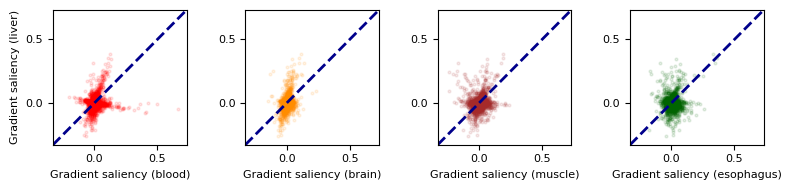

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.343)
brain (r = 0.502)
muscle (r = 0.292)
esophagus (r = -0.035)


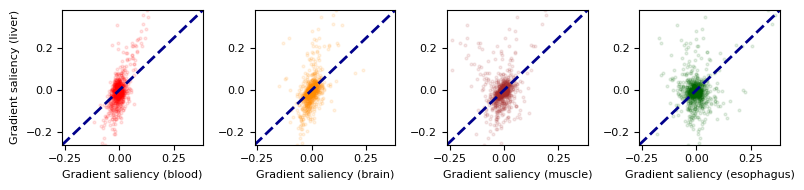

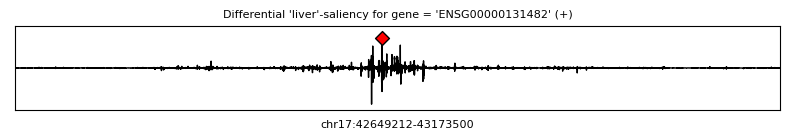

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 251513
 - max_pos (abs) = 42900725
 - chr17:42900629-42900821
blood


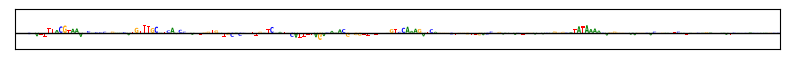

liver


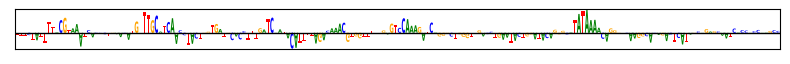

brain


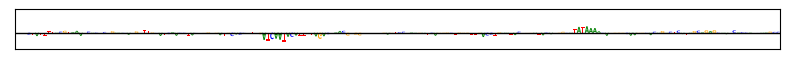

muscle


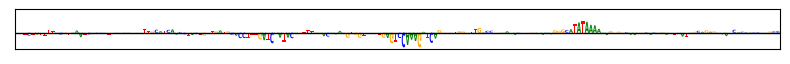

esophagus


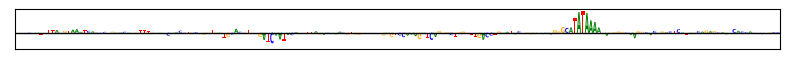

--------------------

-- Example = 15 --
 - ENSG00000110243(-)
 - chr11:116528215-117052503
 -- min_val = -0.9536
 -- max_val = 1.834
 - (Gradient score profiles per tissue) - 


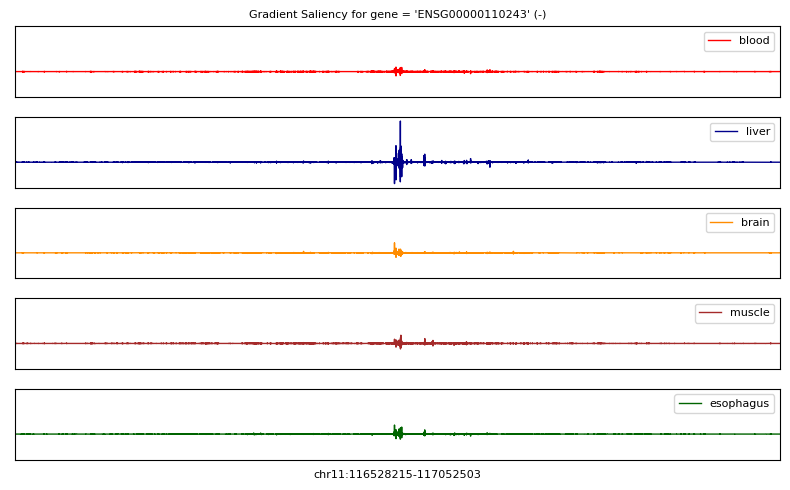

 - (Gradient score comparison against 'liver') - 
blood (r = 0.081)
brain (r = 0.15)
muscle (r = 0.198)
esophagus (r = 0.097)


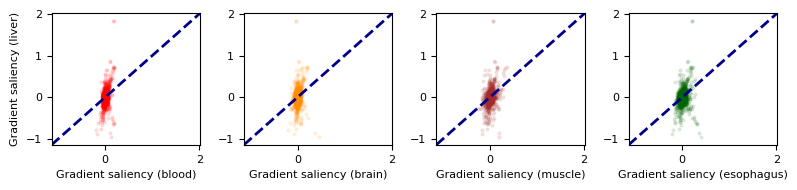

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.558)
brain (r = 0.629)
muscle (r = 0.637)
esophagus (r = 0.567)


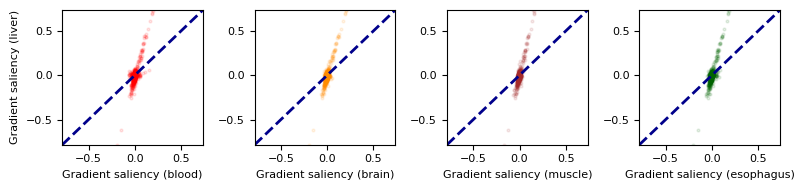

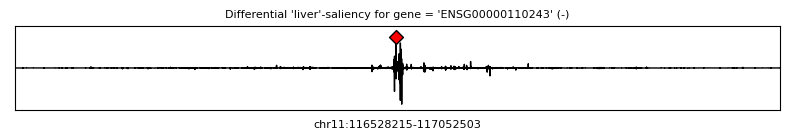

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 261139
 - max_pos (abs) = 116789354
 - chr11:116789258-116789450
blood


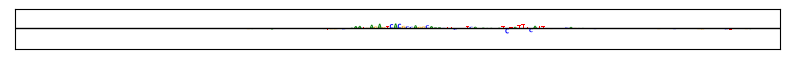

liver


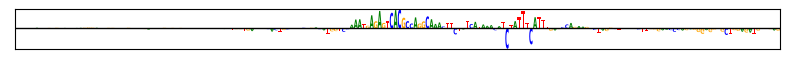

brain


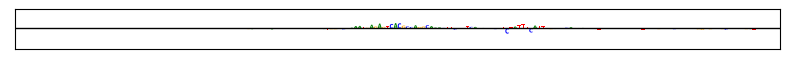

muscle


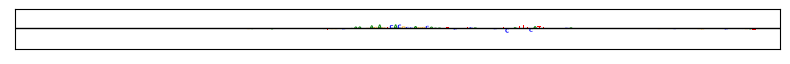

esophagus


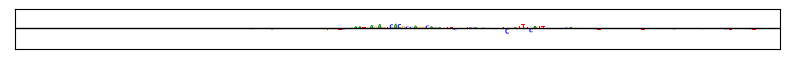

--------------------

-- Example = 16 --
 - ENSG00000021852(-)
 - chr1:56683758-57208046
 -- min_val = -0.3752
 -- max_val = 0.539
 - (Gradient score profiles per tissue) - 


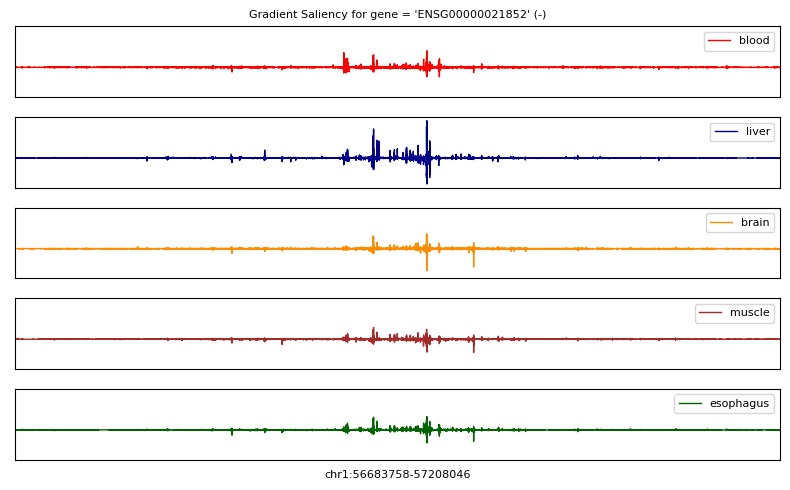

 - (Gradient score comparison against 'liver') - 
blood (r = 0.229)
brain (r = 0.112)
muscle (r = 0.184)
esophagus (r = 0.138)


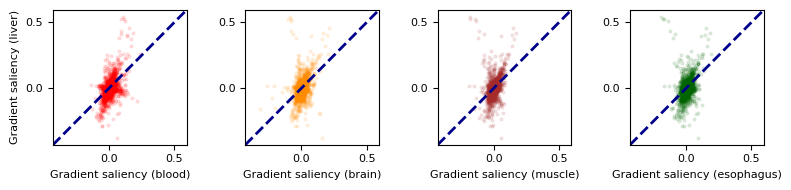

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.513)
brain (r = 0.42)
muscle (r = 0.44)
esophagus (r = 0.402)


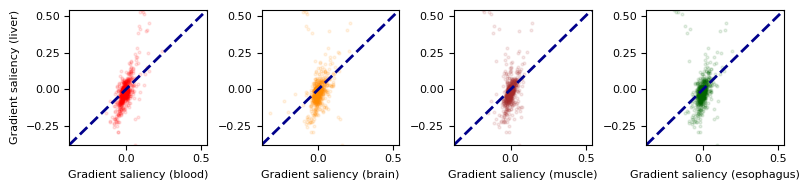

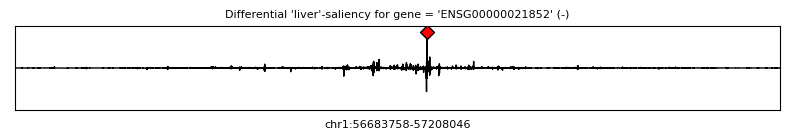

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 282331
 - max_pos (abs) = 56966089
 - chr1:56965993-56966185
blood


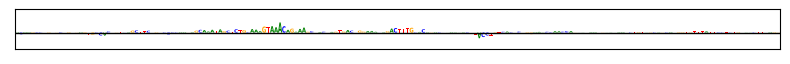

liver


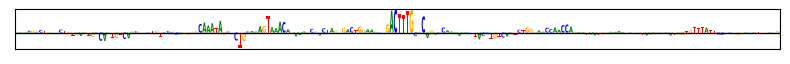

brain


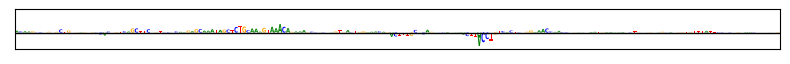

muscle


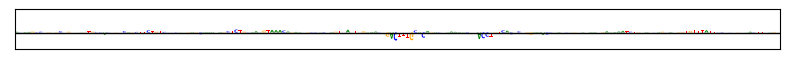

esophagus


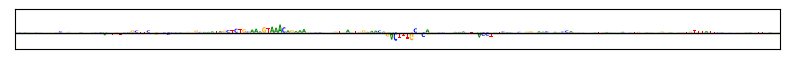

--------------------

-- Example = 17 --
 - ENSG00000267467(+)
 - chr19:44682483-45206771
 -- min_val = -1.203
 -- max_val = 5.3
 - (Gradient score profiles per tissue) - 


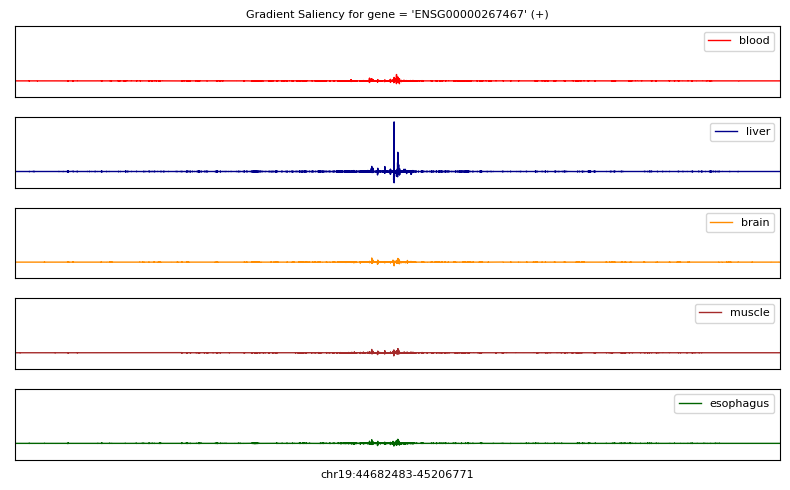

 - (Gradient score comparison against 'liver') - 
blood (r = 0.148)
brain (r = 0.215)
muscle (r = 0.284)
esophagus (r = 0.25)


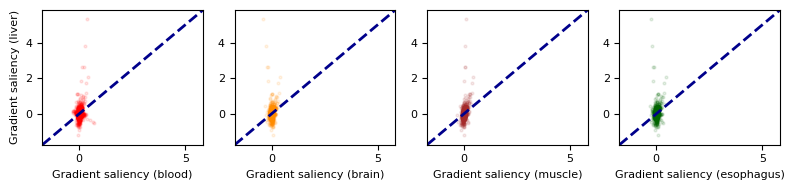

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.103)
brain (r = -0.325)
muscle (r = 0.195)
esophagus (r = -0.126)


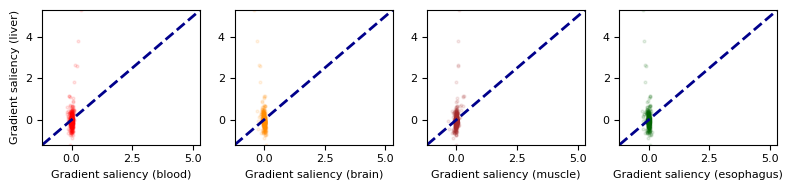

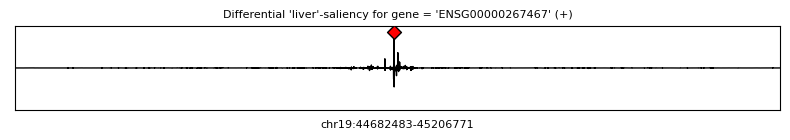

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 259868
 - max_pos (abs) = 44942351
 - chr19:44942255-44942447
blood


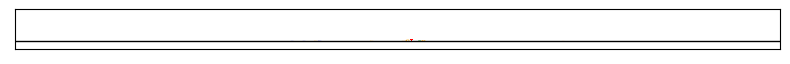

liver


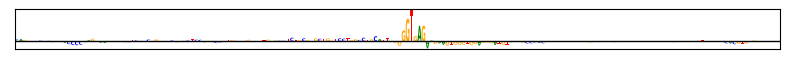

brain


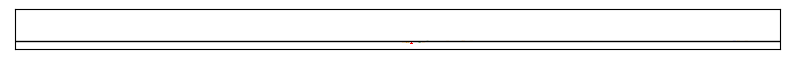

muscle


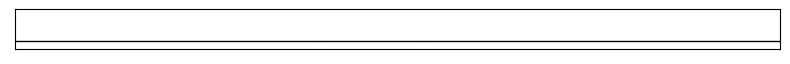

esophagus


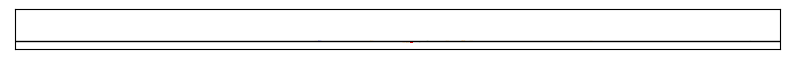

--------------------

-- Example = 18 --
 - ENSG00000196620(-)
 - chr4:68396658-68920946
 -- min_val = -0.6387
 -- max_val = 1.275
 - (Gradient score profiles per tissue) - 


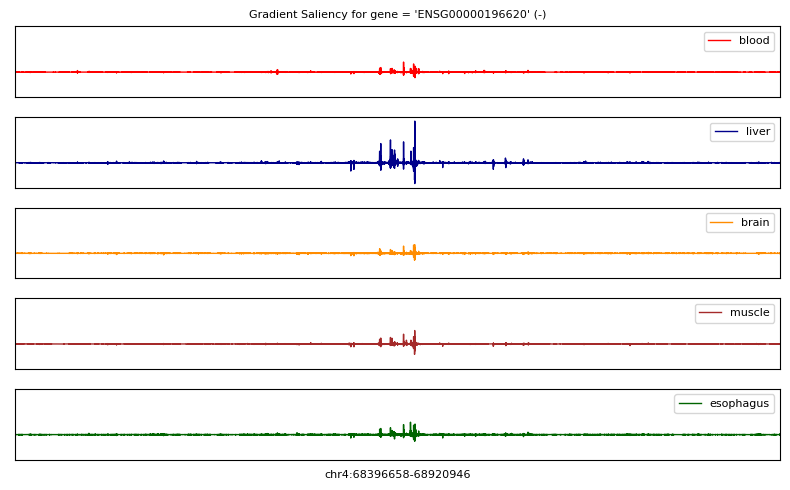

 - (Gradient score comparison against 'liver') - 
blood (r = 0.175)
brain (r = 0.19)
muscle (r = 0.308)
esophagus (r = 0.138)


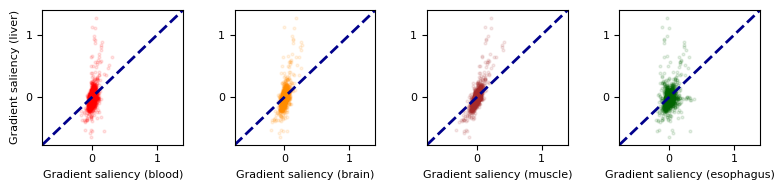

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.249)
brain (r = 0.421)
muscle (r = 0.721)
esophagus (r = 0.089)


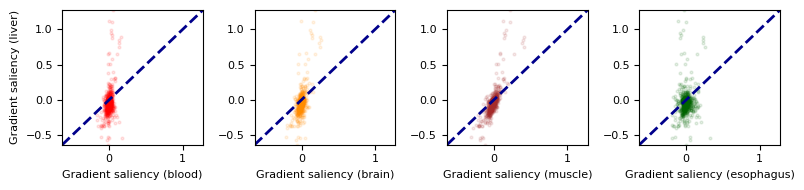

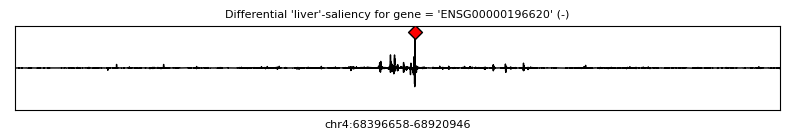

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 274043
 - max_pos (abs) = 68670701
 - chr4:68670605-68670797
blood


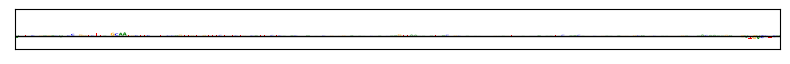

liver


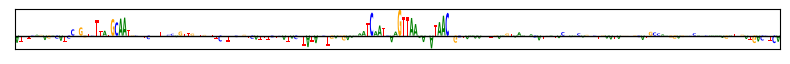

brain


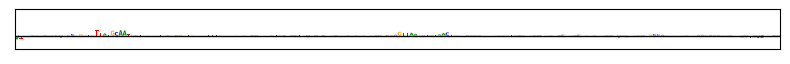

muscle


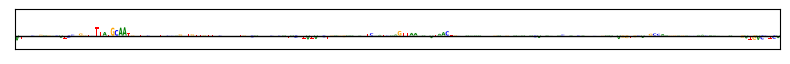

esophagus


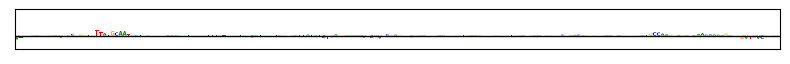

--------------------

-- Example = 19 --
 - ENSG00000138109(+)
 - chr10:94710566-95234854
 -- min_val = -1.682
 -- max_val = 1.944
 - (Gradient score profiles per tissue) - 


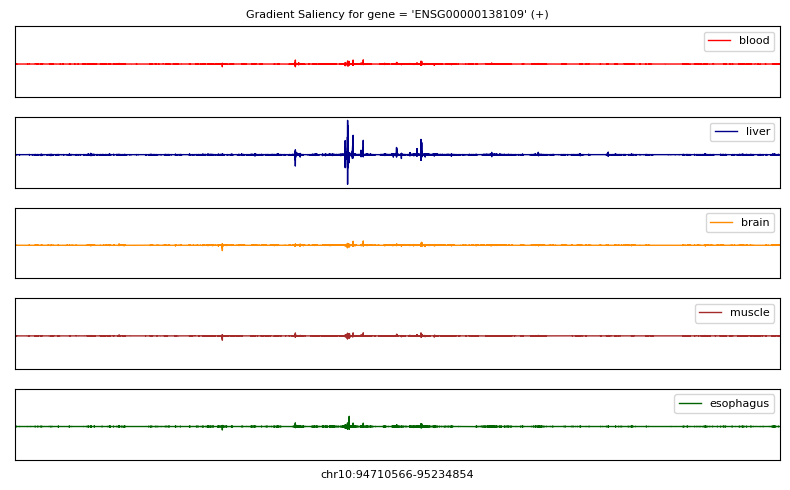

 - (Gradient score comparison against 'liver') - 
blood (r = 0.16)
brain (r = 0.095)
muscle (r = 0.236)
esophagus (r = 0.114)


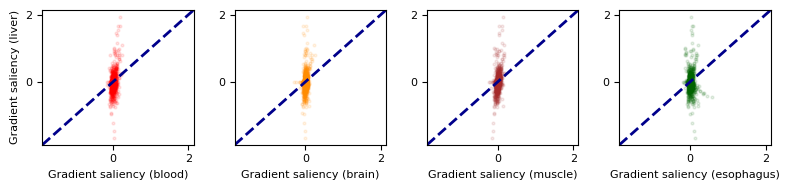

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.554)
brain (r = 0.315)
muscle (r = 0.435)
esophagus (r = 0.176)


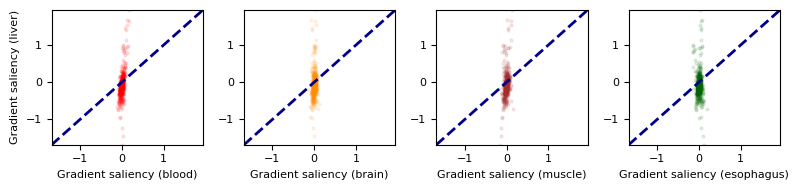

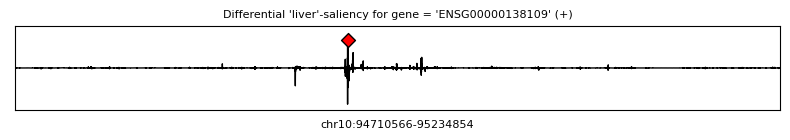

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 228063
 - max_pos (abs) = 94938629
 - chr10:94938533-94938725
blood


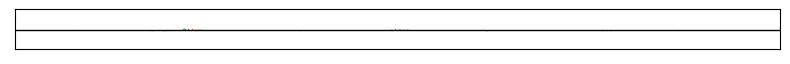

liver


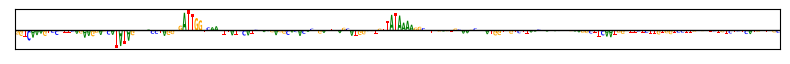

brain


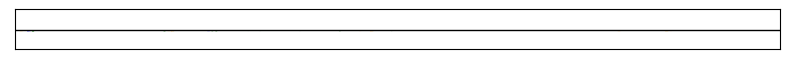

muscle


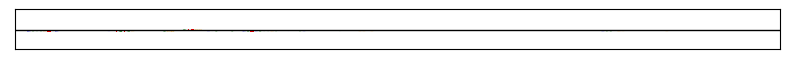

esophagus


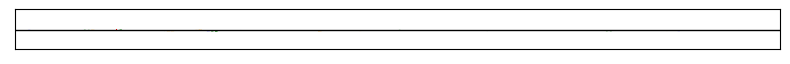

--------------------

-- Example = 20 --
 - ENSG00000132703(+)
 - chr1:159326238-159850526
 -- min_val = -1.025
 -- max_val = 2.195
 - (Gradient score profiles per tissue) - 


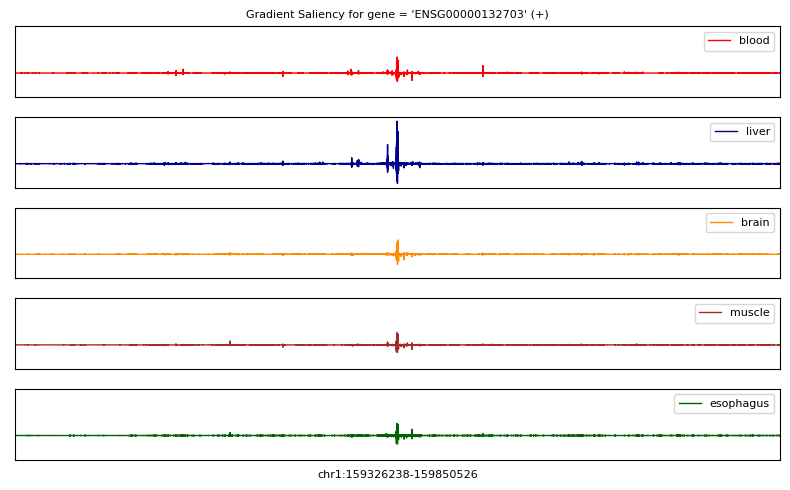

 - (Gradient score comparison against 'liver') - 
blood (r = 0.168)
brain (r = 0.195)
muscle (r = 0.322)
esophagus (r = 0.218)


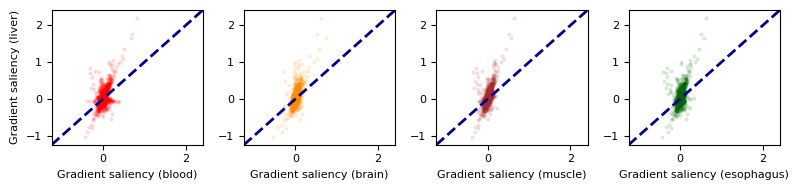

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.903)
brain (r = 0.858)
muscle (r = 0.908)
esophagus (r = 0.865)


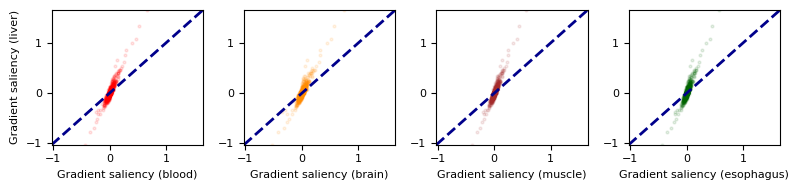

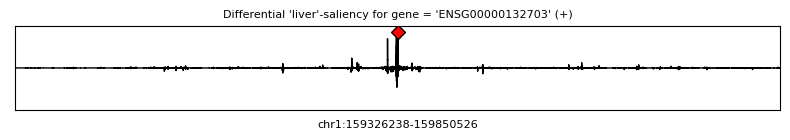

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 262601
 - max_pos (abs) = 159588839
 - chr1:159588743-159588935
blood


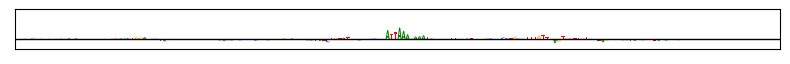

liver


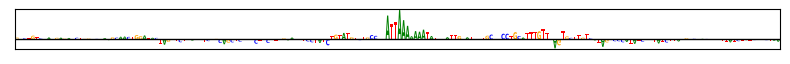

brain


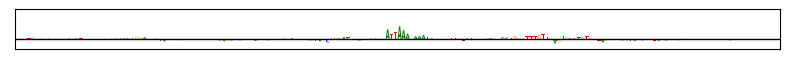

muscle


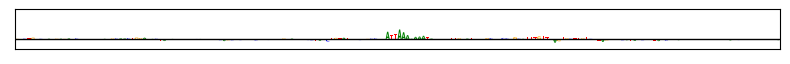

esophagus


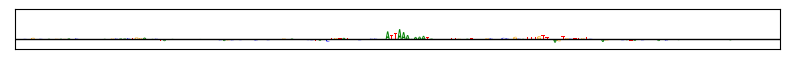

--------------------

-- Example = 21 --
 - ENSG00000113600(-)
 - chr5:39044239-39568527
 -- min_val = -2.303
 -- max_val = 3.012
 - (Gradient score profiles per tissue) - 


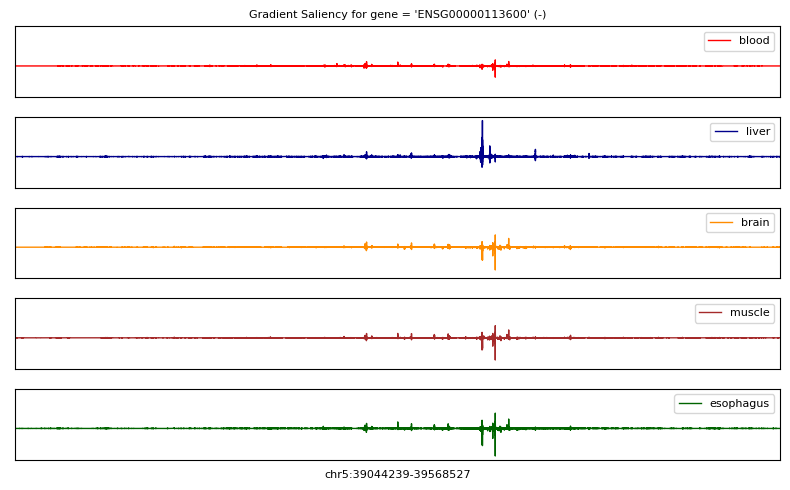

 - (Gradient score comparison against 'liver') - 
blood (r = 0.265)
brain (r = 0.278)
muscle (r = 0.29)
esophagus (r = 0.215)


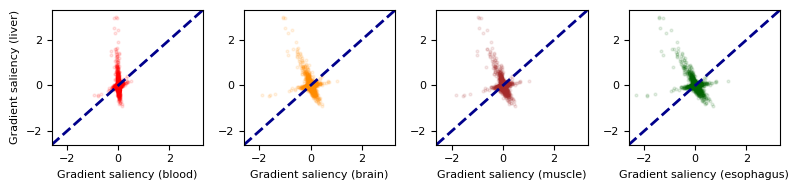

 - (Differential gradient score of liver against 'mean') -
blood (r = -0.562)
brain (r = -0.862)
muscle (r = -0.88)
esophagus (r = -0.896)


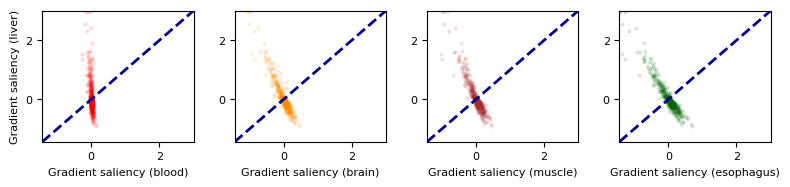

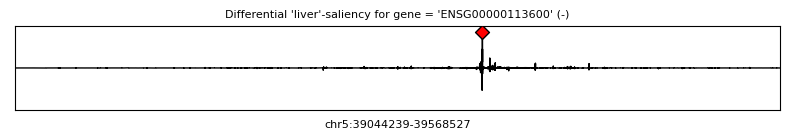

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 320367
 - max_pos (abs) = 39364606
 - chr5:39364510-39364702
blood


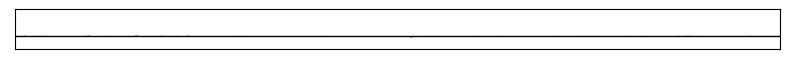

liver


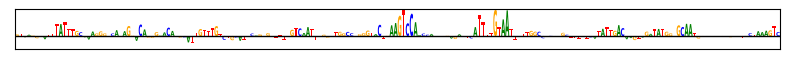

brain


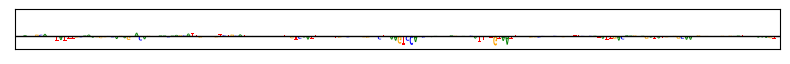

muscle


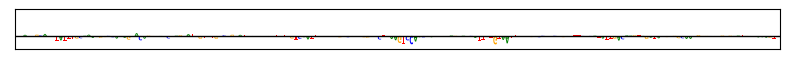

esophagus


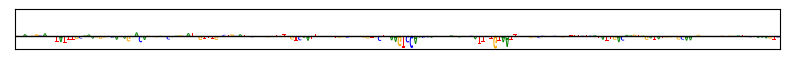

--------------------

-- Example = 22 --
 - ENSG00000072080(+)
 - chr2:233801615-234325903
 -- min_val = -3.252
 -- max_val = 3.344
 - (Gradient score profiles per tissue) - 


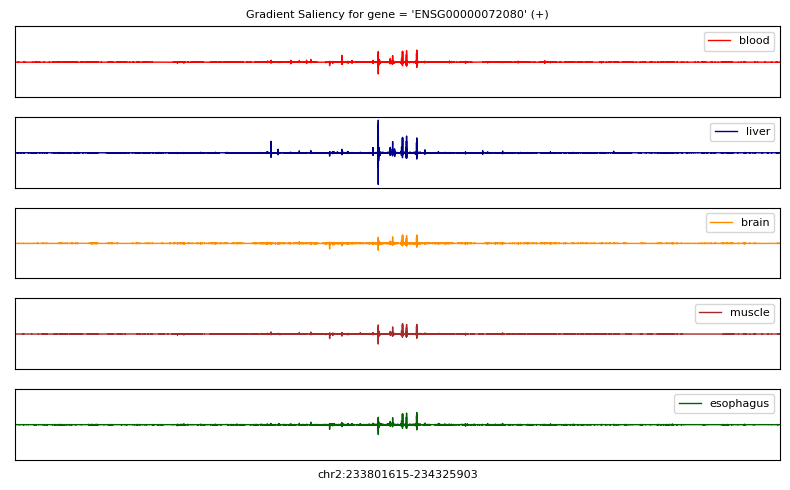

 - (Gradient score comparison against 'liver') - 
blood (r = 0.722)
brain (r = 0.596)
muscle (r = 0.697)
esophagus (r = 0.713)


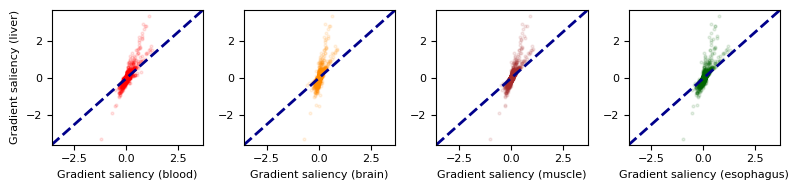

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.954)
brain (r = 0.823)
muscle (r = 0.928)
esophagus (r = 0.896)


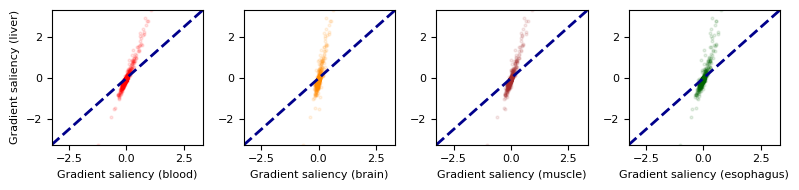

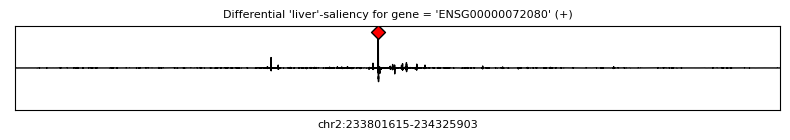

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 249026
 - max_pos (abs) = 234050641
 - chr2:234050545-234050737
blood


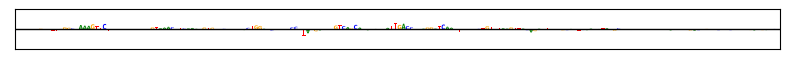

liver


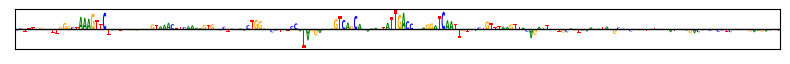

brain


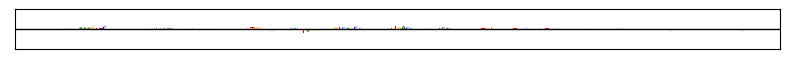

muscle


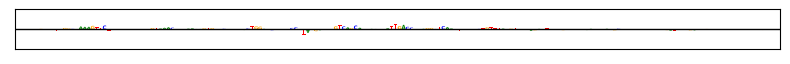

esophagus


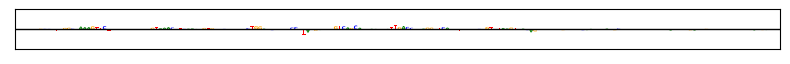

--------------------

-- Example = 23 --
 - ENSG00000175336(-)
 - chr12:56099336-56623624
 -- min_val = -1.742
 -- max_val = 4.312
 - (Gradient score profiles per tissue) - 


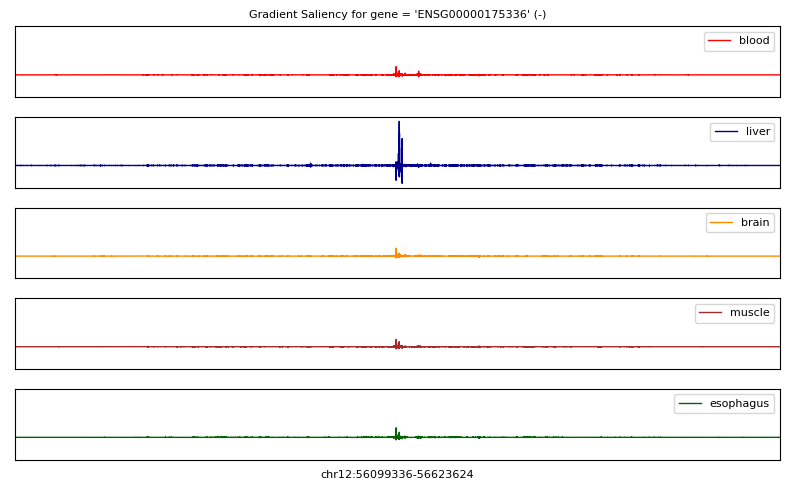

 - (Gradient score comparison against 'liver') - 
blood (r = 0.154)
brain (r = 0.239)
muscle (r = 0.288)
esophagus (r = 0.195)


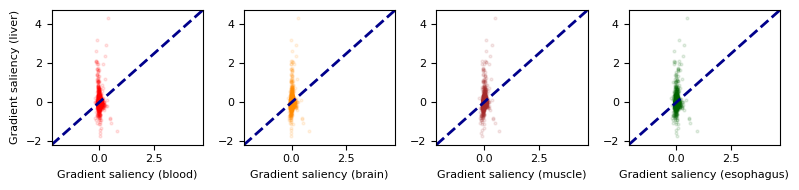

 - (Differential gradient score of liver against 'mean') -
blood (r = -0.011)
brain (r = 0.237)
muscle (r = 0.431)
esophagus (r = 0.305)


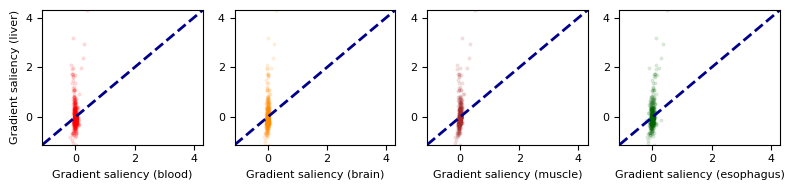

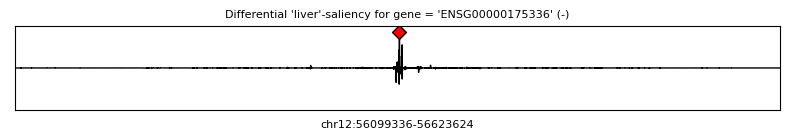

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 263530
 - max_pos (abs) = 56362866
 - chr12:56362770-56362962
blood


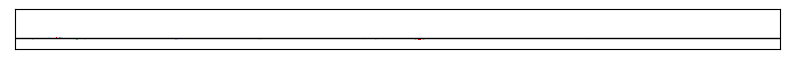

liver


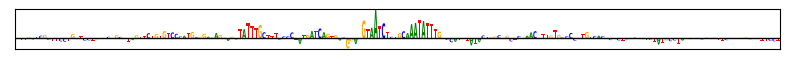

brain


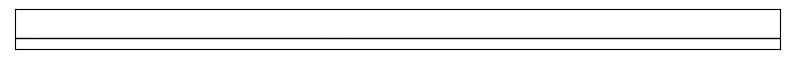

muscle


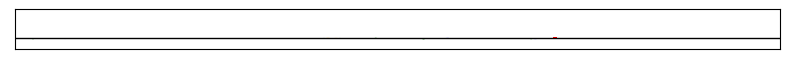

esophagus


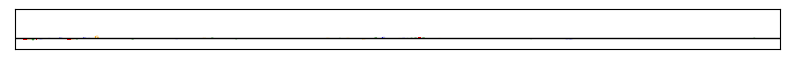

--------------------

-- Example = 24 --
 - ENSG00000244067(-)
 - chr6:52490494-53014782
 -- min_val = -1.467
 -- max_val = 2.17
 - (Gradient score profiles per tissue) - 


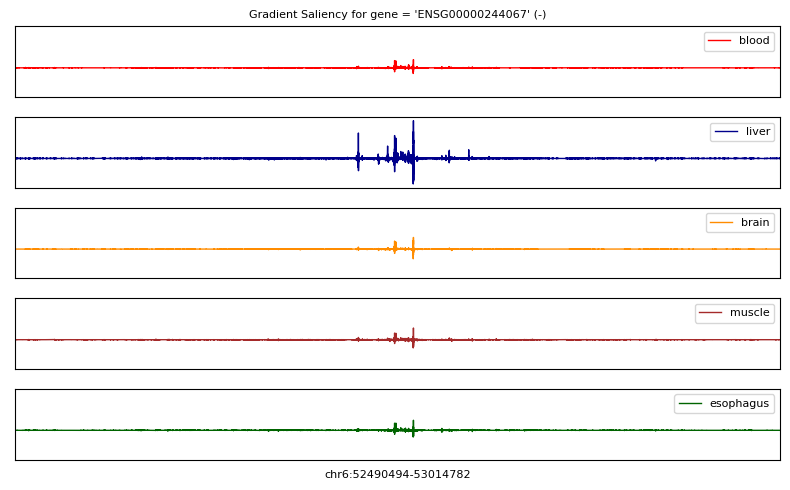

 - (Gradient score comparison against 'liver') - 
blood (r = 0.2)
brain (r = 0.333)
muscle (r = 0.302)
esophagus (r = 0.156)


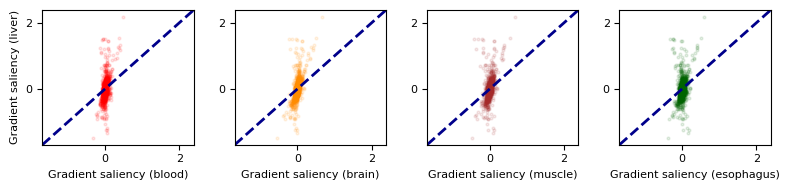

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.447)
brain (r = 0.653)
muscle (r = 0.547)
esophagus (r = 0.402)


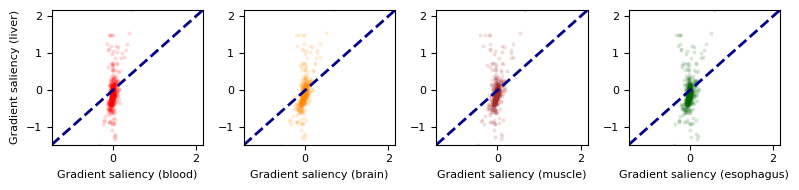

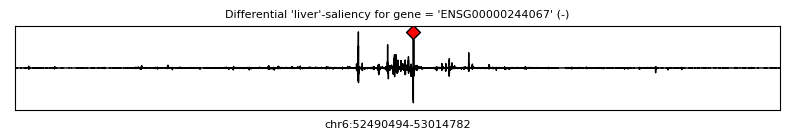

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 273142
 - max_pos (abs) = 52763636
 - chr6:52763540-52763732
blood


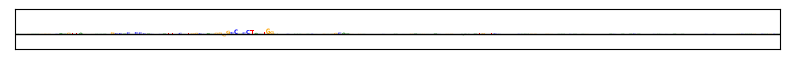

liver


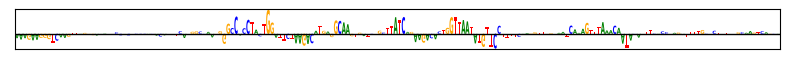

brain


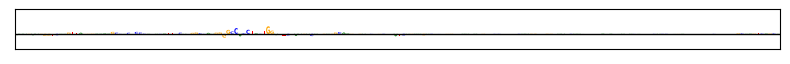

muscle


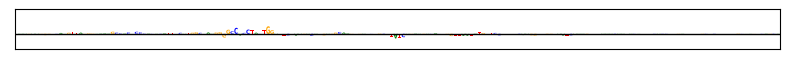

esophagus


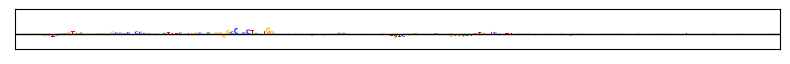

--------------------

-- Example = 25 --
 - ENSG00000165471(-)
 - chr10:52505301-53029589
 -- min_val = -1.133
 -- max_val = 1.208
 - (Gradient score profiles per tissue) - 


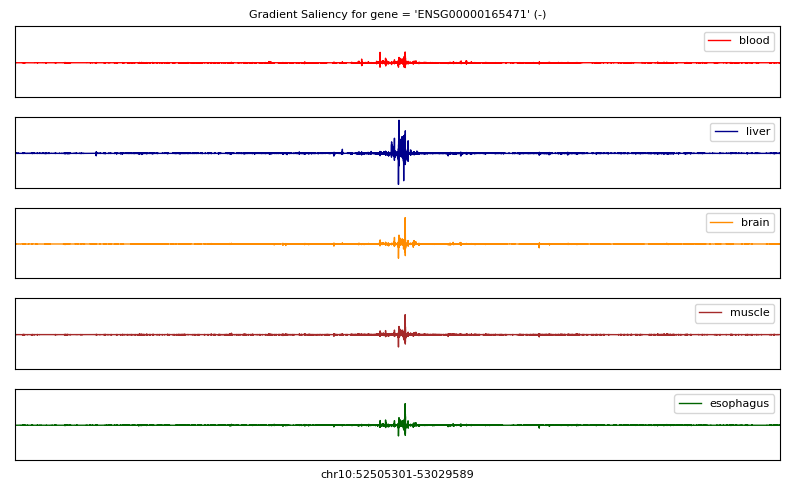

 - (Gradient score comparison against 'liver') - 
blood (r = 0.139)
brain (r = 0.179)
muscle (r = 0.303)
esophagus (r = 0.178)


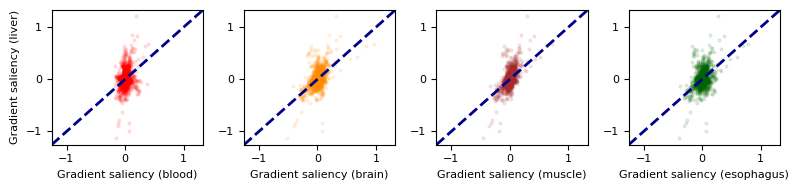

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.135)
brain (r = 0.06)
muscle (r = 0.298)
esophagus (r = 0.03)


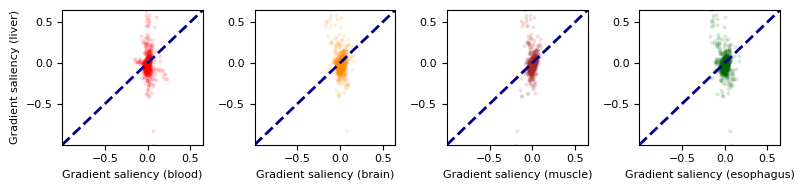

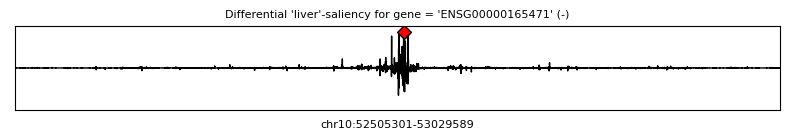

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 266410
 - max_pos (abs) = 52771711
 - chr10:52771615-52771807
blood


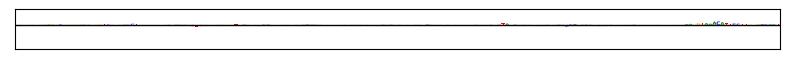

liver


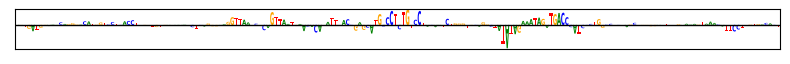

brain


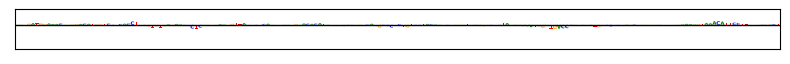

muscle


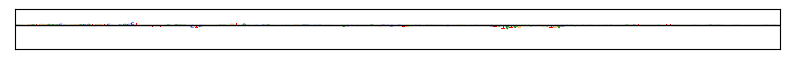

esophagus


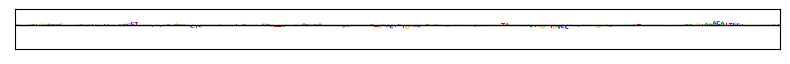

--------------------

-- Example = 26 --
 - ENSG00000066813(-)
 - chr16:20285166-20809454
 -- min_val = -1.204
 -- max_val = 1.171
 - (Gradient score profiles per tissue) - 


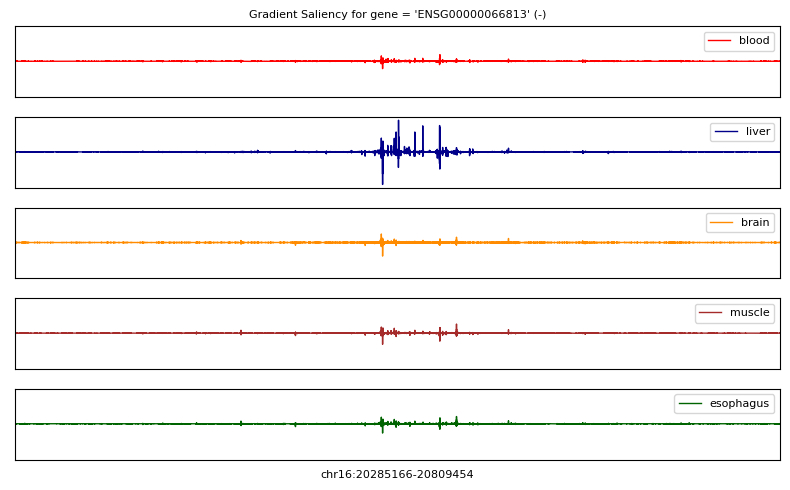

 - (Gradient score comparison against 'liver') - 
blood (r = 0.178)
brain (r = 0.06)
muscle (r = 0.162)
esophagus (r = 0.053)


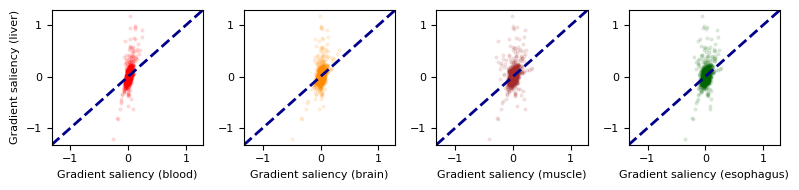

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.657)
brain (r = 0.416)
muscle (r = 0.355)
esophagus (r = 0.144)


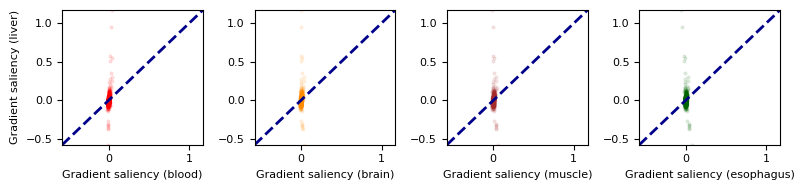

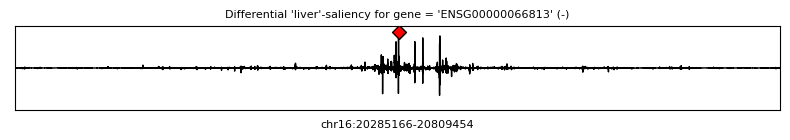

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 262897
 - max_pos (abs) = 20548063
 - chr16:20547967-20548159
blood


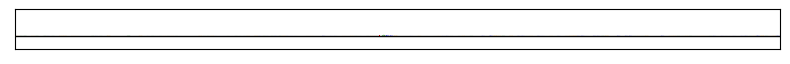

liver


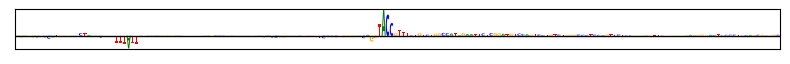

brain


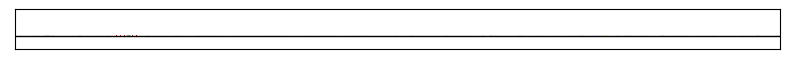

muscle


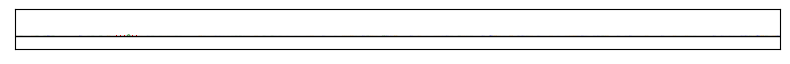

esophagus


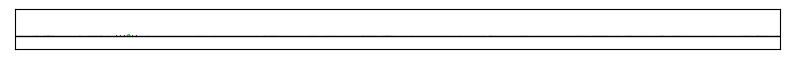

--------------------

-- Example = 27 --
 - ENSG00000250799(-)
 - chr19:35545450-36069738
 -- min_val = -1.154
 -- max_val = 2.13
 - (Gradient score profiles per tissue) - 


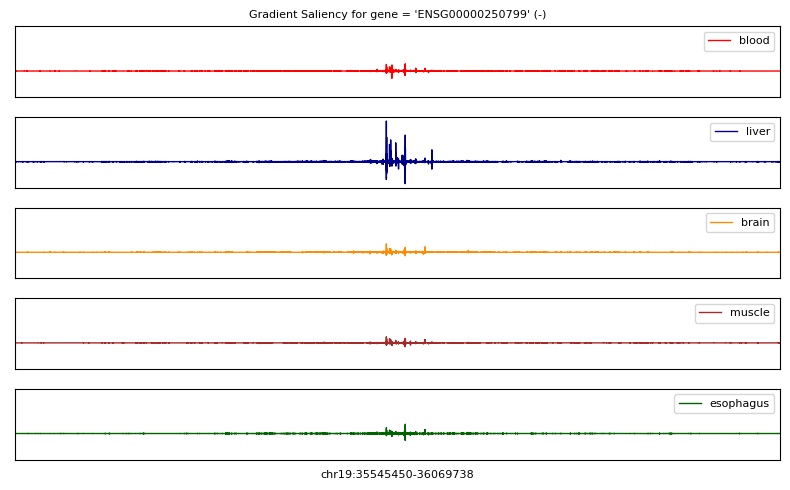

 - (Gradient score comparison against 'liver') - 
blood (r = 0.104)
brain (r = 0.127)
muscle (r = 0.241)
esophagus (r = 0.08)


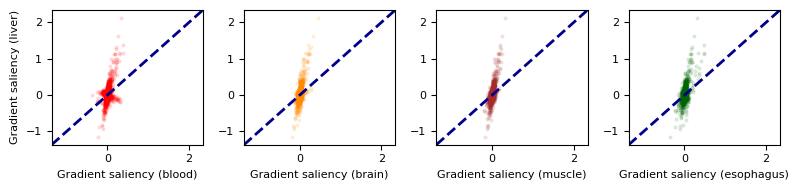

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.48)
brain (r = 0.255)
muscle (r = 0.528)
esophagus (r = 0.358)


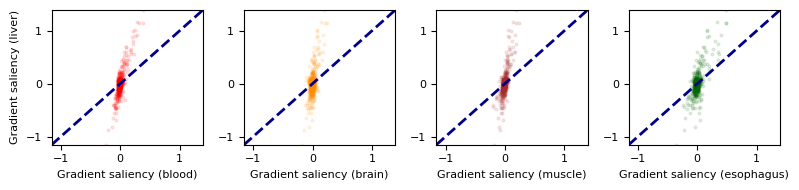

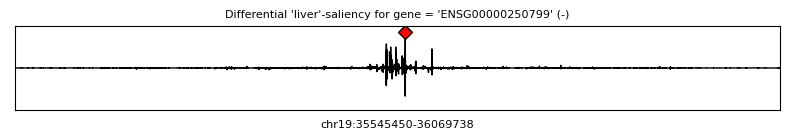

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 267507
 - max_pos (abs) = 35812957
 - chr19:35812861-35813053
blood


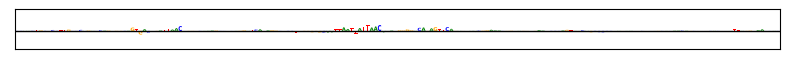

liver


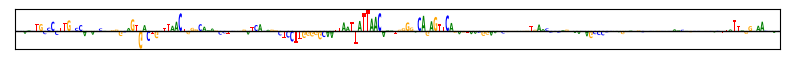

brain


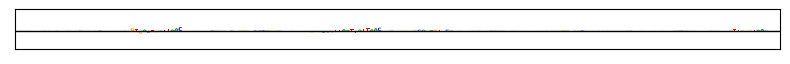

muscle


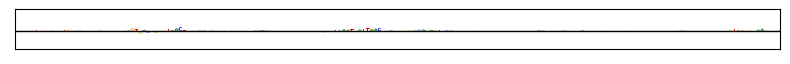

esophagus


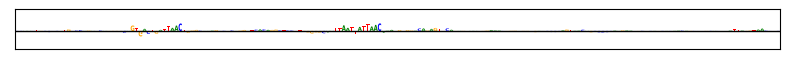

--------------------

-- Example = 28 --
 - ENSG00000122194(+)
 - chr6:160472080-160996368
 -- min_val = -2.645
 -- max_val = 4.04
 - (Gradient score profiles per tissue) - 


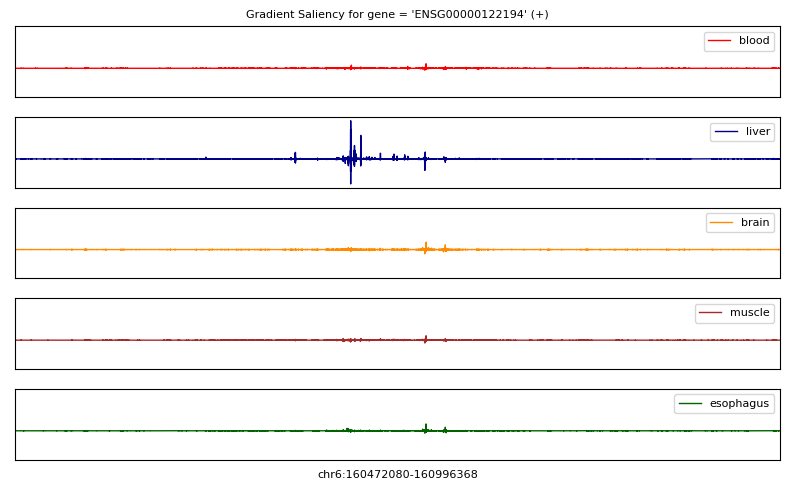

 - (Gradient score comparison against 'liver') - 
blood (r = 0.074)
brain (r = 0.064)
muscle (r = 0.215)
esophagus (r = 0.03)


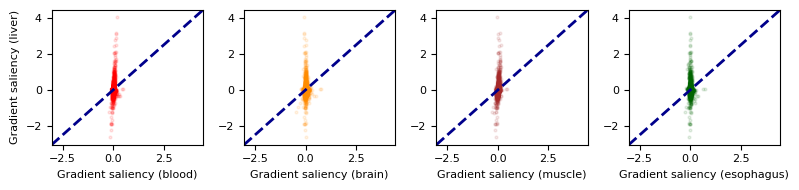

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.652)
brain (r = 0.179)
muscle (r = 0.468)
esophagus (r = -0.291)


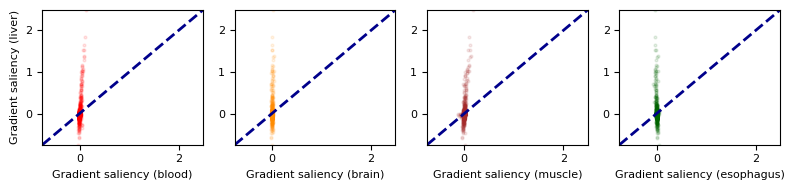

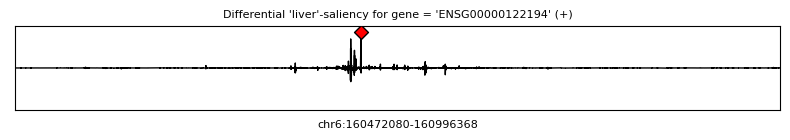

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 237063
 - max_pos (abs) = 160709143
 - chr6:160709047-160709239
blood


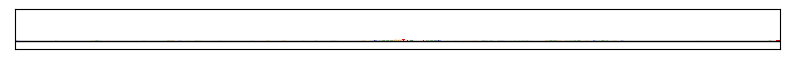

liver


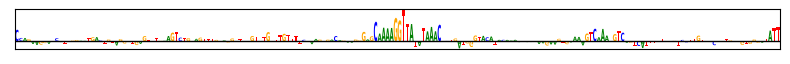

brain


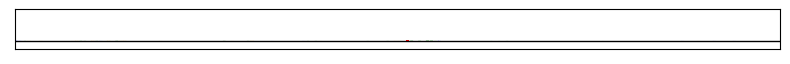

muscle


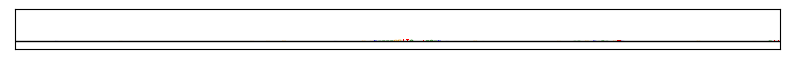

esophagus


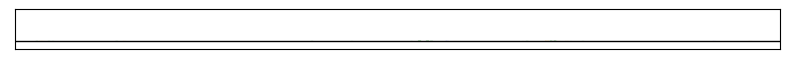

--------------------

-- Example = 29 --
 - ENSG00000105398(-)
 - chr19:47613304-48137592
 -- min_val = -1.154
 -- max_val = 0.674
 - (Gradient score profiles per tissue) - 


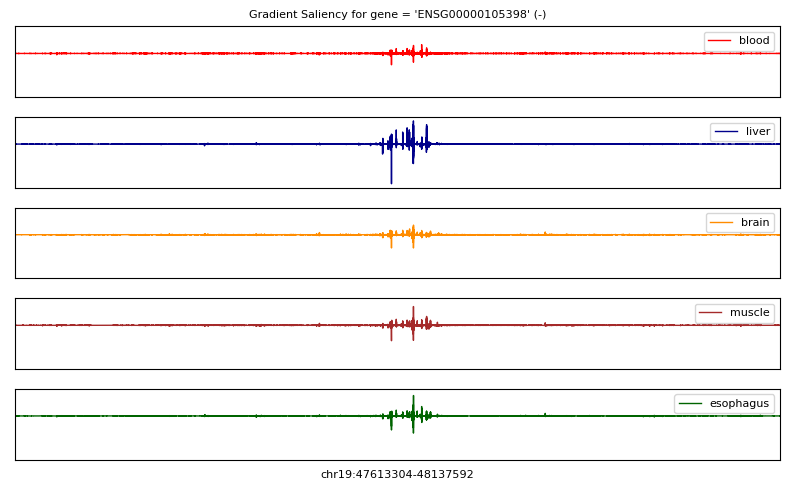

 - (Gradient score comparison against 'liver') - 
blood (r = 0.154)
brain (r = 0.14)
muscle (r = 0.248)
esophagus (r = 0.15)


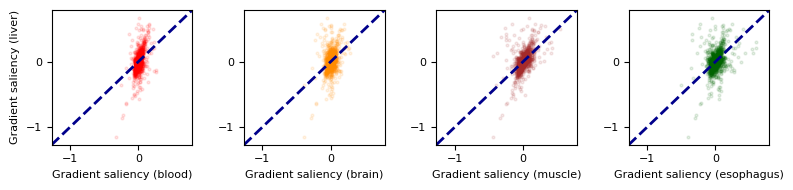

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.308)
brain (r = 0.195)
muscle (r = 0.5)
esophagus (r = 0.279)


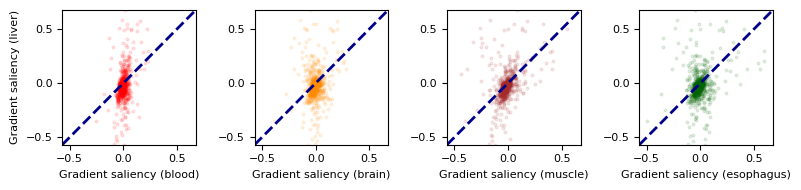

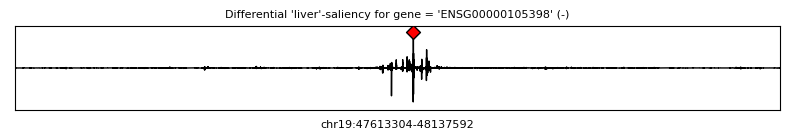

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 273061
 - max_pos (abs) = 47886365
 - chr19:47886269-47886461
blood


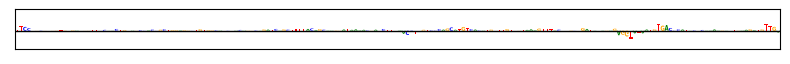

liver


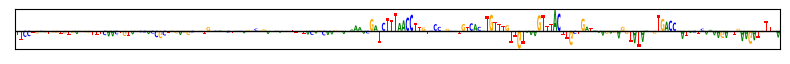

brain


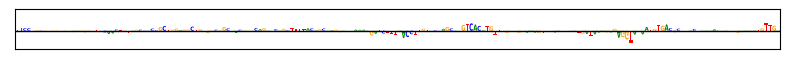

muscle


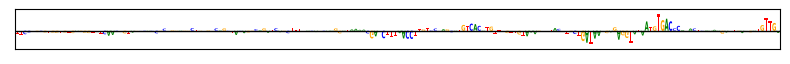

esophagus


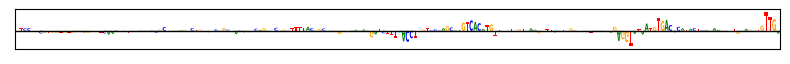

--------------------

-- Example = 30 --
 - ENSG00000134538(+)
 - chr12:20942856-21467144
 -- min_val = -0.4717
 -- max_val = 0.638
 - (Gradient score profiles per tissue) - 


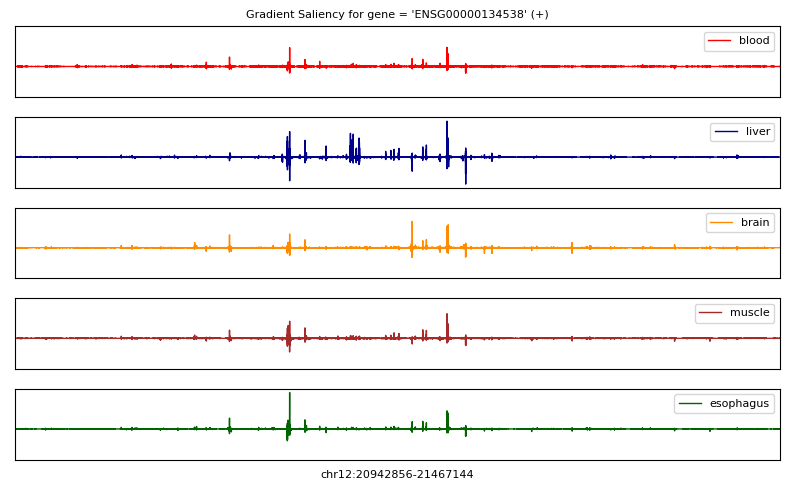

 - (Gradient score comparison against 'liver') - 
blood (r = 0.236)
brain (r = 0.077)
muscle (r = 0.324)
esophagus (r = 0.182)


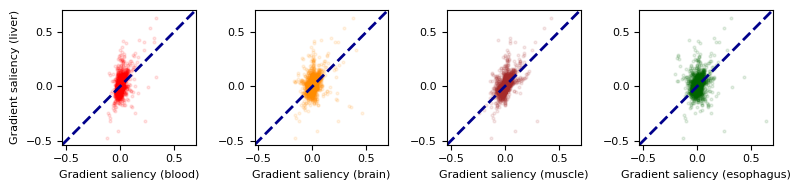

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.675)
brain (r = 0.359)
muscle (r = 0.681)
esophagus (r = 0.578)


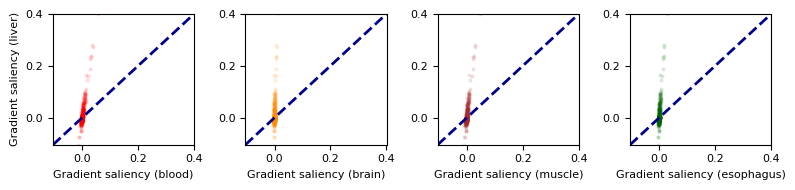

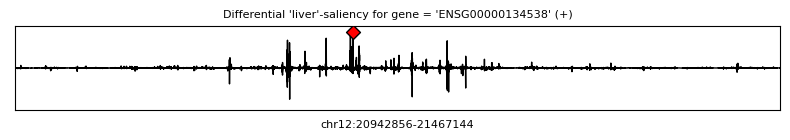

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 231852
 - max_pos (abs) = 21174708
 - chr12:21174612-21174804
blood


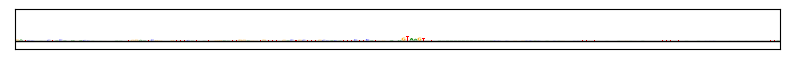

liver


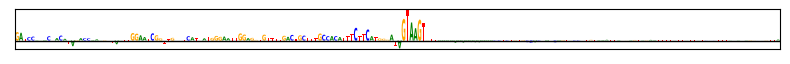

brain


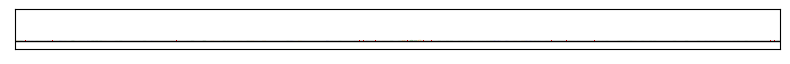

muscle


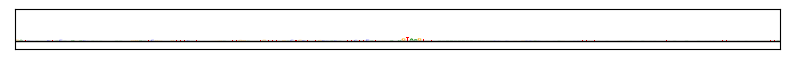

esophagus


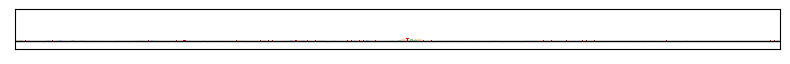

--------------------

-- Example = 31 --
 - ENSG00000198610(+)
 - chr10:4946883-5471171
 -- min_val = -0.7183
 -- max_val = 2.143
 - (Gradient score profiles per tissue) - 


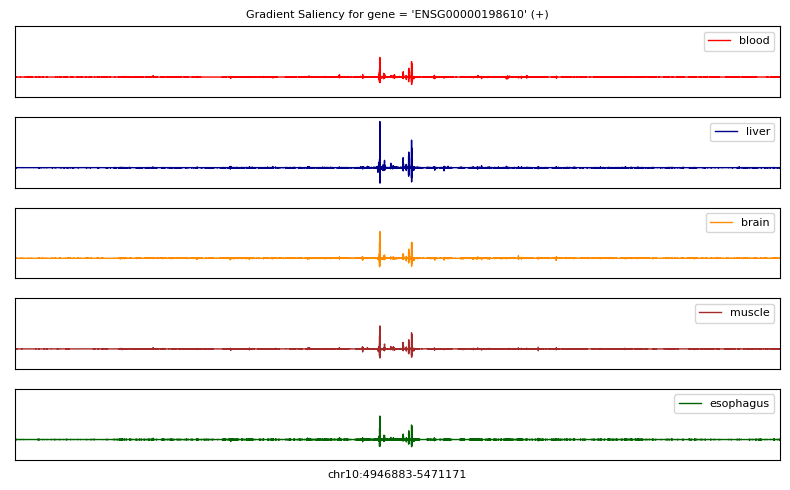

 - (Gradient score comparison against 'liver') - 
blood (r = 0.251)
brain (r = 0.242)
muscle (r = 0.337)
esophagus (r = 0.31)


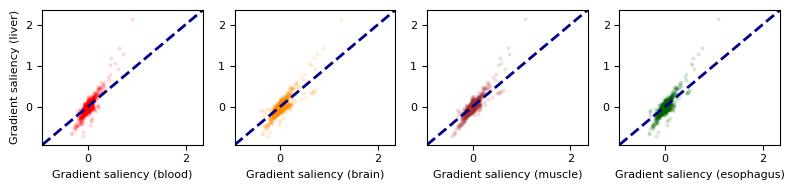

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.765)
brain (r = 0.743)
muscle (r = 0.806)
esophagus (r = 0.735)


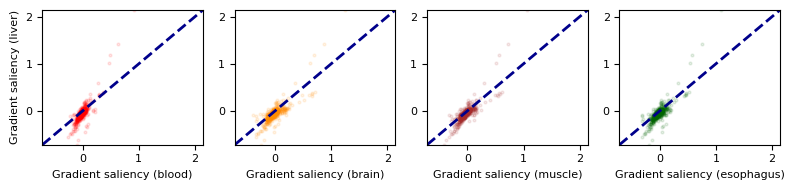

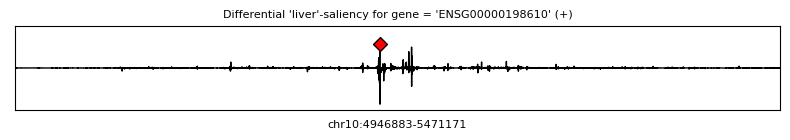

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 250066
 - max_pos (abs) = 5196949
 - chr10:5196853-5197045
blood


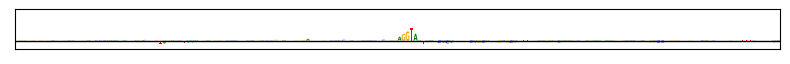

liver


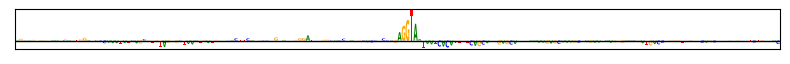

brain


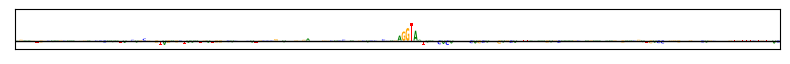

muscle


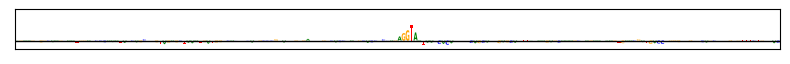

esophagus


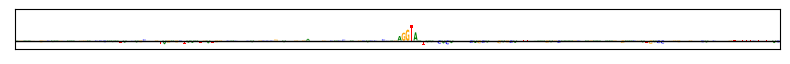

--------------------

-- Example = 32 --
 - ENSG00000140505(+)
 - chr15:74491458-75015746
 -- min_val = -2.674
 -- max_val = 2.07
 - (Gradient score profiles per tissue) - 


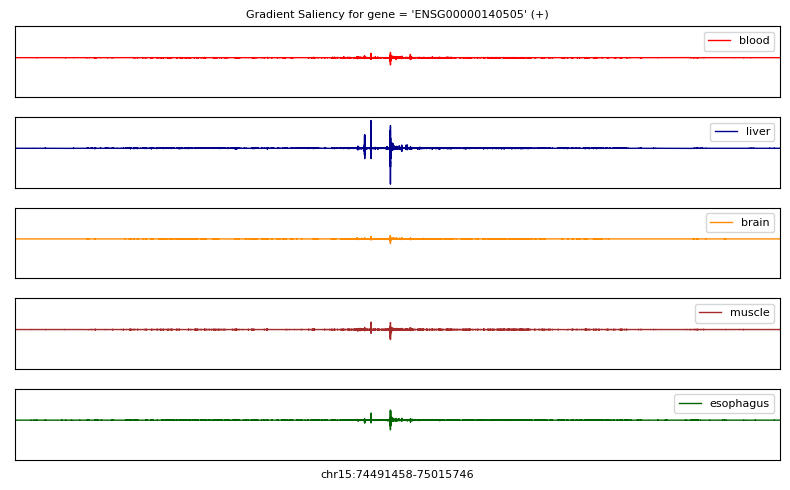

 - (Gradient score comparison against 'liver') - 
blood (r = 0.15)
brain (r = 0.192)
muscle (r = 0.275)
esophagus (r = 0.086)


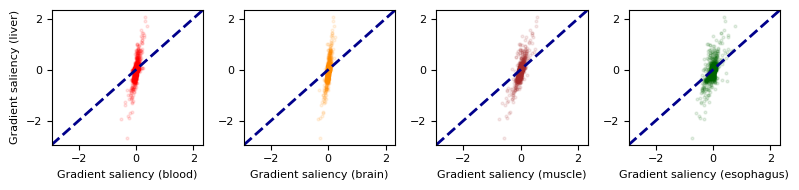

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.644)
brain (r = 0.661)
muscle (r = 0.804)
esophagus (r = 0.637)


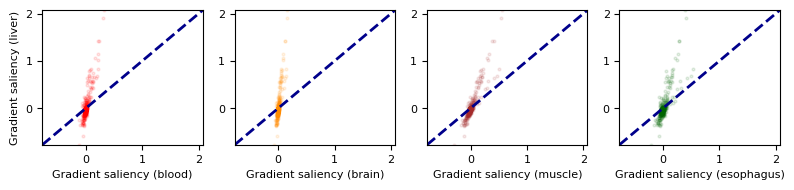

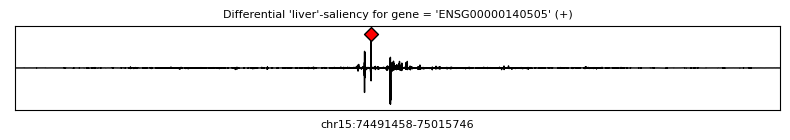

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 243993
 - max_pos (abs) = 74735451
 - chr15:74735355-74735547
blood


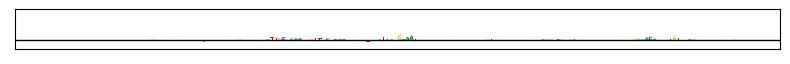

liver


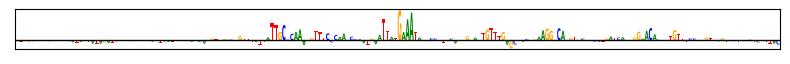

brain


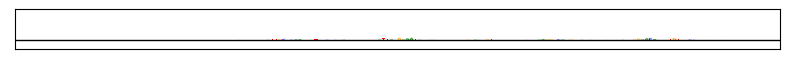

muscle


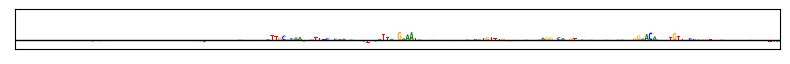

esophagus


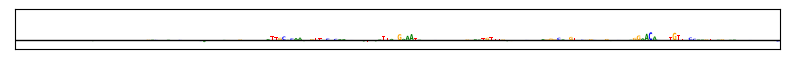

--------------------

-- Example = 33 --
 - ENSG00000113492(-)
 - chr5:34756300-35280588
 -- min_val = -0.798
 -- max_val = 1.06
 - (Gradient score profiles per tissue) - 


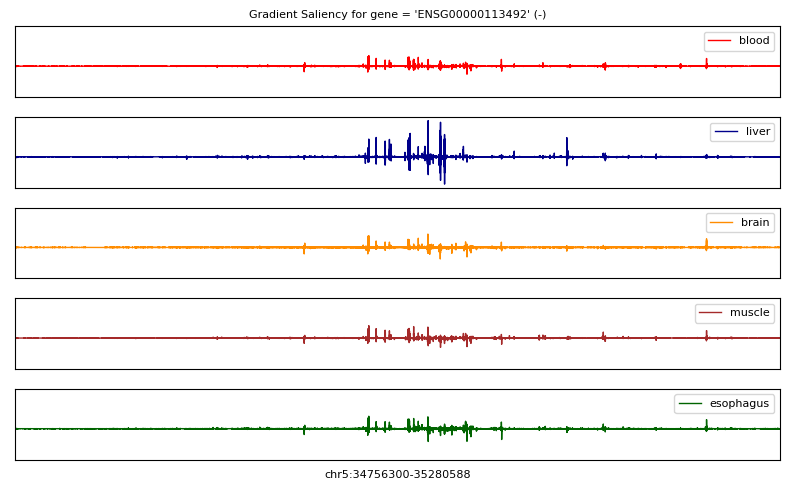

 - (Gradient score comparison against 'liver') - 
blood (r = 0.474)
brain (r = 0.294)
muscle (r = 0.398)
esophagus (r = 0.361)


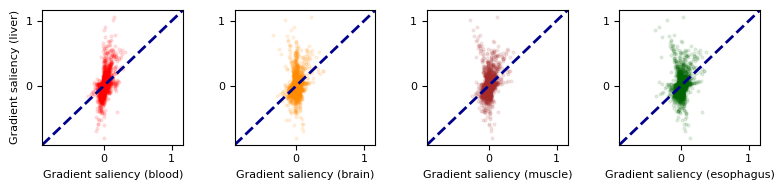

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.808)
brain (r = -0.69)
muscle (r = -0.47)
esophagus (r = -0.314)


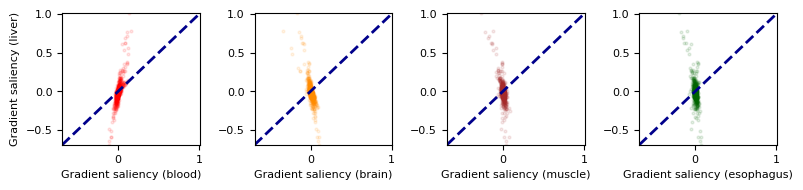

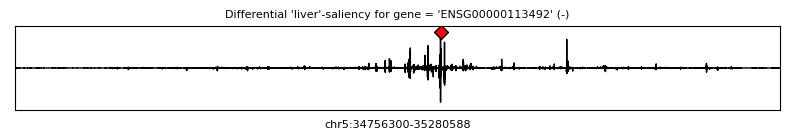

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 291667
 - max_pos (abs) = 35047967
 - chr5:35047871-35048063
blood


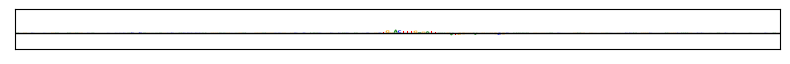

liver


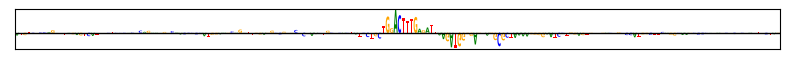

brain


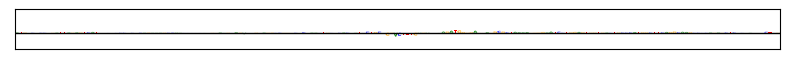

muscle


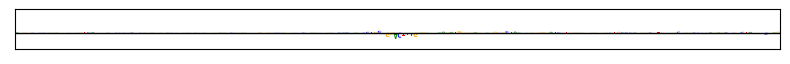

esophagus


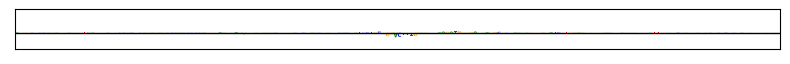

--------------------

-- Example = 34 --
 - ENSG00000183747(+)
 - chr16:20214780-20739068
 -- min_val = -0.9614
 -- max_val = 0.98
 - (Gradient score profiles per tissue) - 


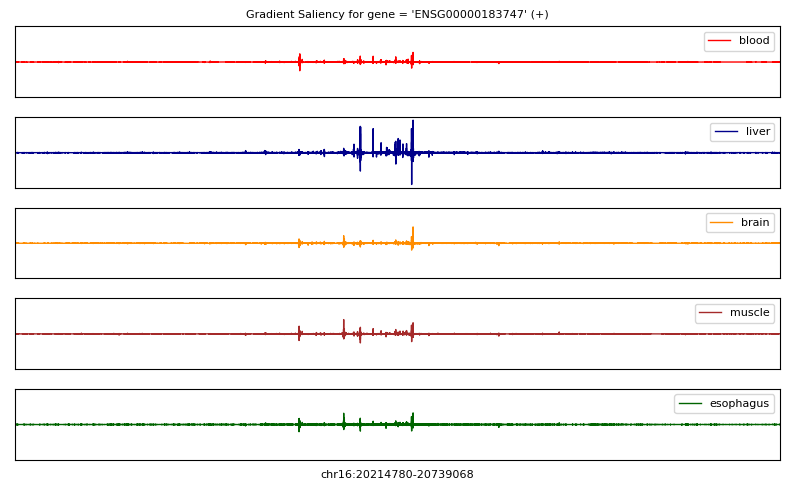

 - (Gradient score comparison against 'liver') - 
blood (r = 0.15)
brain (r = 0.117)
muscle (r = 0.223)
esophagus (r = 0.115)


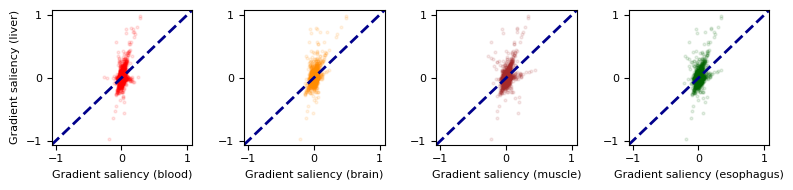

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.906)
brain (r = 0.907)
muscle (r = 0.9)
esophagus (r = 0.9)


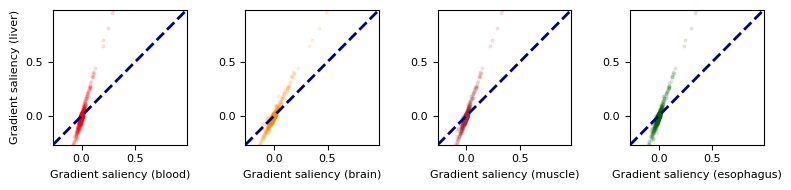

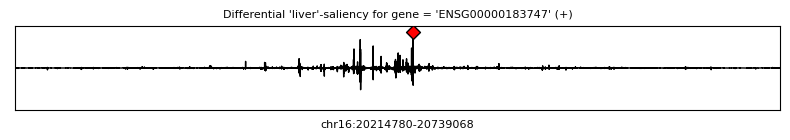

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 272875
 - max_pos (abs) = 20487655
 - chr16:20487559-20487751
blood


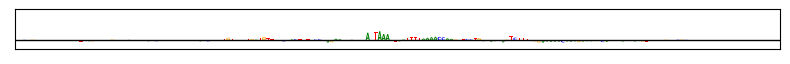

liver


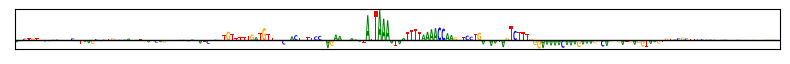

brain


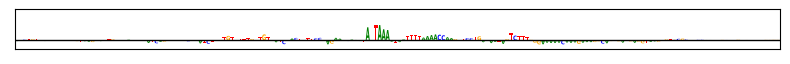

muscle


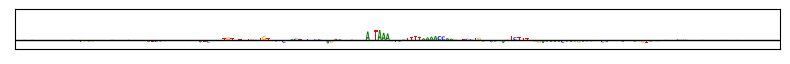

esophagus


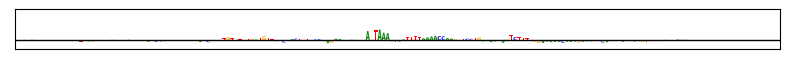

--------------------

-- Example = 35 --
 - ENSG00000116882(+)
 - chr1:119124464-119648752
 -- min_val = -1.121
 -- max_val = 2.465
 - (Gradient score profiles per tissue) - 


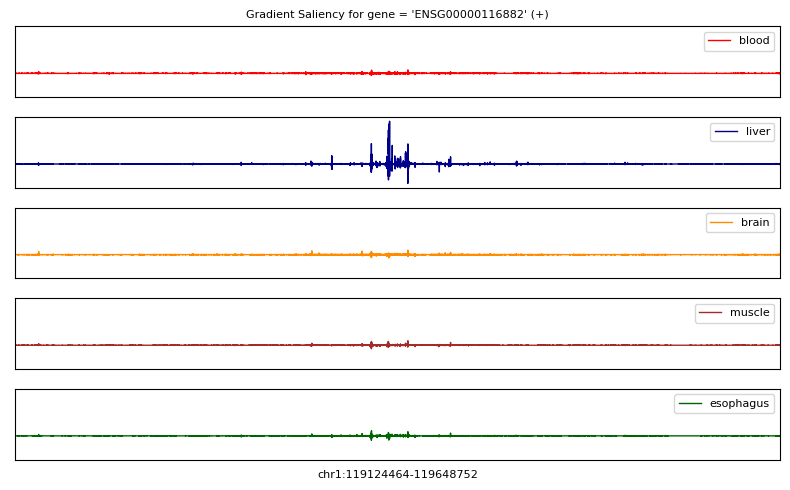

 - (Gradient score comparison against 'liver') - 
blood (r = 0.032)
brain (r = -0.108)
muscle (r = 0.046)
esophagus (r = -0.053)


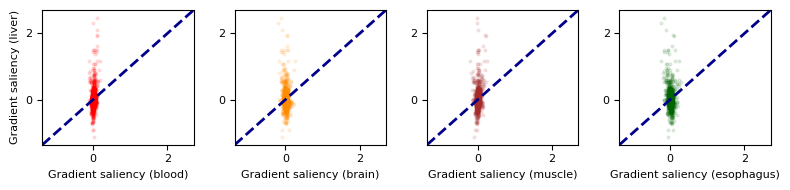

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.266)
brain (r = -0.376)
muscle (r = 0.233)
esophagus (r = -0.5)


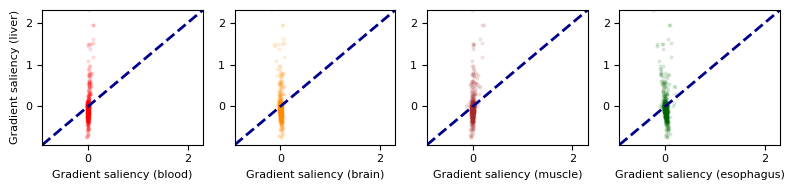

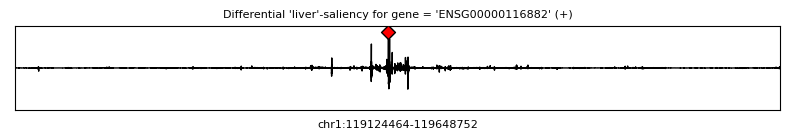

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 256000
 - max_pos (abs) = 119380464
 - chr1:119380368-119380560
blood


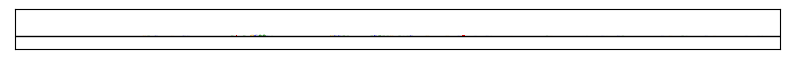

liver


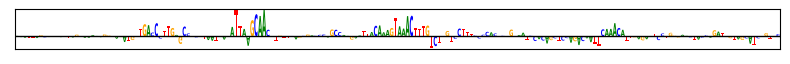

brain


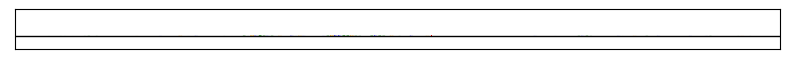

muscle


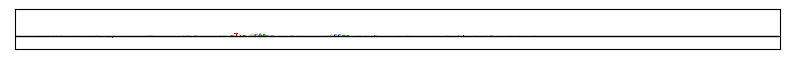

esophagus


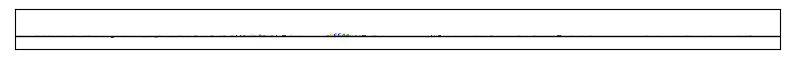

--------------------

-- Example = 36 --
 - ENSG00000122787(+)
 - chr7:137847768-138372056
 -- min_val = -1.208
 -- max_val = 3.123
 - (Gradient score profiles per tissue) - 


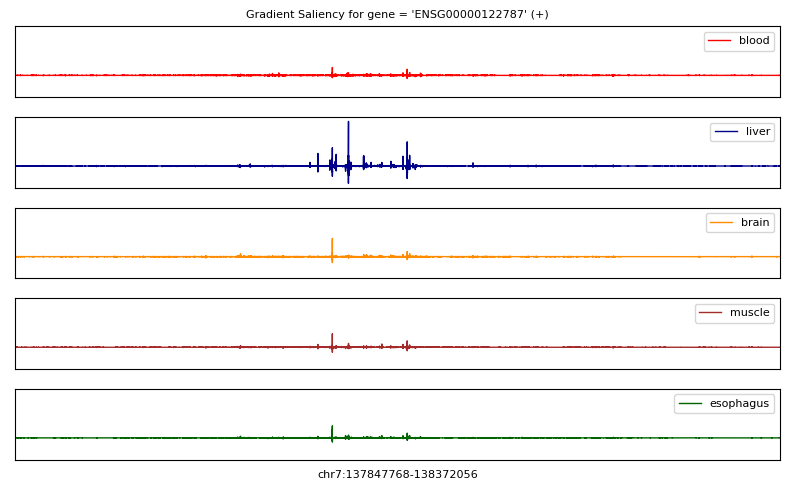

 - (Gradient score comparison against 'liver') - 
blood (r = 0.231)
brain (r = 0.242)
muscle (r = 0.399)
esophagus (r = 0.275)


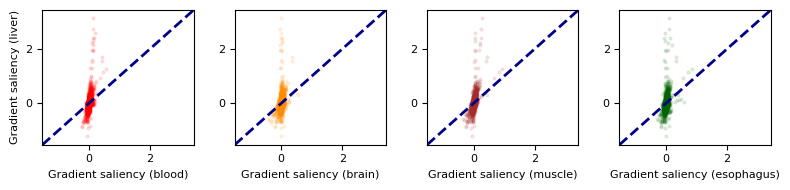

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.55)
brain (r = 0.337)
muscle (r = 0.589)
esophagus (r = 0.317)


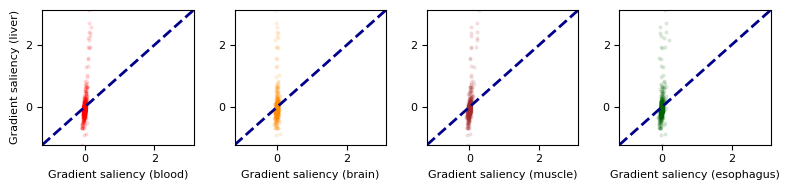

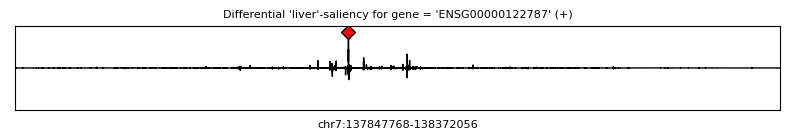

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 228613
 - max_pos (abs) = 138076381
 - chr7:138076285-138076477
blood


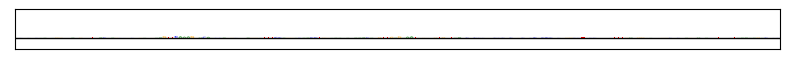

liver


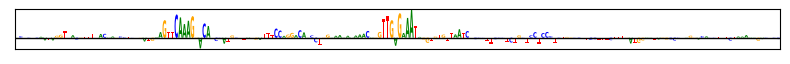

brain


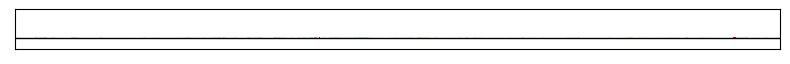

muscle


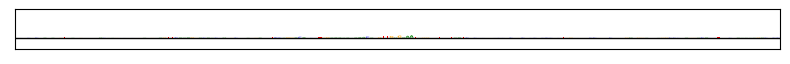

esophagus


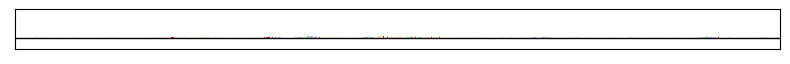

--------------------

-- Example = 37 --
 - ENSG00000123561(-)
 - chrX:105772324-106296612
 -- min_val = -1.02
 -- max_val = 3.34
 - (Gradient score profiles per tissue) - 


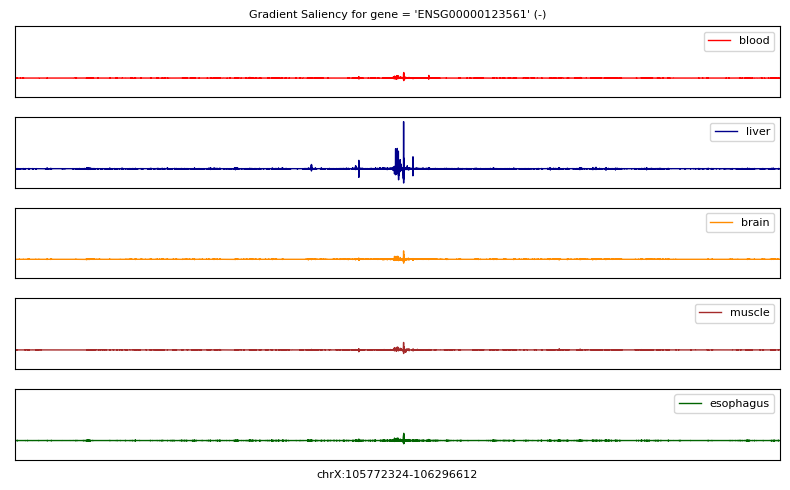

 - (Gradient score comparison against 'liver') - 
blood (r = -0.042)
brain (r = -0.022)
muscle (r = 0.112)
esophagus (r = -0.032)


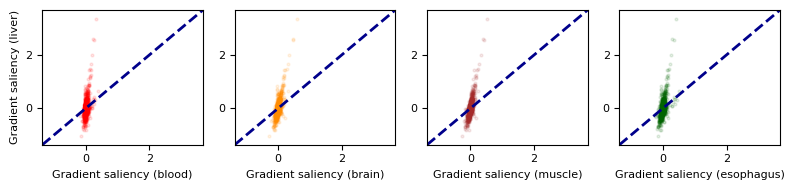

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.562)
brain (r = 0.707)
muscle (r = 0.746)
esophagus (r = 0.612)


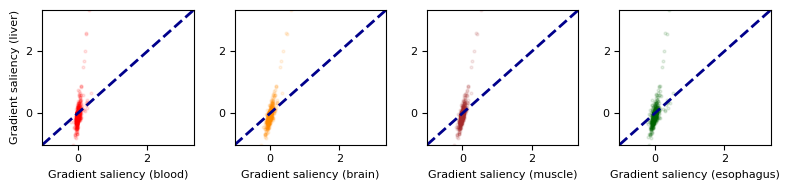

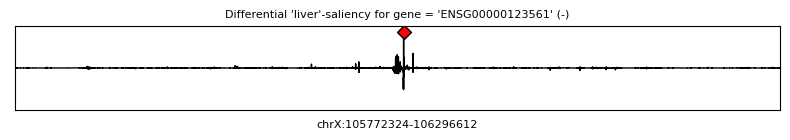

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 266370
 - max_pos (abs) = 106038694
 - chrX:106038598-106038790
blood


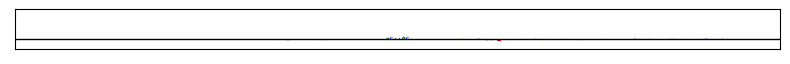

liver


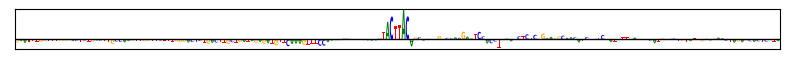

brain


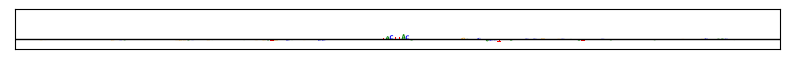

muscle


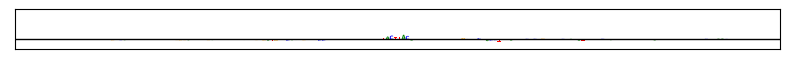

esophagus


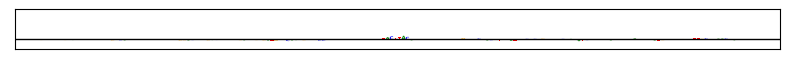

--------------------

-- Example = 38 --
 - ENSG00000114771(+)
 - chr3:151562042-152086330
 -- min_val = -1.457
 -- max_val = 1.415
 - (Gradient score profiles per tissue) - 


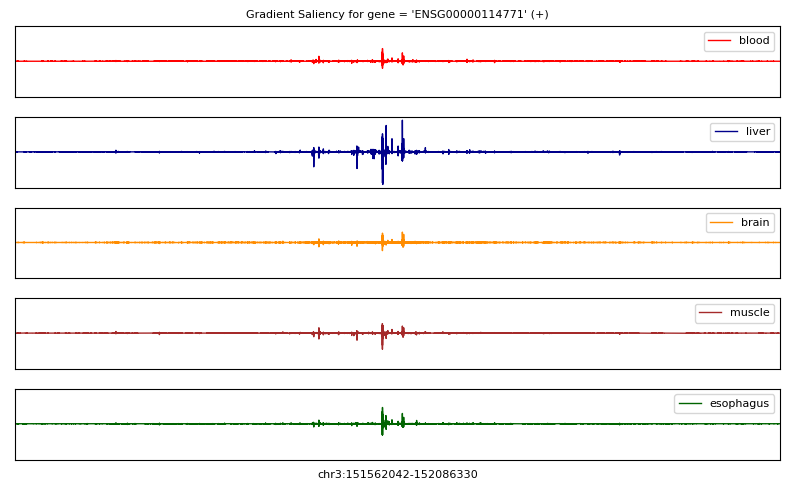

 - (Gradient score comparison against 'liver') - 
blood (r = 0.031)
brain (r = 0.076)
muscle (r = 0.197)
esophagus (r = 0.04)


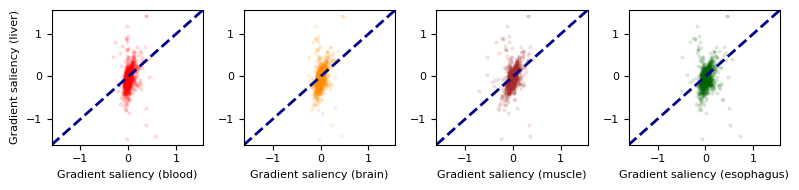

 - (Differential gradient score of liver against 'mean') -
blood (r = -0.176)
brain (r = -0.147)
muscle (r = -0.102)
esophagus (r = -0.413)


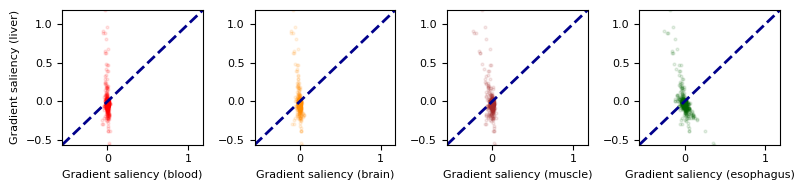

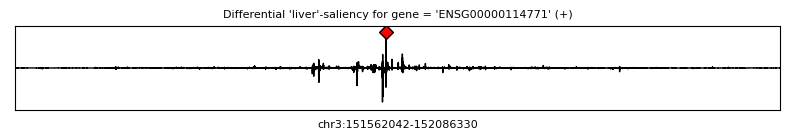

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 254394
 - max_pos (abs) = 151816436
 - chr3:151816340-151816532
blood


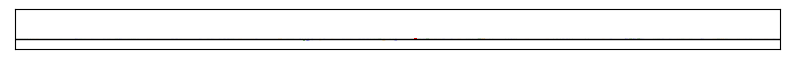

liver


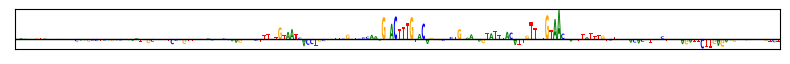

brain


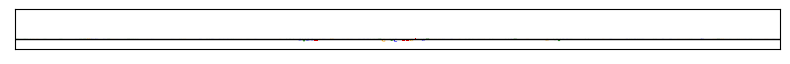

muscle


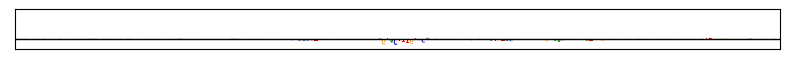

esophagus


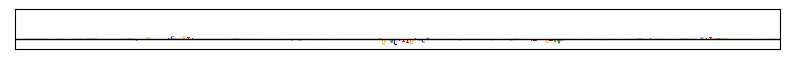

--------------------

-- Example = 39 --
 - ENSG00000132855(+)
 - chr1:62341109-62865397
 -- min_val = -0.5728
 -- max_val = 0.794
 - (Gradient score profiles per tissue) - 


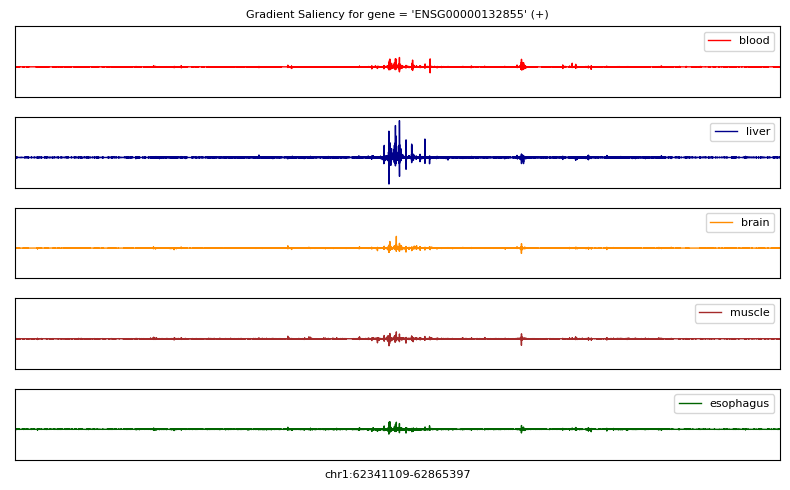

 - (Gradient score comparison against 'liver') - 
blood (r = 0.061)
brain (r = -0.056)
muscle (r = -0.084)
esophagus (r = -0.174)


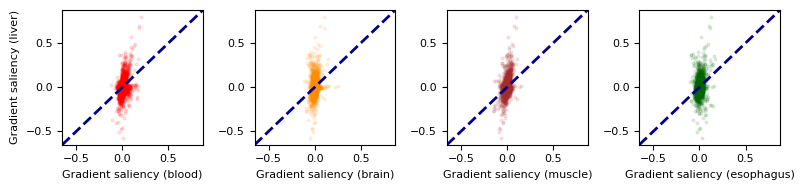

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.467)
brain (r = -0.148)
muscle (r = 0.449)
esophagus (r = 0.122)


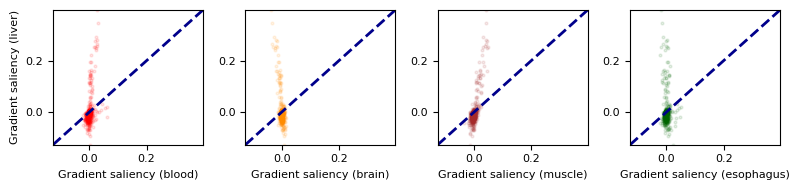

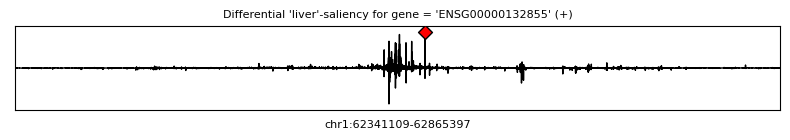

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 280970
 - max_pos (abs) = 62622079
 - chr1:62621983-62622175
blood


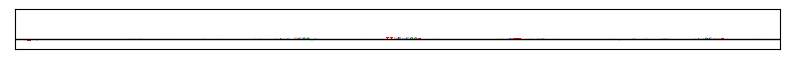

liver


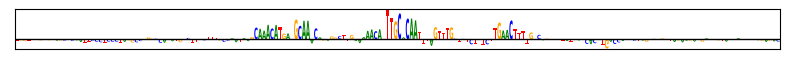

brain


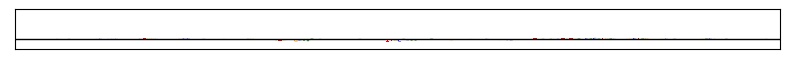

muscle


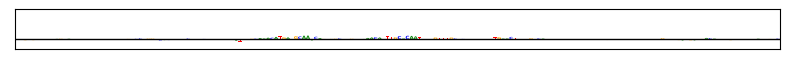

esophagus


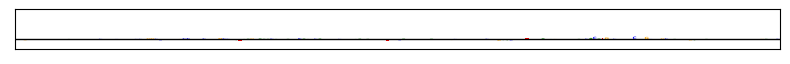

--------------------

-- Example = 40 --
 - ENSG00000149124(-)
 - chr11:58449865-58974153
 -- min_val = -0.9214
 -- max_val = 2.834
 - (Gradient score profiles per tissue) - 


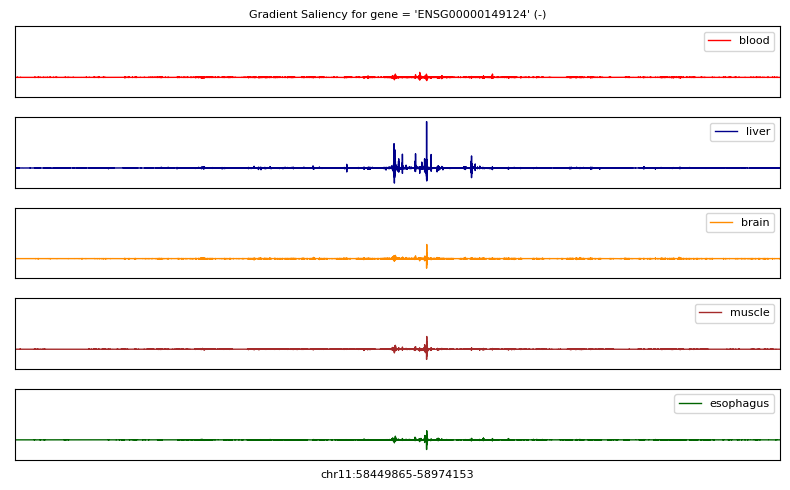

 - (Gradient score comparison against 'liver') - 
blood (r = 0.062)
brain (r = 0.016)
muscle (r = 0.181)
esophagus (r = 0.025)


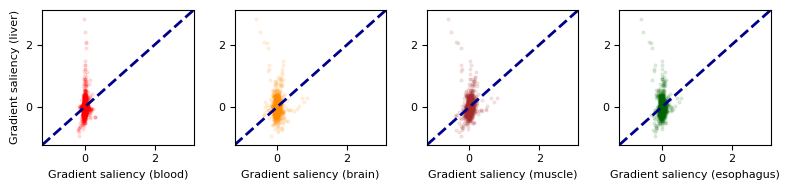

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.144)
brain (r = -0.138)
muscle (r = 0.193)
esophagus (r = 0.081)


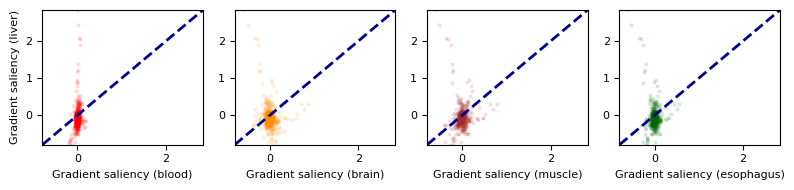

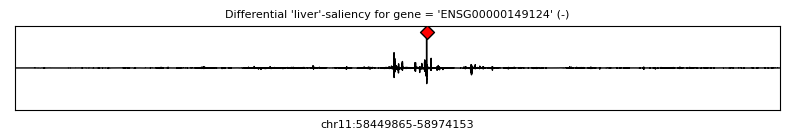

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 282131
 - max_pos (abs) = 58731996
 - chr11:58731900-58732092
blood


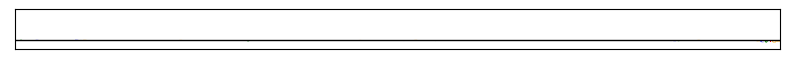

liver


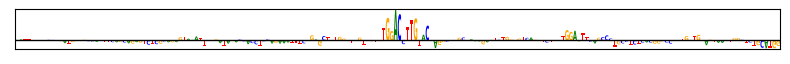

brain


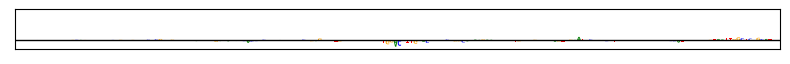

muscle


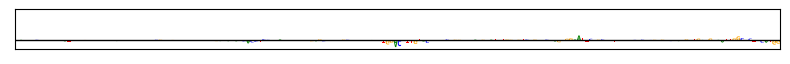

esophagus


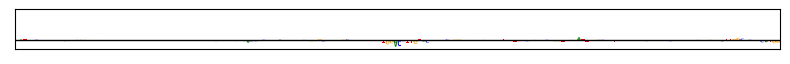

--------------------

-- Example = 41 --
 - ENSG00000186910(-)
 - chr14:94184269-94708557
 -- min_val = -0.792
 -- max_val = 3.043
 - (Gradient score profiles per tissue) - 


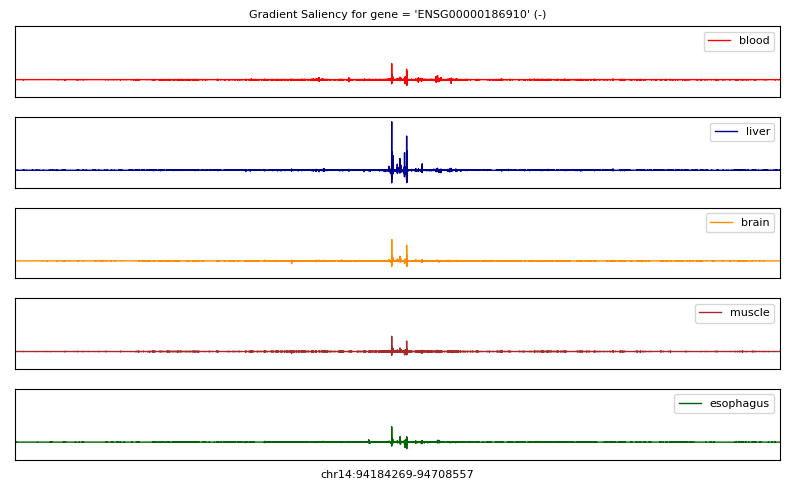

 - (Gradient score comparison against 'liver') - 
blood (r = 0.054)
brain (r = 0.265)
muscle (r = 0.259)
esophagus (r = 0.136)


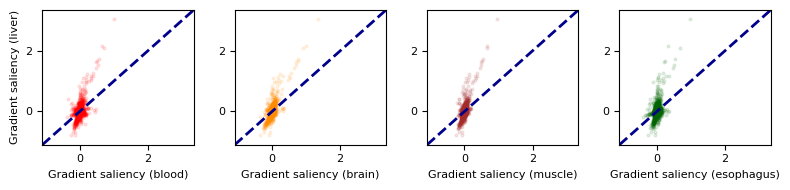

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.397)
brain (r = 0.617)
muscle (r = 0.536)
esophagus (r = 0.416)


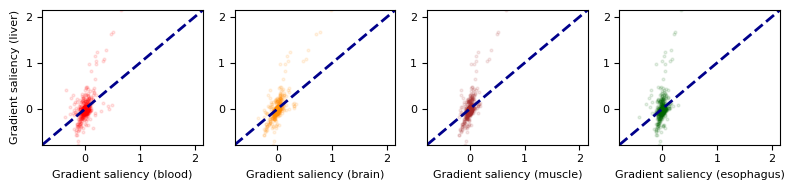

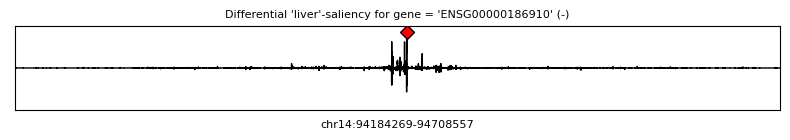

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 268572
 - max_pos (abs) = 94452841
 - chr14:94452745-94452937
blood


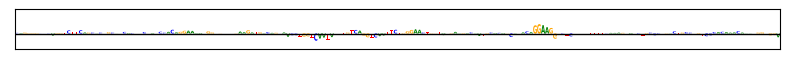

liver


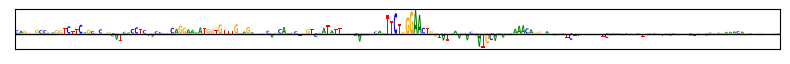

brain


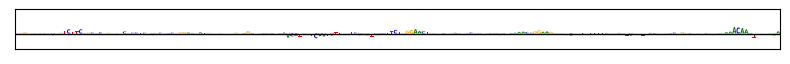

muscle


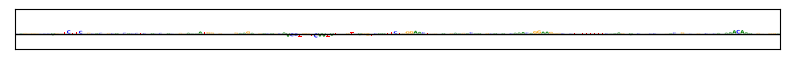

esophagus


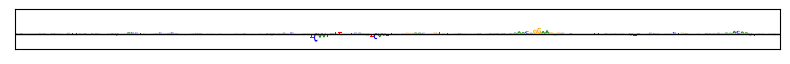

--------------------

-- Example = 42 --
 - ENSG00000244414(+)
 - chr1:196565854-197090142
 -- min_val = -1.125
 -- max_val = 1.989
 - (Gradient score profiles per tissue) - 


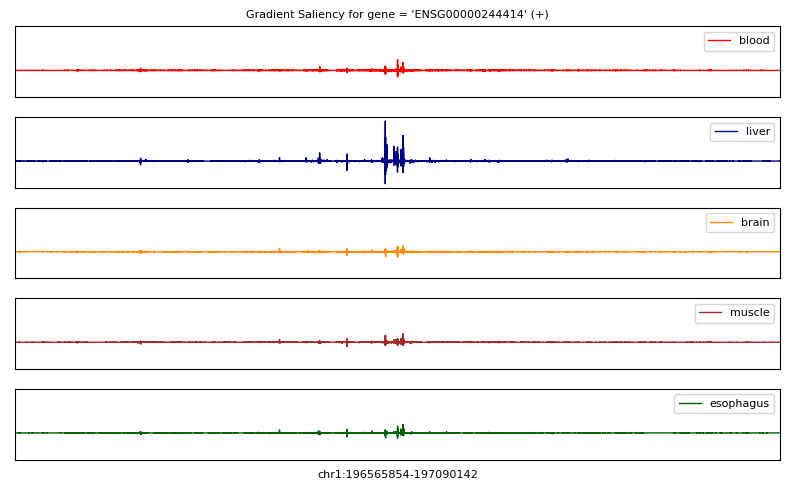

 - (Gradient score comparison against 'liver') - 
blood (r = 0.177)
brain (r = 0.255)
muscle (r = 0.35)
esophagus (r = 0.233)


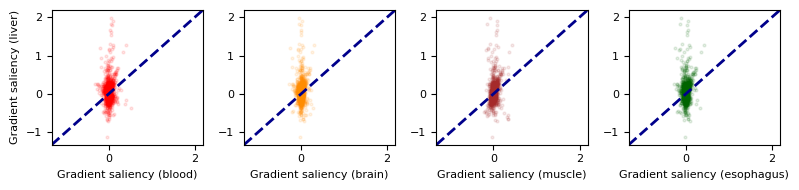

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.119)
brain (r = -0.104)
muscle (r = 0.198)
esophagus (r = 0.029)


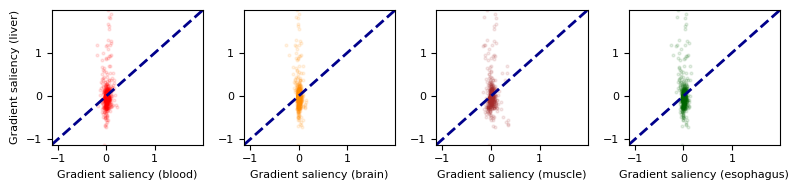

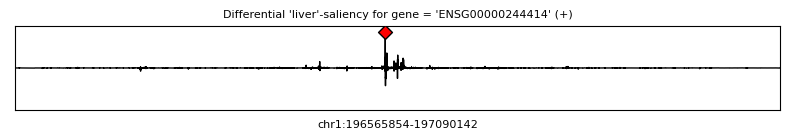

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 253833
 - max_pos (abs) = 196819687
 - chr1:196819591-196819783
blood


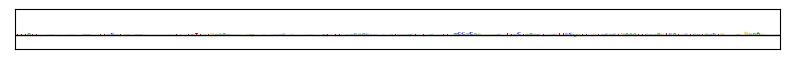

liver


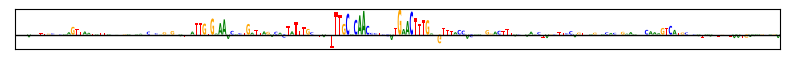

brain


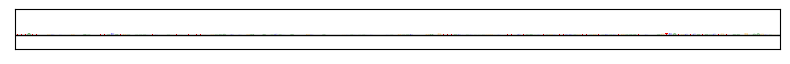

muscle


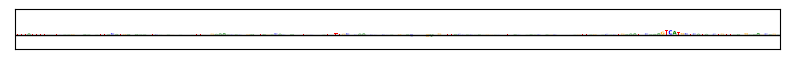

esophagus


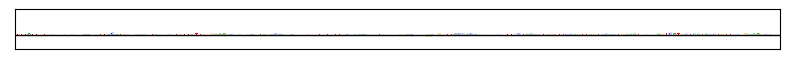

--------------------

-- Example = 43 --
 - ENSG00000113905(+)
 - chr3:186412587-186936875
 -- min_val = -1.069
 -- max_val = 3.084
 - (Gradient score profiles per tissue) - 


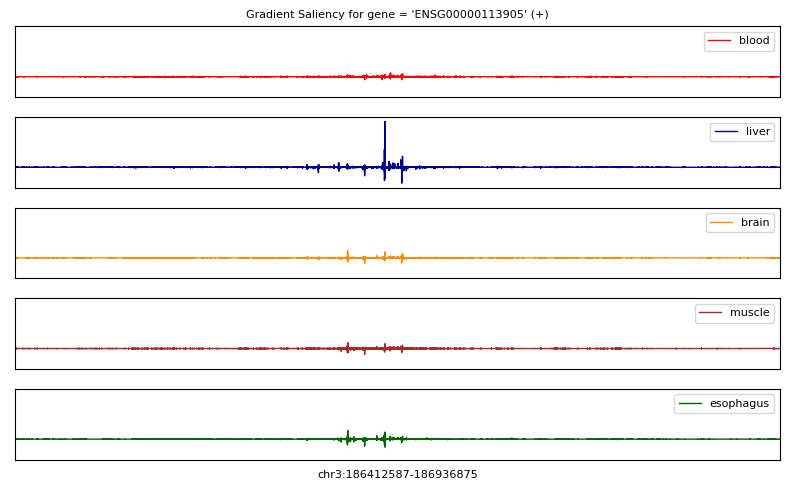

 - (Gradient score comparison against 'liver') - 
blood (r = 0.158)
brain (r = 0.219)
muscle (r = 0.271)
esophagus (r = 0.042)


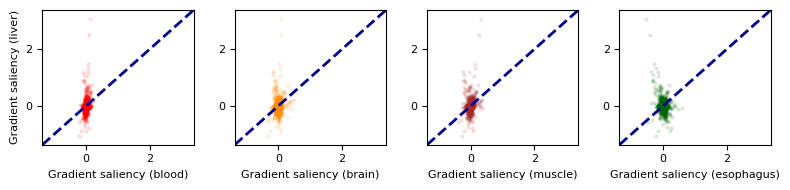

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.301)
brain (r = -0.106)
muscle (r = 0.191)
esophagus (r = -0.54)


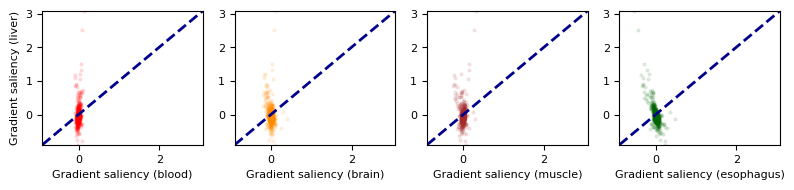

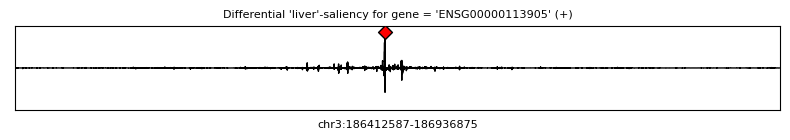

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 253625
 - max_pos (abs) = 186666212
 - chr3:186666116-186666308
blood


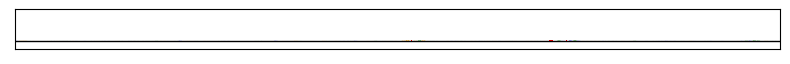

liver


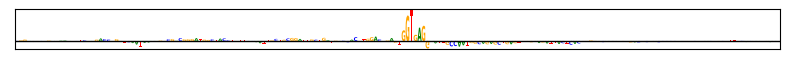

brain


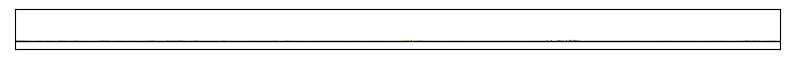

muscle


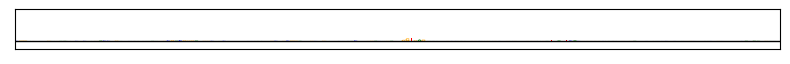

esophagus


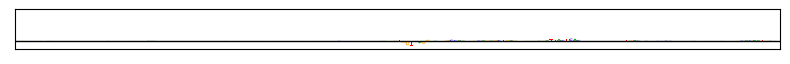

--------------------

-- Example = 44 --
 - ENSG00000198650(-)
 - chr16:71306818-71831106
 -- min_val = -0.7666
 -- max_val = 3.734
 - (Gradient score profiles per tissue) - 


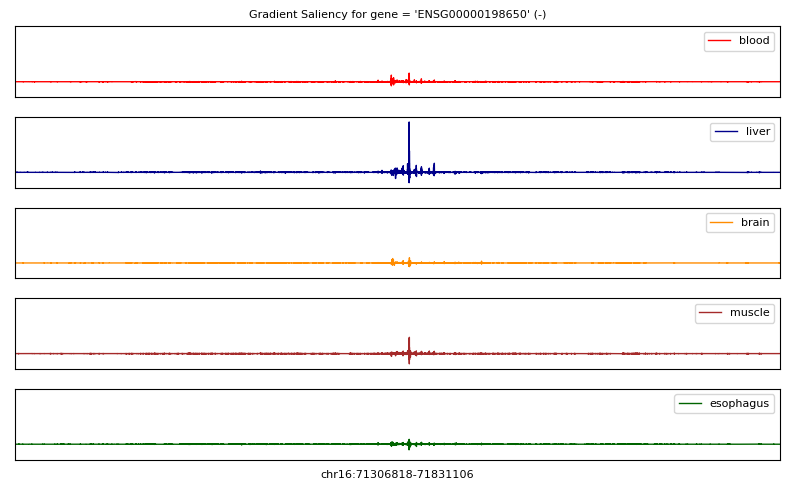

 - (Gradient score comparison against 'liver') - 
blood (r = 0.142)
brain (r = 0.066)
muscle (r = 0.246)
esophagus (r = 0.137)


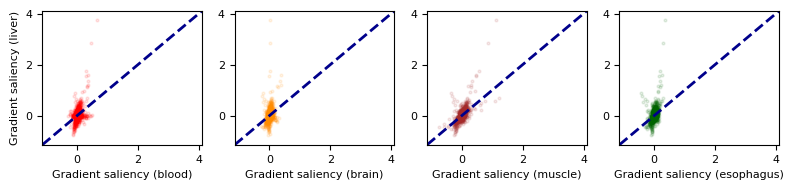

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.388)
brain (r = 0.438)
muscle (r = 0.66)
esophagus (r = 0.549)


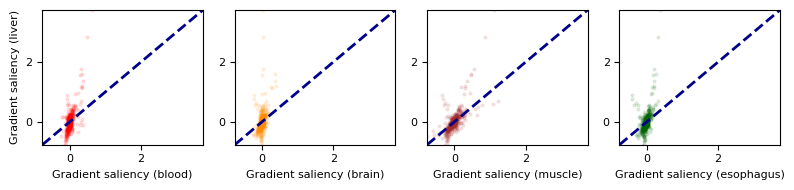

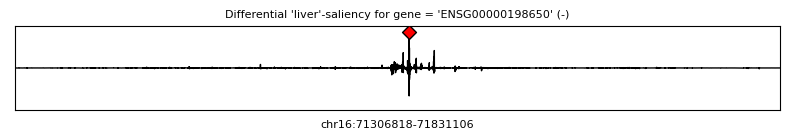

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 270192
 - max_pos (abs) = 71577010
 - chr16:71576914-71577106
blood


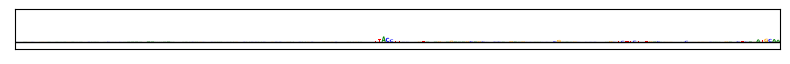

liver


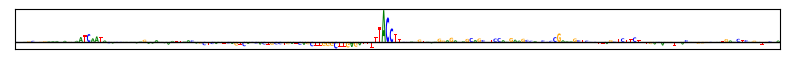

brain


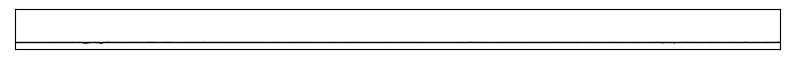

muscle


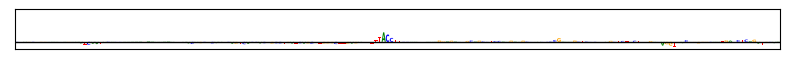

esophagus


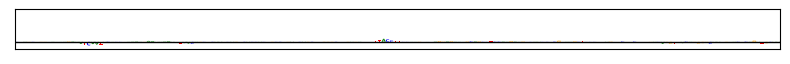

--------------------

-- Example = 45 --
 - ENSG00000111700(+)
 - chr12:20618423-21142711
 -- min_val = -0.388
 -- max_val = 0.513
 - (Gradient score profiles per tissue) - 


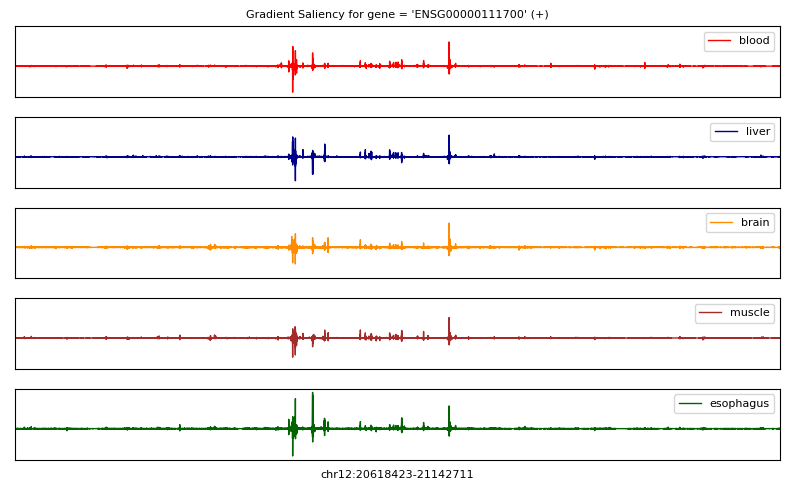

 - (Gradient score comparison against 'liver') - 
blood (r = 0.293)
brain (r = 0.171)
muscle (r = 0.328)
esophagus (r = 0.135)


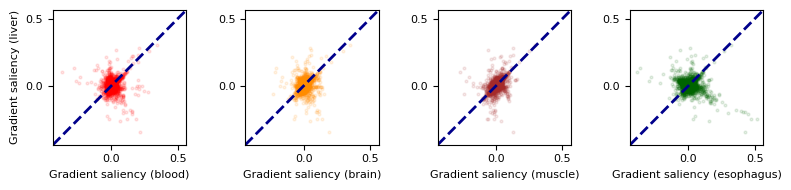

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.124)
brain (r = -0.03)
muscle (r = 0.233)
esophagus (r = -0.194)


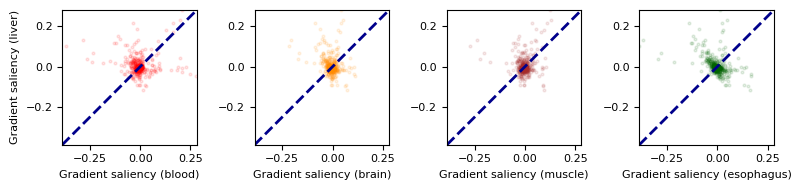

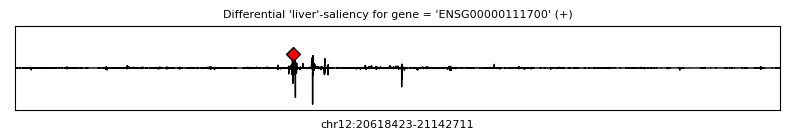

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 190347
 - max_pos (abs) = 20808770
 - chr12:20808674-20808866
blood


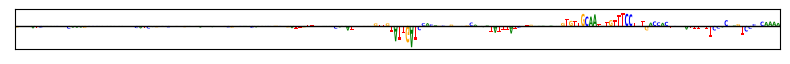

liver


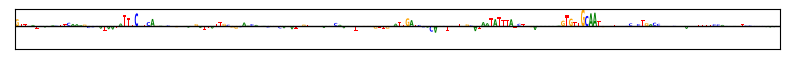

brain


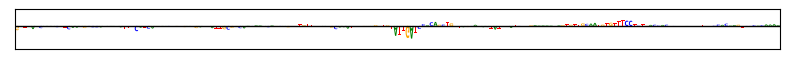

muscle


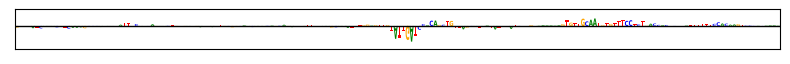

esophagus


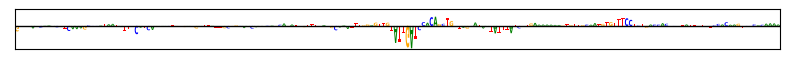

--------------------

-- Example = 46 --
 - ENSG00000116785(+)
 - chr1:196529001-197053289
 -- min_val = -0.433
 -- max_val = 1.223
 - (Gradient score profiles per tissue) - 


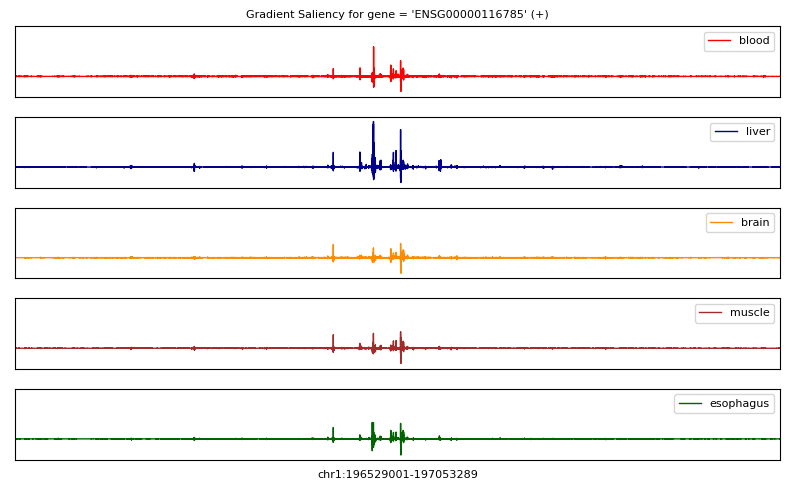

 - (Gradient score comparison against 'liver') - 
blood (r = 0.216)
brain (r = 0.247)
muscle (r = 0.313)
esophagus (r = 0.182)


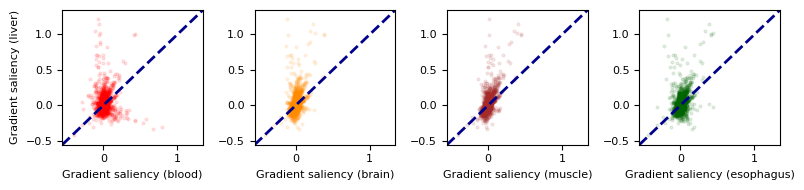

 - (Differential gradient score of liver against 'mean') -
blood (r = -0.06)
brain (r = 0.309)
muscle (r = 0.556)
esophagus (r = 0.199)


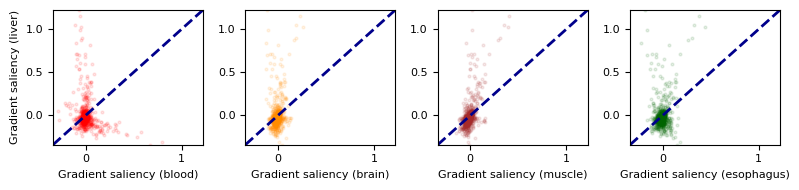

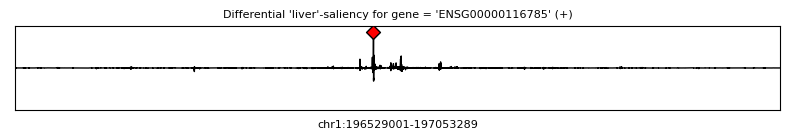

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 245736
 - max_pos (abs) = 196774737
 - chr1:196774641-196774833
blood


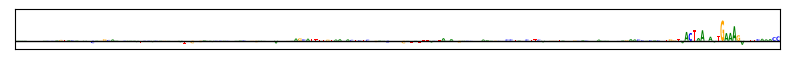

liver


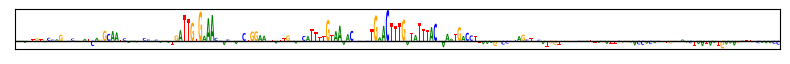

brain


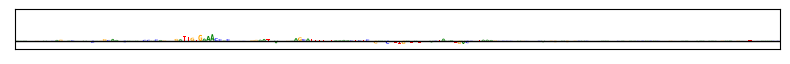

muscle


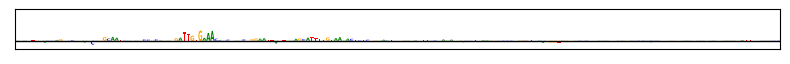

esophagus


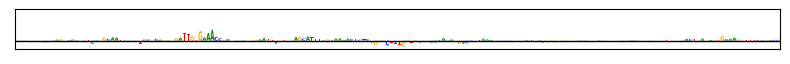

--------------------

-- Example = 47 --
 - ENSG00000120054(-)
 - chr10:99801709-100325997
 -- min_val = -3.879
 -- max_val = 4.336
 - (Gradient score profiles per tissue) - 


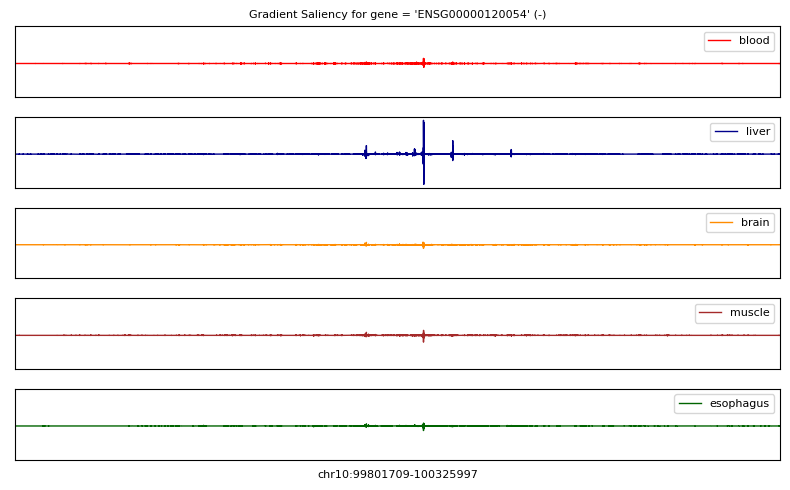

 - (Gradient score comparison against 'liver') - 
blood (r = 0.338)
brain (r = 0.249)
muscle (r = 0.32)
esophagus (r = 0.286)


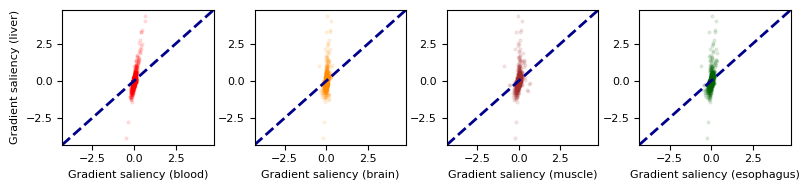

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.778)
brain (r = 0.523)
muscle (r = 0.582)
esophagus (r = 0.615)


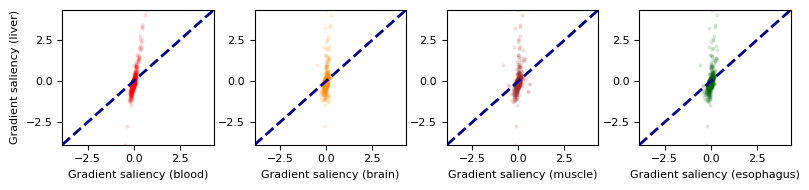

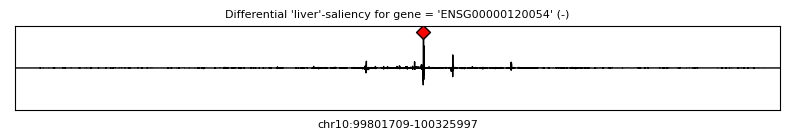

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 279999
 - max_pos (abs) = 100081708
 - chr10:100081612-100081804
blood


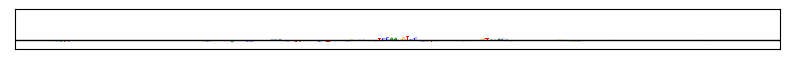

liver


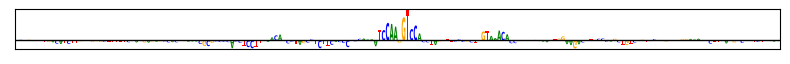

brain


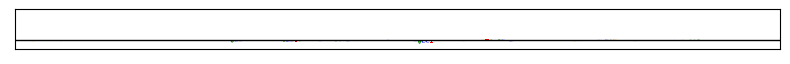

muscle


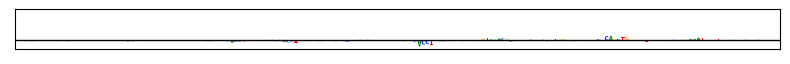

esophagus


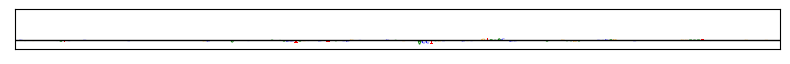

--------------------

-- Example = 48 --
 - ENSG00000166391(+)
 - chr11:75467547-75991835
 -- min_val = -1.334
 -- max_val = 3.287
 - (Gradient score profiles per tissue) - 


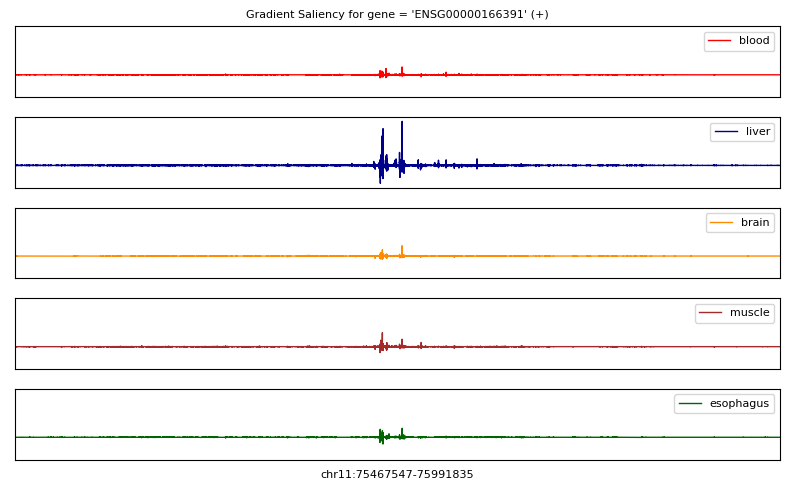

 - (Gradient score comparison against 'liver') - 
blood (r = 0.175)
brain (r = 0.303)
muscle (r = 0.306)
esophagus (r = 0.142)


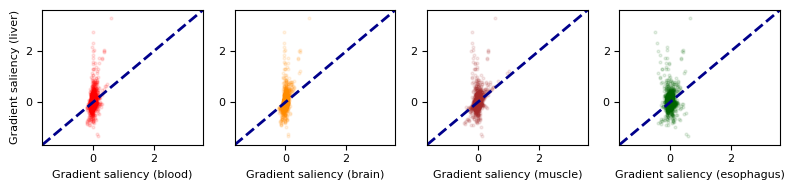

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.305)
brain (r = 0.412)
muscle (r = 0.355)
esophagus (r = 0.185)


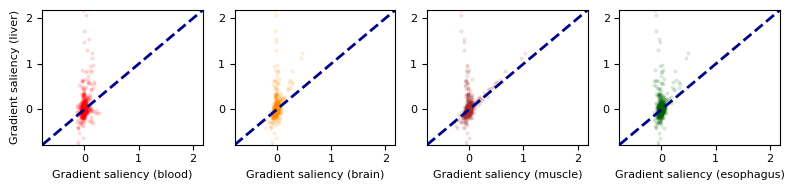

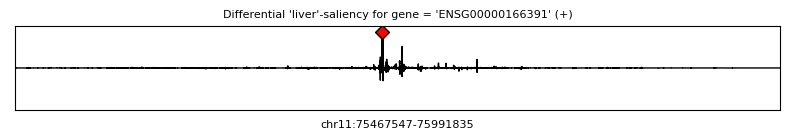

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 251380
 - max_pos (abs) = 75718927
 - chr11:75718831-75719023
blood


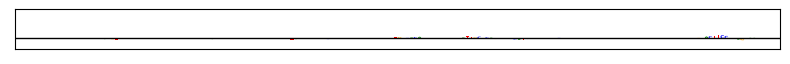

liver


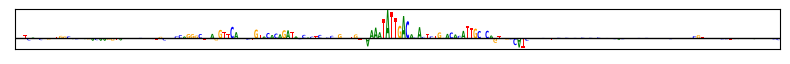

brain


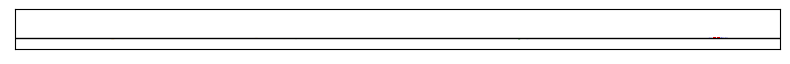

muscle


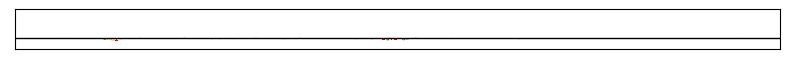

esophagus


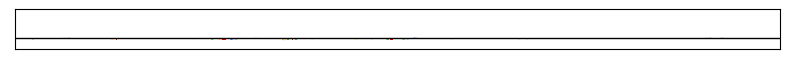

--------------------

-- Example = 49 --
 - ENSG00000162460(+)
 - chr1:15483175-16007463
 -- min_val = -0.7017
 -- max_val = 0.9873
 - (Gradient score profiles per tissue) - 


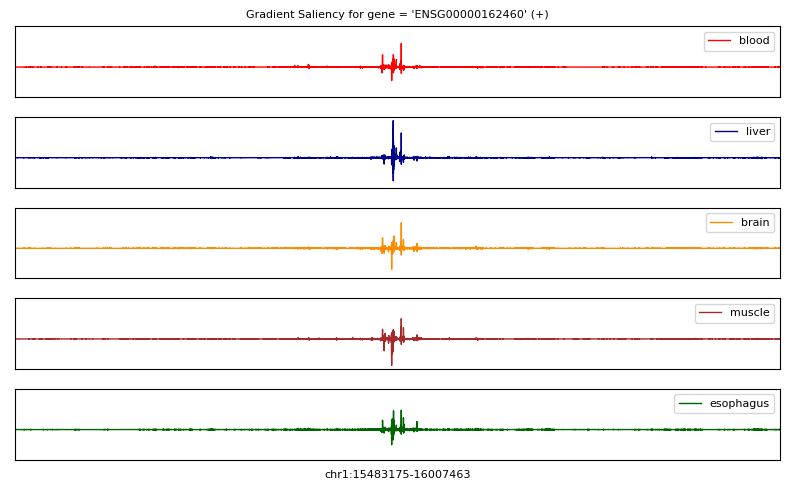

 - (Gradient score comparison against 'liver') - 
blood (r = 0.216)
brain (r = 0.141)
muscle (r = 0.168)
esophagus (r = 0.057)


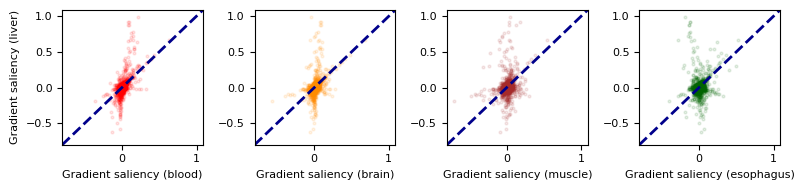

 - (Differential gradient score of liver against 'mean') -
blood (r = 0.756)
brain (r = 0.527)
muscle (r = 0.324)
esophagus (r = 0.189)


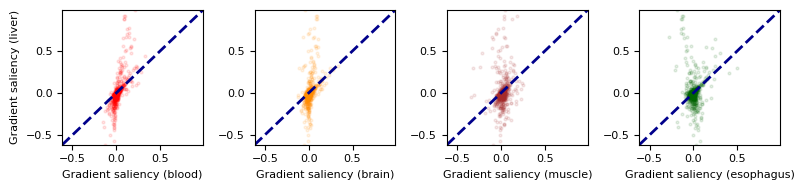

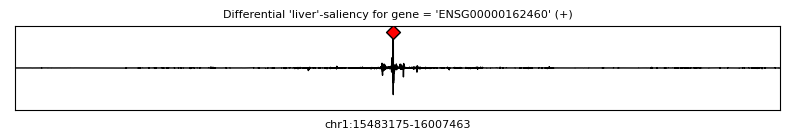

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 259276
 - max_pos (abs) = 15742451
 - chr1:15742355-15742547
blood


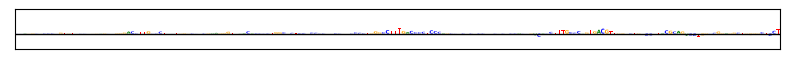

liver


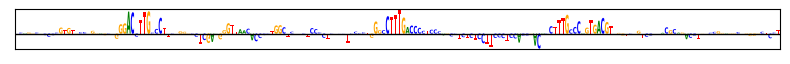

brain


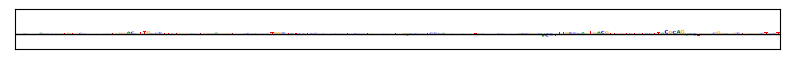

muscle


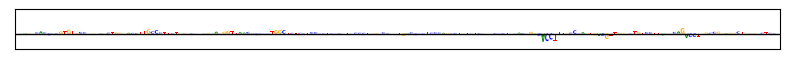

esophagus


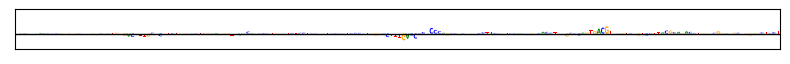

--------------------



In [6]:
#Enumerate and visualize attributions (relative fold changes); liver

save_figs = True
save_prefix = 'attribution_figs/borzoi_v2_diff_expr_grads_5_tissues_4_folds_' + tissue

save_index = [2, 4, 8]

#Select tissue to find maximally differential score locus for
main_tissue_ix = 1

#Visualization parameters
logo_width = 192

top_n = 50

use_gaussian = True
min_padding = 65536
gaussian_sigma = 8
local_window = 1024

tissue_colors = ['red', 'darkblue', 'darkorange', 'brown', 'darkgreen']

#Loop over examples
for example_ix in range(top_n) :
    
    print("-- Example = " + str(example_ix)+ " --")
    
    save_figs_curr = False
    if save_figs and example_ix in set(save_index) :
        save_figs_curr = True
    
    print(" - " + tissue_genes[example_ix] + "(" + str(strands[example_ix]) + ")")
    print(" - " + chrs[example_ix] + ":" + str(starts[example_ix]) + "-" + str(ends[example_ix]))

    #Grad analysis
    
    #Calculate min and max scores globally (for scales)
    min_val = np.min(scores[:, example_ix, ...])
    max_val = np.max(scores[:, example_ix, ...])
    
    print(" -- min_val = " + str(round(min_val, 4)))
    print(" -- max_val = " + str(round(max_val, 4)))
    
    max_abs_val = max(np.abs(min_val), np.abs(max_val))

    min_val -= 0.1 * max_abs_val
    max_val += 0.1 * max_abs_val

    print(" - (Gradient score profiles per tissue) - ")
    
    #Gradient profiles across input sequence
    f, ax = plt.subplots(len(gtex_tissues), 1, figsize=(8, len(gtex_tissues) * 1))

    #Loop over tissues
    for tissue_ix in range(len(gtex_tissues)) :

        #Get tissue scores
        score = scores[tissue_ix, example_ix, ...]

        l1 = ax[tissue_ix].plot(np.arange(seqs.shape[1]), np.sum(score, axis=-1), linewidth=1, linestyle='-', color=tissue_colors[tissue_ix], label=gtex_tissues[tissue_ix])
        
        plt.sca(ax[tissue_ix])
        
        plt.xlim(0, seqs.shape[1])
        plt.ylim(min_val, max_val)
        
        plt.legend(handles=[l1[0]], fontsize=8)
        
        plt.yticks([], [])
        plt.xticks([], [])
    
    plt.sca(ax[0])
    plt.title("Gradient Saliency for gene = '" + tissue_genes[example_ix] + "' (" + str(strands[example_ix]) + ")", fontsize=8)
    
    plt.sca(ax[len(gtex_tissues)-1])
    plt.xlabel(chrs[example_ix] + ":" + str(starts[example_ix]) + "-" + str(ends[example_ix]), fontsize=8)
    
    plt.sca(plt.gca())
    plt.tight_layout()

    if save_figs_curr :
        plt.savefig(save_prefix + '_scores_example_ix_' + str(example_ix) + ".png", dpi=300, transparent=False)
        plt.savefig(save_prefix + '_scores_example_ix_' + str(example_ix) + ".eps")
    
    plt.show()
    
    print(" - (Gradient score comparison against '" + gtex_tissues[main_tissue_ix] + "') - ")

    #Scatter plots of pairs of tissue-specific gradient scores
    f, ax = plt.subplots(1, len(gtex_tissues)-1, figsize=((len(gtex_tissues)-1) * 2, 2))
    
    #Gradient saliency for main tissue
    score_2 = scores[main_tissue_ix, example_ix, ...]

    #Loop over (other) tissues
    ax_ix = 0
    for tissue_ix in range(len(gtex_tissues)) :

        if tissue_ix != main_tissue_ix :
            
            #Gradient saliency for other tissue
            score_1 = scores[tissue_ix, example_ix, ...]
            
            #Compute spearman correlation between scores
            r_val, _ = spearmanr(np.sum(score_1, axis=-1), np.sum(score_2, axis=-1))
            
            #Print stats
            print(gtex_tissues[tissue_ix] + " (r = " + str(round(r_val, 3)) + ")")

            #Scatter plot of scores
            ax[ax_ix].scatter(np.sum(score_1, axis=-1), np.sum(score_2, axis=-1), s=4, color=tissue_colors[tissue_ix], alpha=0.1)

            ax[ax_ix].plot([min_val, max_val], [min_val, max_val], linewidth=2, linestyle='--', color='darkblue')

            plt.sca(ax[ax_ix])
            
            plt.xlim(min_val, max_val)
            plt.ylim(min_val, max_val)
            
            plt.xticks(fontsize=8)
            plt.yticks(fontsize=8)

            plt.xlabel("Gradient saliency (" + gtex_tissues[tissue_ix] + ")", fontsize=8)
            
            ax_ix += 1

    plt.sca(ax[0])
    plt.ylabel("Gradient saliency (" + gtex_tissues[main_tissue_ix] + ")", fontsize=8)
    
    plt.sca(plt.gca())
    plt.tight_layout()

    if save_figs_curr :
        plt.savefig(save_prefix + '_scatters_example_ix_' + str(example_ix) + ".png", dpi=300, transparent=False)
        plt.savefig(save_prefix + '_scatters_example_ix_' + str(example_ix) + ".eps")

    plt.show()
    
    print(" - (Differential gradient score of " + gtex_tissues[main_tissue_ix] + " against 'mean') -")

    #Get main tissue scores and background scores
    score_2 = scores[main_tissue_ix, example_ix, ...]
    score_1 = np.mean(scores[np.arange(len(gtex_tissues)) != main_tissue_ix, example_ix, ...], axis=0)

    #Compute differential scores
    diff_score = np.sum(score_2 - score_1, axis=-1)
    
    #Apply gaussian filter
    if use_gaussian :
        diff_score = gaussian_filter1d(diff_score.astype('float32'), sigma=gaussian_sigma, truncate=2).astype('float16')
    
    #Calculate min/max positions and (differential) values
    max_pos = np.argmax(diff_score[min_padding:-min_padding]) + min_padding
    min_pos = np.argmin(diff_score[min_padding:-min_padding]) + min_padding

    max_val = np.max(diff_score[min_padding:-min_padding])
    min_val = np.min(diff_score[min_padding:-min_padding])
    
    max_abs_val = max(np.abs(max_val), np.abs(min_val))

    #Scatter plots of pairs of tissue-specific gradient scores (local window around max position)
    f, ax = plt.subplots(1, len(gtex_tissues)-1, figsize=((len(gtex_tissues)-1) * 2, 2))
    
    min_val_orig = np.min(scores[:, example_ix, max_pos-local_window//2:max_pos+local_window//2, :])
    max_val_orig = np.max(scores[:, example_ix, max_pos-local_window//2:max_pos+local_window//2, :])
    
    #Gradient saliency for main tissue
    score_2_local = scores[main_tissue_ix, example_ix, max_pos-local_window//2:max_pos+local_window//2, :]

    #Loop over (other) tissues
    ax_ix = 0
    for tissue_ix in range(len(gtex_tissues)) :

        if tissue_ix != main_tissue_ix :
            
            #Gradient saliency for other tissue
            score_1_local = scores[tissue_ix, example_ix, max_pos-local_window//2:max_pos+local_window//2, :]
            
            #Compute spearman correlation between scores
            r_val, _ = spearmanr(np.sum(score_1_local, axis=-1), np.sum(score_2_local, axis=-1))
            
            #Print stats
            print(gtex_tissues[tissue_ix] + " (r = " + str(round(r_val, 3)) + ")")

            #Scatter plot of scores
            ax[ax_ix].scatter(np.sum(score_1_local, axis=-1), np.sum(score_2_local, axis=-1), s=4, color=tissue_colors[tissue_ix], alpha=0.1)

            ax[ax_ix].plot([min_val_orig, max_val_orig], [min_val_orig, max_val_orig], linewidth=2, linestyle='--', color='darkblue')

            plt.sca(ax[ax_ix])
            
            plt.xlim(min_val_orig, max_val_orig)
            plt.ylim(min_val_orig, max_val_orig)
            
            plt.xticks(fontsize=8)
            plt.yticks(fontsize=8)

            plt.xlabel("Gradient saliency (" + gtex_tissues[tissue_ix] + ")", fontsize=8)
            
            ax_ix += 1

    plt.sca(ax[0])
    plt.ylabel("Gradient saliency (" + gtex_tissues[main_tissue_ix] + ")", fontsize=8)
    
    plt.sca(plt.gca())
    plt.tight_layout()

    if save_figs_curr :
        plt.savefig(save_prefix + '_scatters_example_ix_' + str(example_ix) + "_local.png", dpi=300, transparent=False)
        plt.savefig(save_prefix + '_scatters_example_ix_' + str(example_ix) + "_local.eps")

    plt.show()

    #Plot differential scores
    f = plt.figure(figsize=(8, 1.5))

    plt.plot(np.arange(seqs.shape[1]), diff_score, color='black', linewidth=1, linestyle='-')
    
    plt.scatter([max_pos], [max_val], color='red', marker='D', s=50, linewidth=1, edgecolor='black', zorder=1000)

    plt.xlim(0, seqs.shape[1])
    plt.ylim(-max_abs_val*1.15, max_abs_val*1.15)
    
    plt.xticks([], [])
    plt.yticks([], [])

    plt.title("Differential '" + gtex_tissues[main_tissue_ix] + "'-saliency for gene = '" + tissue_genes[example_ix] + "' (" + str(strands[example_ix]) + ")", fontsize=8)
    
    plt.xlabel(chrs[example_ix] + ":" + str(starts[example_ix]) + "-" + str(ends[example_ix]), fontsize=8)
    
    plt.tight_layout()

    if save_figs_curr :
        plt.savefig(save_prefix + '_diff_scores_example_ix_' + str(example_ix) + ".png", dpi=300, transparent=False)
        plt.savefig(save_prefix + '_diff_scores_example_ix_' + str(example_ix) + ".eps")

    plt.show()

    print(" - (Attribution at position of Max positive differential saliency) -")

    print(" - max_pos (rel) = " + str(max_pos))
    print(" - max_pos (abs) = " + str(starts[example_ix] + max_pos))
    
    #Visualize contribution scores
    plot_start = max_pos - logo_width // 2
    plot_end = max_pos + logo_width // 2
    
    print(" - " + chrs[example_ix] + ":" + str(starts[example_ix] + max_pos - logo_width // 2) + "-" + str(starts[example_ix] + max_pos + logo_width // 2))

    #Logo min/max value across tissues
    min_logo_val = np.min(scores[:, example_ix, plot_start:plot_end, :])
    max_logo_val = np.max(scores[:, example_ix, plot_start:plot_end, :])

    max_abs_logo_val = max(np.abs(min_logo_val), np.abs(max_logo_val))

    min_logo_val -= 0.02 * max_abs_logo_val
    max_logo_val += 0.02 * max_abs_logo_val

    print(" - y_min = " + str(round(min_logo_val, 8)))
    print(" - y_max = " + str(round(max_logo_val, 8)))

    #Loop over tissues
    for tissue_ix in range(len(gtex_tissues)) :
        print(gtex_tissues[tissue_ix])

        #Get tissue-specific scores
        score = scores[tissue_ix, example_ix, plot_start:plot_end, :]

        #Plot scores as sequence logo
        plot_seq_scores(
            score,
            y_min=min_logo_val,
            y_max=max_logo_val,
            figsize=(8, 0.75),
            plot_y_ticks=False,
            save_figs=save_figs_curr,
            fig_name=save_prefix + '_logo_example_ix_' + str(example_ix) + '_tissue_ix_' + str(tissue_ix),
        )
    
    print("--------------------")
    print("")
